Setup

In [1]:
!pip install PyShp
!pip install contextily
!pip install geopandas
!pip install scikit-learn
!pip install pmdarima
!pip install dbfread

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import seaborn as sns

from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

from numpy import sqrt
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Extração

In [ ]:
import os

# Check if the file exists
file_path = "/content/drive/MyDrive/TCC/SuscetibilidadeBacias.shp"
print(os.path.exists(file_path))  # This should return True if the file is accessible

# List all files in the directory to verify
print(os.listdir("/content/drive/MyDrive/TCC"))


True
['dataset_ocorrencias.csv', 'Limite Municipal 07.2022.CPG', 'Limite Municipal 07.2022.prj', 'Limite Municipal 07.2022.dbf', 'Limite Municipal 07.2022.sbn', 'Limite Municipal 07.2022.sbx', 'SC_UF_2022.cpg', 'SC_UF_2022.shx', 'SC_UF_2022.shp', 'SC_UF_2022.dbf', 'SC_UF_2022.prj', 'fpolis_regiao', 'GQS_Template_Protocolo_SLR_V01 (1).docx', 'INMET2017.csv', 'INMET2018.csv', 'INMET2019.csv', 'INMET2020.csv', 'INMET2021.csv', 'INMET2022.csv', 'gvw_territoriais_visualizacao.shp', 'wfsrequest.txt', 'gvw_territoriais_visualizacao.shx', 'gvw_territoriais_visualizacao.cst', 'gvw_territoriais_visualizacao.dbf', 'gvw_territoriais_visualizacao.prj', 'gvw_bairros.prj', 'gvw_bairros.shp', 'gvw_bairros.shx', 'gvw_bairros.dbf', 'gvw_bairros.cst', 'Articulado_10M.prj', 'Articulado_10M.kmz', 'Articulado_10M.sbx', 'Articulado_10M.sbn', 'Articulado_10M.shp', 'Limite Municipal 07.2022.shx', 'SuscetibilidadeInundacao.sbx', 'SuscetibilidadeMovimentoDeMassa_UHT.prj', 'SuscetibilidadeMovimentoDeMassa_UHT.sbx

<ipython-input-105-07a6d37b347f>:34: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc="upper right")


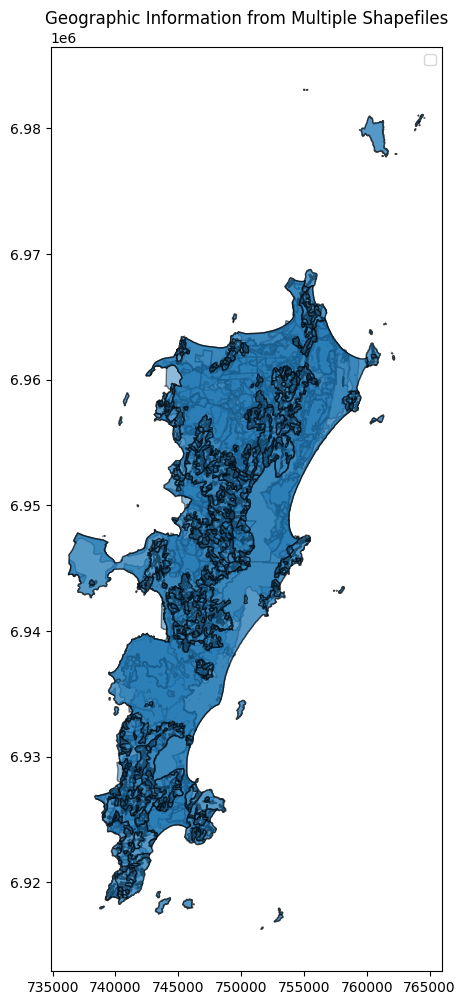

                                        BACIA   ID CLASSE  GRIDCODE  Area  \
SuscetibilidadeBacias               0       1  1.0  Baixa       NaN   NaN   
                                    1       3  2.0   Alta       NaN   NaN   
                                    2       2  3.0  Media       NaN   NaN   
                                    3       1  4.0  Baixa       NaN   NaN   
                                    4       2  5.0  Media       NaN   NaN   
...                                       ...  ...    ...       ...   ...   
SuscetibilidadeMovimentoDeMassa_UHT 457   NaN  NaN    NaN       NaN   NaN   
                                    458   NaN  NaN    NaN       NaN   NaN   
                                    459   NaN  NaN    NaN       NaN   NaN   
                                    460   NaN  NaN    NaN       NaN   NaN   
                                    461   NaN  NaN    NaN       NaN   NaN   

                                         Range  \
SuscetibilidadeBacias    

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# List of shapefile names (without extensions)
shapefiles = [
    "SuscetibilidadeBacias",
    "SuscetibilidadeEnxurradas",
    "SuscetibilidadeInundacao",
    "SuscetibilidadeMovimentoDeMassa",
    "SuscetibilidadeMovimentoDeMassa_UHT"
]

# Path to the directory containing shapefiles
base_path = "drive/MyDrive/TCC/"  # Replace with your file path

# Dictionary to store GeoDataFrames for each shapefile
gdfs = {}

# Load each shapefile into a GeoDataFrame and store it in the dictionary
for file in shapefiles:
    file_path = f"{base_path}{file}.shp"
    gdf = gpd.read_file(file_path)
    gdfs[file] = gdf  # Store the GeoDataFrame with the filename as the key

# Plotting all GeoDataFrames on the same figure
fig, ax = plt.subplots(figsize=(12, 12))

# Plot each GeoDataFrame with a unique color and label
for i, (name, gdf) in enumerate(gdfs.items()):
    gdf.plot(ax=ax, label=name, alpha=0.5, edgecolor="black")

# Add title and legend
plt.title("Geographic Information from Multiple Shapefiles")
plt.legend(loc="upper right")
plt.show()

# Optional: Combine all attribute data (non-geometric) into a single DataFrame
combined_df = pd.concat([gdf.drop(columns='geometry') for gdf in gdfs.values()], keys=gdfs.keys())
print(combined_df)


SuscetibilidadeBacias Data:
  BACIA  ID CLASSE                                           geometry
0     1   1  Baixa  POLYGON ((755070.832 6966085.42, 755103.394 69...
1     3   2   Alta  POLYGON ((757241.939 6962312.826, 757209.163 6...
2     2   3  Media  POLYGON ((754111.718 6963305.7, 754108.458 696...
3     1   4  Baixa  POLYGON ((758094.221 6962352.309, 758140.854 6...
4     2   5  Media  POLYGON ((750770.927 6963151.84, 750910.735 69...

Columns in SuscetibilidadeBacias:
Index(['BACIA', 'ID', 'CLASSE', 'geometry'], dtype='object')

SuscetibilidadeMovimentoDeMassa_UHT Data:
   UF      Municipio Classe  \
0  SC  Florianópolis   Alta   
1  SC  Florianópolis   Alta   
2  SC  Florianópolis   Alta   
3  SC  Florianópolis   Alta   
4  SC  Florianópolis   Alta   

                                            Processo  \
0  Deslizamento, corrida de massa, queda de rocha...   
1  Deslizamento, corrida de massa, queda de rocha...   
2  Deslizamento, corrida de massa, queda de rocha...   
3 

<ipython-input-18-f59312476041>:49: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc="upper right")


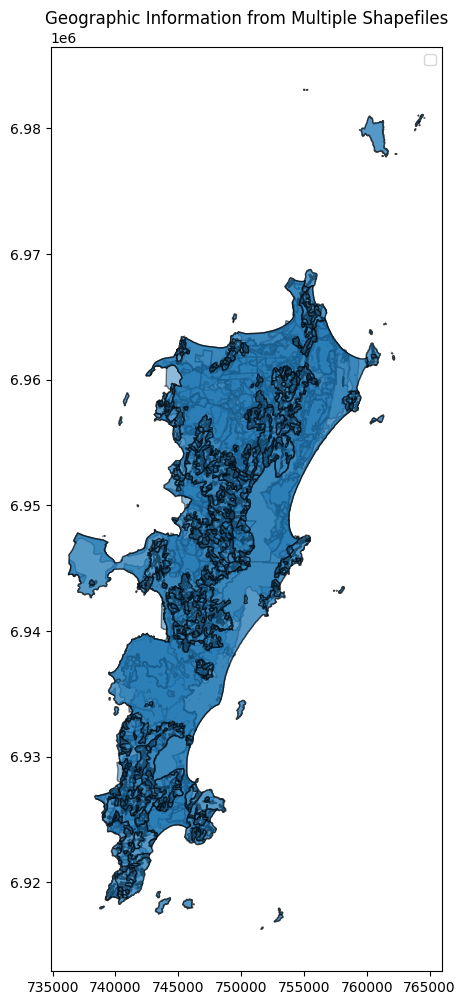

                                        BACIA   ID CLASSE  GRIDCODE  Area  \
SuscetibilidadeBacias               0       1  1.0  Baixa       NaN   NaN   
                                    1       3  2.0   Alta       NaN   NaN   
                                    2       2  3.0  Media       NaN   NaN   
                                    3       1  4.0  Baixa       NaN   NaN   
                                    4       2  5.0  Media       NaN   NaN   
...                                       ...  ...    ...       ...   ...   
SuscetibilidadeMovimentoDeMassa_UHT 457   NaN  NaN    NaN       NaN   NaN   
                                    458   NaN  NaN    NaN       NaN   NaN   
                                    459   NaN  NaN    NaN       NaN   NaN   
                                    460   NaN  NaN    NaN       NaN   NaN   
                                    461   NaN  NaN    NaN       NaN   NaN   

                                         Range  \
SuscetibilidadeBacias    

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd  # Make sure to import pandas for DataFrame operations

# List of shapefile names (without extensions)
shapefiles = [
    "SuscetibilidadeBacias",
    "SuscetibilidadeEnxurradas",
    "SuscetibilidadeInundacao",
    "SuscetibilidadeMovimentoDeMassa",
    "SuscetibilidadeMovimentoDeMassa_UHT"
]

# Path to the directory containing shapefiles
base_path = "drive/MyDrive/TCC/"  # Replace with your file path

# Dictionary to store GeoDataFrames for each shapefile
gdfs = {}

# Load each shapefile into a GeoDataFrame and store it in the dictionary
for file in shapefiles:
    file_path = f"{base_path}{file}.shp"
    gdf = gpd.read_file(file_path)
    gdfs[file] = gdf  # Store the GeoDataFrame with the filename as the key

# Display the filled columns for SuscetibilidadeBacias
print("SuscetibilidadeBacias Data:")
print(gdfs["SuscetibilidadeBacias"].head())  # Display first few rows

print("\nColumns in SuscetibilidadeBacias:")
print(gdfs["SuscetibilidadeBacias"].columns)  # List all columns

# Display the filled columns for SuscetibilidadeMovimentoDeMassa_UHT
print("\nSuscetibilidadeMovimentoDeMassa_UHT Data:")
print(gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].head())  # Display first few rows

print("\nColumns in SuscetibilidadeMovimentoDeMassa_UHT:")
print(gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].columns)  # List all columns

# Plotting all GeoDataFrames on the same figure
fig, ax = plt.subplots(figsize=(12, 12))

# Plot each GeoDataFrame with a unique color and label
for i, (name, gdf) in enumerate(gdfs.items()):
    gdf.plot(ax=ax, label=name, alpha=0.5, edgecolor="black")

# Add title and legend
plt.title("Geographic Information from Multiple Shapefiles")
plt.legend(loc="upper right")
plt.show()

# Optional: Combine all attribute data (non-geometric) into a single DataFrame
combined_df = pd.concat([gdf.drop(columns='geometry') for gdf in gdfs.values()], keys=gdfs.keys())
print(combined_df)


In [ ]:
import geopandas as gpd
import pandas as pd

# Sample GeoDataFrame (gdfs["SuscetibilidadeBacias"] in your case)
gdf_bacias = gdfs["SuscetibilidadeBacias"]

# Assume dfFloripa is your existing DataFrame
# Create a sample dfFloripa
data = {
    'latitude': [-27.595, -27.610, -27.580, -27.590],
    'longitude': [-48.548, -48.550, -48.540, -48.560],
    'Classe': [None] * 4  # Initial empty column for Classe
}
dfFloripa = pd.DataFrame(data)

# Loop through each row in the GeoDataFrame to extract bounds and Classe
for index, row in gdf_bacias.iterrows():
    geometry = row.geometry
    classe = row['CLASSE']  # Assuming 'CLASSE' is the column in gdf_bacias

    # Check if the geometry is a Polygon or MultiPolygon and extract bounds
    if geometry.geom_type in ['Polygon', 'MultiPolygon']:
        minx, miny, maxx, maxy = geometry.bounds

        # Apply conditions to dfFloripa based on the bounds
        condition = (
            (dfFloripa['latitude'] >= miny) & (dfFloripa['latitude'] <= maxy) &
            (dfFloripa['longitude'] >= minx) & (dfFloripa['longitude'] <= maxx)
        )

        # Assign the 'Classe' value to the rows that meet the condition
        dfFloripa.loc[condition, 'Classe'] = classe

# Display the updated dfFloripa
print(dfFloripa)


   latitude  longitude Classe
0   -27.595    -48.548   None
1   -27.610    -48.550   None
2   -27.580    -48.540   None
3   -27.590    -48.560   None


In [68]:
df = pd.read_csv('drive/MyDrive/TCC/dataset_ocorrencias.csv', sep=';', header=0)

<ipython-input-68-abb6d68c5246>:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('drive/MyDrive/TCC/dataset_ocorrencias.csv', sep=';', header=0)


In [82]:
df

id_ocorrencia  lat_ocorrencia  lon_ocorrencia  \
44            40045445      -28.684659      -49.388056   
59           130041858      -27.146564      -48.505497   
64            40046947      -28.679681      -49.364891   
88           130041869      -27.153351      -48.484377   
120          130041884      -27.034795      -48.669560   
...                ...             ...             ...   
1927109       80117658      -28.070704      -48.622803   
1927210       80117841      -28.026137      -48.615941   
1927242       20110446      -27.444620      -51.245612   
1927250       20110449      -27.392914      -51.218675   
1927337       20110484      -27.155513      -50.908091   

                                 tipo                   subtipo       Dates  \
44       SALVAMENTO / BUSCA / RESGATE                       NaN  2017-05-20   
59       SALVAMENTO / BUSCA / RESGATE                       NaN  2017-10-23   
64       SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2017-06-29   
88       SALVAMENTO / BUSCA / RESGATE                       NaN  2017-10-24   
120      SALVAMENTO / BUSCA / RESGATE                       NaN  2017-10-24   
...                               ...                       ...         ...   
1927109  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2021-01-13   
1927210  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2021-01-17   
1927242  SALVAMENTO / BUSCA / RESGATE               CAPOTAMENTO  2020-08-28   
1927250  SALVAMENTO / BUSCA / RESGATE            COLISÃO/CHOQUE  2020-08-28   
1927337  SALVAMENTO / BUSCA / RESGATE               CAPOTAMENTO  2020-08-29   

             Time  Hour  Year  Month  Day  
44       16:40:00    16  2017      5   20  
59       17:14:00    17  2017     10   23  
64       20:37:00    20  2017      6   29  
88       10:38:00    10  2017     10   24  
120      16:34:00    16  2017     10   24  
...           ...   ...   ...    ...  ...  
1927109  13:18:04    13  2021      1   13  
1927210  10:10:51    10  2021      1   17  
1927242  08:03:08     8  2020      8   28  
1927250  10:55:02    10  2020      8   28  
1927337  01:19:20     1  2020      8   29  

[23285 rows x 11 columns]

In [6]:
# prompt: print the number registers that have an NaN in any collumn from df dataset that is not on vitima, origem_samu or subtipo collumn

import pandas as pd

# Assuming 'df' is your DataFrame
nan_counts = df[df.columns.difference(['vitima', 'origem_samu', 'subtipo'])].isna().sum()
print(nan_counts)

registers_with_nan = df[df[df.columns.difference(['vitima', 'origem_samu', 'subtipo'])].isna().any(axis=1)]
num_registers = len(registers_with_nan)
print(f"\nNumber of registers with NaN in any column (excluding 'vitima', 'origem_samu', 'subtipo'): {num_registers}")

bc_indenizado              4511
cidade                        0
coordenada_obm            85108
coordenada_ocorrencia    765231
firecast                      0
horario                       0
id_ocorrencia                 0
lat_obm                  186509
lat_ocorrencia           765231
lon_obm                   85108
lon_ocorrencia           765231
militar_bc                 6697
mtcl                       4510
obm                        4510
populacao                     0
tempo_resposta           114331
tempo_total_empenho       15147
tipo                          0
vtr                           0
dtype: int64

Number of registers with NaN in any column (excluding 'vitima', 'origem_samu', 'subtipo'): 961370


In [9]:
# prompt: print how many number registers that are duplucated using id_ocorrencia from df dataset

# Count duplicated 'id_ocorrencia' values
duplicate_counts = df['id_ocorrencia'].duplicated(keep=False).sum()
print(f"Number of duplicated 'id_ocorrencia' registers: {duplicate_counts}")

Number of duplicated 'id_ocorrencia' registers: 1910828


In [12]:
inmet2017 = pd.read_csv('drive/MyDrive/TCC/INMET2017.csv', encoding='latin-1',  sep=';', header=0)

In [13]:
inmet2018 = pd.read_csv('drive/MyDrive/TCC/INMET2018.csv', encoding='latin-1',  sep=';', header=0)

In [14]:
inmet2019 = pd.read_csv('drive/MyDrive/TCC/INMET2019.csv', encoding='latin-1',  sep=';', header=0)

In [15]:
inmet2020 = pd.read_csv('drive/MyDrive/TCC/INMET2020.csv', encoding='latin-1',  sep=';', header=0)

In [16]:
inmet2021 = pd.read_csv('drive/MyDrive/TCC/INMET2021.csv', encoding='latin-1',  sep=';', header=0)

In [17]:
inmet = pd.concat([inmet2017, inmet2018, inmet2019, inmet2020, inmet2021])

In [18]:
inmet.rename(columns = {'Hour (UTC)':'Hour'}, inplace = True)
inmet.rename(columns = {'DATA (YYYY-MM-DD)':'Dates'}, inplace = True)

In [19]:
inmet.convert_dtypes().dtypes

Dates                                                    string[python]
HORA (UTC)                                               string[python]
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                         string[python]
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    string[python]
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          string[python]
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)         string[python]
RADIACAO GLOBAL (KJ/m²)                                  string[python]
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)             string[python]
TEMPERATURA DO PONTO DE ORVALHO (°C)                     string[python]
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)               string[python]
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)               string[python]
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)         string[python]
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)         string[python]
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                          Int64
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                          Int64
UMIDADE RELATIVA DO AR, HORARIA (%)                               Int64
VENTO, DIREÇÃO HORARIA (gr) (° (gr))                              Int64
VENTO, RAJADA MAXIMA (m/s)                               string[python]
VENTO, VELOCIDADE HORARIA (m/s)                          string[python]
Data                                                     string[python]
Hora UTC                                                 string[python]
RADIACAO GLOBAL (Kj/m²)                                  string[python]
dtype: object

In [20]:
inmet['DatesNew'] = inmet['Dates'].fillna(inmet['Data'])

In [21]:
inmet['Horas'] = inmet['HORA (UTC)'].str[0:2]

In [22]:
inmet['Horas2'] = inmet['Hora UTC'].str[0:2]

In [23]:
inmet['HorasNew'] = inmet['Horas'].fillna(inmet['Horas2'])

In [24]:

inmet['HorasN2'] = inmet['HorasNew'].apply(lambda x: x[1] if x[0] == '0' and len(x) == 2 else x)


In [25]:

inmet['DatesNew'] = inmet['DatesNew'].apply(lambda x: x.replace('/', '-'))


In [26]:


inmet['DatesNew'] = inmet['DatesNew'].apply(lambda x: x[6:10] + '-' + x[3:5] + '-' + x[0:2])


In [27]:
inmet['Radiacao'] = inmet['RADIACAO GLOBAL (KJ/m²)'].fillna(inmet['RADIACAO GLOBAL (Kj/m²)'])

In [28]:
inmet = inmet.drop(columns=['HORA (UTC)','Hora UTC','Horas',	'Horas2',	'Dates',	'Data', 'HorasNew'])

In [29]:
inmet = inmet.drop(columns=['RADIACAO GLOBAL (KJ/m²)','RADIACAO GLOBAL (Kj/m²)'])

In [30]:
inmet = inmet.assign(
    HorasN2=inmet.HorasN2.astype('int64')
)

In [32]:
inmet

PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  \
0                                 1,4   
1                                 1,8   
2                                 0,8   
3                                   0   
4                                   0   
...                               ...   
8755                              0,2   
8756                                0   
8757                                0   
8758                                0   
8759                                0   

     PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                                  1011      
1                                                1011,4      
2                                                1010,1      
3                                                1009,5      
4                                                  1009      
...                                                 ...      
8755                                             1006,4      
8756                                             1006,3      
8757                                             1006,3      
8758                                             1006,8      
8759                                             1007,6      

     PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
0                                               1011   
1                                             1011,4   
2                                             1011,4   
3                                             1010,2   
4                                             1009,5   
...                                              ...   
8755                                          1007,1   
8756                                          1006,4   
8757                                          1006,3   
8758                                          1006,9   
8759                                          1007,6   

     PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)  \
0                                              1009,7   
1                                              1010,7   
2                                              1010,1   
3                                              1009,5   
4                                              1008,9   
...                                               ...   
8755                                           1006,4   
8756                                           1006,2   
8757                                           1006,2   
8758                                           1006,3   
8759                                           1006,8   

     TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  \
0                                            23,5   
1                                            23,2   
2                                            23,5   
3                                            23,2   
4                                            23,3   
...                                           ...   
8755                                         24,5   
8756                                         25,5   
8757                                         25,4   
8758                                         24,9   
8759                                         24,5   

     TEMPERATURA DO PONTO DE ORVALHO (°C)  \
0                                    21,7   
1                                    21,5   
2                                    21,7   
3                                    21,3   
4                                    21,2   
...                                   ...   
8755                                 20,8   
8756                                   21   
8757                                 20,7   
8758                                 20,6   
8759                                 20,6   

     TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)  \
0                                            24   
1                                          23,6   
2                                          23,6   
3                          

In [31]:
# prompt: print how many registes on the collumns VENTO, DIREÇÃO HORARIA (gr) (º
# (gr)), VENTO, RAJADA MAXIMA (m/s) and VENTO,VELOCIDADE HORARIA
# (m/s) have NaN values, do it for each

# Count NaN values in specified columns
nan_counts = inmet[['VENTO, DIREÇÃO HORARIA (gr) (º\n(gr))', 'VENTO, RAJADA MAXIMA (m/s)', 'VENTO,VELOCIDADE HORARIA (m/s)']].isna().sum()
nan_counts

KeyError: "['VENTO, DIREÇÃO HORARIA (gr) (º\\n(gr))', 'VENTO,VELOCIDADE HORARIA (m/s)'] not in index"

Tratamento e Preparação

In [69]:
df['Dates'] = pd.to_datetime(df['horario']).dt.date
df['Time'] = pd.to_datetime(df['horario']).dt.time
df['Hour'] = pd.to_datetime(df['horario']).dt.hour

<ipython-input-69-27fdb2263cfc>:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Dates'] = pd.to_datetime(df['horario']).dt.date
<ipython-input-69-27fdb2263cfc>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Time'] = pd.to_datetime(df['horario']).dt.time
<ipython-input-69-27fdb2263cfc>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Hour'] = pd.to_datetime(df['horario']).dt.hour


In [70]:
df['Year']=  pd.to_datetime(df['horario']).dt.year
df['Month']=  pd.to_datetime(df['horario']).dt.month
df['Day']=  pd.to_datetime(df['horario']).dt.day

<ipython-input-70-bfddb419c999>:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Year']=  pd.to_datetime(df['horario']).dt.year
<ipython-input-70-bfddb419c999>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Month']=  pd.to_datetime(df['horario']).dt.month
<ipython-input-70-bfddb419c999>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Day']=  pd.to_datetime(df['horario']).dt.day


In [71]:
df.loc[:,'horario'] = pd.to_datetime(df.horario)

<ipython-input-71-b460541802f5>:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df.loc[:,'horario'] = pd.to_datetime(df.horario)


In [72]:
df = df.assign(
    cidade=df.cidade.astype("string"),
    obm=df.obm.astype("string"),
    vtr=df.vtr.astype("string"),
    vitima=df.vitima.astype("string")
)

In [73]:
df = df.assign(
    populacao=df.populacao.astype('int64')
)

In [74]:
df = df.assign(
    bc_indenizado=df.bc_indenizado.astype('bool'),
)

In [75]:
df = df.assign(
    mtcl=df.mtcl.astype('float64'),
    lat_ocorrencia=df.lat_ocorrencia.astype('float64'),
    lon_ocorrencia=df.lon_ocorrencia.astype('float64')
)

In [76]:
df.loc[:,'tempo_resposta'] = pd.to_timedelta(df.tempo_resposta)
df.loc[:,'tempo_total_empenho'] = pd.to_timedelta(df.tempo_total_empenho)

In [77]:
df = df[df['coordenada_ocorrencia'].notna()]

In [78]:
df = df.drop_duplicates('id_ocorrencia')

In [11]:
df

id_ocorrencia              cidade  populacao              horario  \
0            130042607  Balneário Camboriú     142295  22/11/2017 12:22:00   
5             40048428            Criciúma     215186  05/08/2017 20:19:00   
8             40045252            Criciúma     215186  14/05/2017 22:35:00   
9             80065079             Tubarão     105686  01/10/2017 14:55:00   
10           130041828          Porto Belo      21388  22/10/2017 04:12:00   
...                ...                 ...        ...                  ...   
1927374       80117899            Imbituba      44853  19/01/2021 00:41:28   
1927382       20110456             Videira      53065  28/08/2020 14:37:43   
1927383       80117875            Imbituba      44853  18/01/2021 10:11:33   
1927385       20110476             Videira      53065  28/08/2020 21:24:33   
1927392       20110461             Videira      53065  28/08/2020 15:22:11   

             vtr          mtcl militar_bc bc_indenizado  \
0         ASU414  9.166637e+06    Militar         False   
5        ASU-427  9.335790e+06    Militar         False   
8        ASU-427  9.318739e+06    Militar         False   
9        ASU-420  9.227938e+06    Militar         False   
10       ASU-338  9.318810e+06    Militar         False   
...          ...           ...        ...           ...   
1927374  ASU-282  9.271155e+06    Militar         False   
1927382  ASU-437  6.919138e+06    Militar         False   
1927383  ASU-282  9.271155e+06    Militar         False   
1927385  ASU-283  6.981020e+09         BC          True   
1927392  ASU-437  6.919138e+06    Militar         False   

                                     obm             coordenada_obm  ...  \
0        1ª/13º BBM - BALNEÁRIO CAMBORIÚ   [-48.6520784,-26.994043]  ...   
5                 1º/1ª/4ºBBM - CRICIUMA  [-49.3751335,-28.6836605]  ...   
8                 1º/1ª/4ºBBM - CRICIUMA  [-49.3751335,-28.6836605]  ...   
9                    1ª/8º BBM - TUBARÃO    [-49.011828,-28.472592]  ...   
10             2º/2ª/13ºBBM - PORTO BELO  [-48.5641134,-27.1565784]  ...   
...                                  ...                        ...  ...   
1927374          1º/2ª/8º BBM - IMBITUBA    [-48.660393,-28.238448]  ...   
1927382            1º/3ª/2ºBBM - VIDEIRA  [-51.1563431,-27.0002835]  ...   
1927383          1º/2ª/8º BBM - IMBITUBA    [-48.660393,-28.238448]  ...   
1927385            1º/3ª/2ºBBM - VIDEIRA  [-51.1563431,-27.0002835]  ...   
1927392            1º/3ª/2ºBBM - VIDEIRA  [-51.1563431,-27.0002835]  ...   

             coordenada_ocorrencia lat_ocorrencia lon_ocorrencia  \
0         [-48.653785,-26.9766732]     -26.976673     -48.653785   
5         [-49.3715459,-28.682409]     -28.682409     -49.371546   
8                              NaN            NaN            NaN   
9         [-49.0366121,-28.461907]     -28.461907     -49.036612   
10       [-48.5420467,-27.1542952]     -27.154295     -48.542047   
...                            ...            ...            ...   
1927374  [-48.6647577,-28.1906528]     -28.190653     -48.664758   
1927382   [-51.164017,-27.0036786]     -27.003679     -51.164017   
1927383  [-48.6647455,-28.2364033]     -28.236403     -48.664746   
1927385  [-51.1549718,-26.9975969]     -26.997597     -51.154972   
1927392   [-51.1465879,-26.998662]     -26.998662     -51.146588   

                               tipo                  subtipo tempo_resposta  \
0        ATENDIMENTO PRÉ-HOSPITALAR                      NaN       00:03:00   
5        ATENDIMENTO PRÉ-HOSPITALAR                      NaN       00:02:11   
8        ATENDIMENTO PRÉ-HOSPITALAR  EMERGÊNCIA PSIQUIÁTRICA       00:19:19   
9        ATENDIMENTO PRÉ-HOSPITALAR                      NaN       00:04:49   
10       ATENDIMENTO PRÉ-HOSPITALAR          DESMAIO/SÍNCOPE       00:00:07   
...                             ...                      ...            ...   
1927374  ATENDIMENTO PRÉ-HOSPITALAR                      NaN       00:11:00   
1

In [45]:
dfFloripa = df.copy()

In [43]:
dfFloripa = dfFloripa.query("cidade == 'Florianópolis'")

In [44]:
dfFloripa

id_ocorrencia         cidade  populacao              horario  \
107           10065490  Florianópolis     500973  2017-01-20 20:03:00   
278           10075324  Florianópolis     500973  2017-07-03 14:27:00   
279           10073843  Florianópolis     500973  2017-06-05 15:02:00   
287           10077079  Florianópolis     500973  2017-08-02 22:58:00   
290           10065232  Florianópolis     500973  2017-01-17 09:39:00   
...                ...            ...        ...                  ...   
1769046       10138030  Florianópolis     500973  2021-01-17 19:56:33   
1769054       10138036  Florianópolis     500973  2021-01-17 21:50:51   
1769072       10138059  Florianópolis     500973  2021-01-18 12:08:11   
1769081       10138050  Florianópolis     500973  2021-01-18 10:30:57   
1769153       10138069  Florianópolis     500973  2021-01-18 15:05:14   

              vtr       mtcl militar_bc  bc_indenizado  \
107       ASU-263  9212876.0    Militar          False   
278      ABTR-116  9219803.0    Militar          False   
279       ASU-410  9316930.0    Militar          False   
287       ASU-400  9228446.0    Militar          False   
290       ASU-433  9122281.0    Militar          False   
...           ...        ...        ...            ...   
1769046   ASU-351  6098100.0    Militar          False   
1769054   ASU-433  6098711.0    Militar          False   
1769072   ASU-433  9317724.0    Militar          False   
1769081   ASU-351  9292853.0    Militar          False   
1769153   ASU-287  9301291.0    Militar          False   

                                               obm             coordenada_obm  \
107        3ºGBM/2ºPEL/2ªCBM/1º BBM - CANASVIEIRAS  [-48.4567022,-27.4525704]   
278                   2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
279                             1º/2ª/1º BBM - GBS  [-48.5630772,-27.5922913]   
287      2ºGBM/2ªPEL/2ªCBM/1º BBM - BARRA DA LAGOA  [-48.4333134,-27.5749765]   
290                                         1|8105                     1|8105   
...                                            ...                        ...   
1769046      1ºGBM/1ºPEL/1ªCBM/1ºBBM - RIO TAVARES  [-48.5046816,-27.6696182]   
1769054    3ºGBM/2ºPEL/2ªCBM/1º BBM - CANASVIEIRAS  [-48.4567022,-27.4525704]   
1769072    3ºGBM/2ºPEL/2ªCBM/1º BBM - CANASVIEIRAS  [-48.4567022,-27.4525704]   
1769081      1ºGBM/1ºPEL/1ªCBM/1ºBBM - RIO TAVARES  [-48.5046816,-27.6696182]   
1769153               2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   

         ...  tempo_total_empenho firecast origem_samu       vitima  \
107      ...      0 days 02:48:42     True         NaN         <NA>   
278      ...      0 days 01:10:50     True         NaN         <NA>   
279      ...      0 days 00:01:29    False         NaN         <NA>   
287      ...      0 days 00:11:21     True         NaN         <NA>   
290      ...      0 days 01:09:36     True         NaN  FLN2017|586   
...      ...                  ...      ...         ...          ...   
1769046  ...      0 days 00:00:24    False         NaN  FLN2020|309   
1769054  ...      0 days 00:00:06     True         NaN  FLN2020|316   
1769072  ...      0 days 01:14:33     True         NaN  FLN2020|328   
1769081  ...      0 days 00:41:26     True         NaN  FLN2020|324   
1769153  ...      0 days 00:49:07     True         NaN         <NA>   

              Dates      Time Hour  Year Month  Day  
107      2017-01-20  20:03:00   20  2017     1   20  
278      2017-07-03  14:27:00   14  2017     7    3  
279      2017-06-05  15:02:00   15  2017     6    5  
287      2017-08-02  22:58:00   22  2017     8    2  
290      2017-01-17  09:39:00    9  2017     1   17  
...             ...       ...  ...   ...   ...  ...  
1769046  2021-01-17  19:56:33   19  2021     1   17  
1769054  2021-01-17  21:50:51   21  2021     1   17  
1769072  2021-01-18  12:08:11   12  2021     1   18  
1769081  2021-01-18  10:30:57   10  2021     1   18  
1769153  2021-0

In [47]:
dfFloripa = dfFloripa.loc[((dfFloripa.tipo == 'SALVAMENTO / BUSCA / RESGATE') & (dfFloripa.subtipo != 'SUICÍDIO/TENTATIVA') & (dfFloripa.subtipo != 'EXPLOSÃO') & (dfFloripa.subtipo != 'AFOGAMENTO') & (dfFloripa.subtipo != 'NaN')) ]

In [48]:
dfFloripa

id_ocorrencia        cidade  populacao              horario  \
44            40045445      Criciúma     215186  2017-05-20 16:40:00   
59           130041858     Bombinhas      19769  2017-10-23 17:14:00   
64            40046947      Criciúma     215186  2017-06-29 20:37:00   
88           130041869     Bombinhas      19769  2017-10-24 10:38:00   
120          130041884      Camboriú      82989  2017-10-24 16:34:00   
...                ...           ...        ...                  ...   
1927109       80117658      Garopaba      23078  2021-01-13 13:18:04   
1927210       80117841      Garopaba      23078  2021-01-17 10:10:51   
1927242       20110446  Campos Novos      36244  2020-08-28 08:03:08   
1927250       20110449  Campos Novos      36244  2020-08-28 10:55:02   
1927337       20110484   Monte Carlo       9866  2020-08-29 01:19:20   

              vtr          mtcl militar_bc  bc_indenizado  \
44       ABTR-113  9.277544e+06    Militar          False   
59        ABTR-87  9.264027e+06    Militar          False   
64       ABTR-113  9.320750e+06    Militar          False   
88        ABTR-87  9.291288e+06    Militar          False   
120       ASU-411  9.243020e+06    Militar          False   
...           ...           ...        ...            ...   
1927109  ABTR-050  9.240225e+06    Militar          False   
1927210  ABTR-050  7.614069e+10         BC           True   
1927242   ABTR-54  6.918824e+06    Militar          False   
1927250   ABTR-54  9.234985e+06    Militar          False   
1927337   ASU-353  6.922899e+06    Militar          False   

                                    obm             coordenada_obm  ...  \
44               1º/1ª/4ºBBM - CRICIUMA  [-49.3751335,-28.6836605]  ...   
59             3º/2ª/13ºBBM - BOMBINHAS  [-48.5074345,-27.1451944]  ...   
64               1º/1ª/4ºBBM - CRICIUMA  [-49.3751335,-28.6836605]  ...   
88             3º/2ª/13ºBBM - BOMBINHAS  [-48.5074345,-27.1451944]  ...   
120            3º/1ª/13º BBM - CAMBORIÚ  [-48.6633901,-27.0266477]  ...   
...                                 ...                        ...  ...   
1927109         3º/2ª/8º BBM - GAROPABA    [-48.642016,-28.049871]  ...   
1927210         3º/2ª/8º BBM - GAROPABA    [-48.642016,-28.049871]  ...   
1927242     3º/1ª/2º BBM - CAMPOS NOVOS  [-51.2231719,-27.3975582]  ...   
1927250     3º/1ª/2º BBM - CAMPOS NOVOS  [-51.2231719,-27.3975582]  ...   
1927337  3º/2º/3ª/2º BBM  - MONTE CARLO  [-50.9810304,-27.2183286]  ...   

         tempo_total_empenho firecast origem_samu        vitima       Dates  \
44           0 days 00:34:20     True         NaN          <NA>  2017-05-20   
59           0 days 00:06:59    False         NaN          <NA>  2017-10-23   
64           0 days 00:30:29    False         NaN          <NA>  2017-06-29   
88           0 days 00:22:54    False         NaN          <NA>  2017-10-24   
120          0 days 00:57:35    False         NaN  BCU2017|5788  2017-10-24   
...                      ...      ...         ...           ...         ...   
1927109      0 days 00:48:00    False         NaN          <NA>  2021-01-13   
1927210      0 days 00:46:08    False         NaN          <NA>  2021-01-17   
1927242      0 days 00:00:06    False         NaN          <NA>  2020-08-28   
1927250      0 days 00:00:04     True         NaN          <NA>  2020-08-28   
1927337      0 days 00:27:10     True         NaN          <NA>  2020-08-29   

             Time Hour  Year Month  Day  
44       16:40:00   16  2017     5   20  
59       17:14:00   17  2017    10   23  
64       20:37:00   20  2017     6   29  
88       10:38:00   10  2017    10   24  
120      16:34:00   16  2017    10   24  
...           ...  ...   ...   ...  ...  
1927109  13:18:04   13  2021     1   13  
1927210  10:10:51   10  2021     1   17  
1927242  08:03:08    8  2020     8   28  
1927250  10:55:02   10  2020     8   28  
1927337  01:19:20    1  2020     8   29  

[23285 rows x 28 columns]

In [79]:
df = df.loc[((df.tipo == 'SALVAMENTO / BUSCA / RESGATE') & (df.subtipo != 'SUICÍDIO/TENTATIVA') & (df.subtipo != 'EXPLOSÃO') & (df.subtipo != 'AFOGAMENTO') & (df.subtipo != 'NaN')) ]

In [80]:
df

id_ocorrencia        cidade  populacao              horario  \
44            40045445      Criciúma     215186  2017-05-20 16:40:00   
59           130041858     Bombinhas      19769  2017-10-23 17:14:00   
64            40046947      Criciúma     215186  2017-06-29 20:37:00   
88           130041869     Bombinhas      19769  2017-10-24 10:38:00   
120          130041884      Camboriú      82989  2017-10-24 16:34:00   
...                ...           ...        ...                  ...   
1927109       80117658      Garopaba      23078  2021-01-13 13:18:04   
1927210       80117841      Garopaba      23078  2021-01-17 10:10:51   
1927242       20110446  Campos Novos      36244  2020-08-28 08:03:08   
1927250       20110449  Campos Novos      36244  2020-08-28 10:55:02   
1927337       20110484   Monte Carlo       9866  2020-08-29 01:19:20   

              vtr          mtcl militar_bc  bc_indenizado  \
44       ABTR-113  9.277544e+06    Militar          False   
59        ABTR-87  9.264027e+06    Militar          False   
64       ABTR-113  9.320750e+06    Militar          False   
88        ABTR-87  9.291288e+06    Militar          False   
120       ASU-411  9.243020e+06    Militar          False   
...           ...           ...        ...            ...   
1927109  ABTR-050  9.240225e+06    Militar          False   
1927210  ABTR-050  7.614069e+10         BC           True   
1927242   ABTR-54  6.918824e+06    Militar          False   
1927250   ABTR-54  9.234985e+06    Militar          False   
1927337   ASU-353  6.922899e+06    Militar          False   

                                    obm             coordenada_obm  ...  \
44               1º/1ª/4ºBBM - CRICIUMA  [-49.3751335,-28.6836605]  ...   
59             3º/2ª/13ºBBM - BOMBINHAS  [-48.5074345,-27.1451944]  ...   
64               1º/1ª/4ºBBM - CRICIUMA  [-49.3751335,-28.6836605]  ...   
88             3º/2ª/13ºBBM - BOMBINHAS  [-48.5074345,-27.1451944]  ...   
120            3º/1ª/13º BBM - CAMBORIÚ  [-48.6633901,-27.0266477]  ...   
...                                 ...                        ...  ...   
1927109         3º/2ª/8º BBM - GAROPABA    [-48.642016,-28.049871]  ...   
1927210         3º/2ª/8º BBM - GAROPABA    [-48.642016,-28.049871]  ...   
1927242     3º/1ª/2º BBM - CAMPOS NOVOS  [-51.2231719,-27.3975582]  ...   
1927250     3º/1ª/2º BBM - CAMPOS NOVOS  [-51.2231719,-27.3975582]  ...   
1927337  3º/2º/3ª/2º BBM  - MONTE CARLO  [-50.9810304,-27.2183286]  ...   

         tempo_total_empenho firecast origem_samu        vitima       Dates  \
44           0 days 00:34:20     True         NaN          <NA>  2017-05-20   
59           0 days 00:06:59    False         NaN          <NA>  2017-10-23   
64           0 days 00:30:29    False         NaN          <NA>  2017-06-29   
88           0 days 00:22:54    False         NaN          <NA>  2017-10-24   
120          0 days 00:57:35    False         NaN  BCU2017|5788  2017-10-24   
...                      ...      ...         ...           ...         ...   
1927109      0 days 00:48:00    False         NaN          <NA>  2021-01-13   
1927210      0 days 00:46:08    False         NaN          <NA>  2021-01-17   
1927242      0 days 00:00:06    False         NaN          <NA>  2020-08-28   
1927250      0 days 00:00:04     True         NaN          <NA>  2020-08-28   
1927337      0 days 00:27:10     True         NaN          <NA>  2020-08-29   

             Time Hour  Year Month  Day  
44       16:40:00   16  2017     5   20  
59       17:14:00   17  2017    10   23  
64       20:37:00   20  2017     6   29  
88       10:38:00   10  2017    10   24  
120      16:34:00   16  2017    10   24  
...           ...  ...   ...   ...  ...  
1927109  13:18:04   13  2021     1   13  
1927210  10:10:51   10  2021     1   17  
1927242  08:03:08    8  2020     8   28  
1927250  10:55:02   10  2020     8   28  
1927337  01:19:20    1  2020     8   29  

[23285 rows x 28 columns]

In [ ]:
     dfFloripa

id_ocorrencia         cidade  populacao              horario  \
1729          10077086  Florianópolis     500973  03/08/2017 04:00:00   
1852          10083288  Florianópolis     500973  24/11/2017 12:38:00   
1853          10082420  Florianópolis     500973  09/11/2017 15:46:00   
1855          10082354  Florianópolis     500973  08/11/2017 18:55:00   
4437          10068370  Florianópolis     500973  04/03/2017 21:53:00   
...                ...            ...        ...                  ...   
1767958       10137822  Florianópolis     500973  13/01/2021 08:36:44   
1768099       10137648  Florianópolis     500973  09/01/2021 14:54:18   
1768438       10137748  Florianópolis     500973  11/01/2021 16:09:36   
1768557       10137866  Florianópolis     500973  14/01/2021 13:31:02   
1768937       10137885  Florianópolis     500973  14/01/2021 19:55:21   

              vtr          mtcl militar_bc bc_indenizado  \
1729       AR-118  9.213031e+06    Militar         False   
1852     ABTR-116  9.305165e+06    Militar         False   
1853     ABTR-116  9.232818e+06    Militar         False   
1855     ABTR-116  9.184430e+06    Militar         False   
4437      ABT-059  9.232818e+06    Militar         False   
...           ...           ...        ...           ...   
1767958   ABS-006  6.100104e+06    Militar         False   
1768099   ABS-006  9.993541e+06    Militar         False   
1768438   ABTR-66  6.118397e+10         BC          True   
1768557  ABTR-140  6.098100e+06    Militar         False   
1768937   ABTR-66  6.099084e+06    Militar         False   

                                               obm             coordenada_obm  \
1729                                        1|8105                     1|8105   
1852                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1853                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1855                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
4437                            1º/2ª/1º BBM - GBS  [-48.5630772,-27.5922913]   
...                                            ...                        ...   
1767958  2ºGBM/2ªPEL/2ªCBM/1º BBM - BARRA DA LAGOA  [-48.4333134,-27.5749765]   
1768099  2ºGBM/2ªPEL/2ªCBM/1º BBM - BARRA DA LAGOA  [-48.4333134,-27.5749765]   
1768438               2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1768557      1ºGBM/1ºPEL/1ªCBM/1ºBBM - RIO TAVARES  [-48.5046816,-27.6696182]   
1768937               2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   

         ...      coordenada_ocorrencia lat_ocorrencia lon_ocorrencia  \
1729     ...  [-48.3979868,-27.4334614]     -27.433461     -48.397987   
1852     ...  [-48.5277459,-27.6128247]     -27.612825     -48.527746   
1853     ...  [-48.5538404,-27.6843907]     -27.684391     -48.553840   
1855     ...    [-48.51543,-27.5668056]     -27.566806     -48.515430   
4437     ...  [-48.5363546,-27.5914568]     -27.591457     -48.536355   
...      ...                        ...            ...            ...   
1767958  ...   [-48.402242,-27.4415161]     -27.441516     -48.402242   
1768099  ...   [-48.433085,-27.5746952]     -27.574695     -48.433085   
1768438  ...  [-48.5224257,-27.5968483]     -27.596848     -48.522426   
1768557  ...  [-48.5017968,-27.6764467]     -27.676447     -48.501797   
1768937  ...  [-48.5730224,-27.5937625]     -27.593763     -48.573022   

                                 tipo                   subtipo  \
1729     SALVAMENTO / BUSCA / RESGATE            COLISÃO/CHOQUE   
1852     SALVAMENTO / BUSCA / RESGATE                       NaN   
1853     SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO   
1855     SALVAMENTO / BUSCA / RESGATE                       NaN   
4437     SALVAMENTO / BUSCA / RESGATE              DESLIZAMENTO   
...                               ...                       ...   
1767958  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO   
1768099  SALVAMENTO / BUS

In [49]:
dfFloripa = dfFloripa[dfFloripa.lat_ocorrencia < -27.3]

In [50]:
dfFloripa = dfFloripa[dfFloripa.lon_ocorrencia > -48.611]

In [ ]:
dfFloripa

id_ocorrencia         cidade  populacao              horario  \
1729          10077086  Florianópolis     500973  2017-08-03 04:00:00   
1852          10083288  Florianópolis     500973  2017-11-24 12:38:00   
1853          10082420  Florianópolis     500973  2017-11-09 15:46:00   
1855          10082354  Florianópolis     500973  2017-11-08 18:55:00   
4437          10068370  Florianópolis     500973  2017-03-04 21:53:00   
...                ...            ...        ...                  ...   
1767958       10137822  Florianópolis     500973  2021-01-13 08:36:44   
1768099       10137648  Florianópolis     500973  2021-01-09 14:54:18   
1768438       10137748  Florianópolis     500973  2021-01-11 16:09:36   
1768557       10137866  Florianópolis     500973  2021-01-14 13:31:02   
1768937       10137885  Florianópolis     500973  2021-01-14 19:55:21   

              vtr          mtcl militar_bc  bc_indenizado  \
1729       AR-118  9.213031e+06    Militar          False   
1852     ABTR-116  9.305165e+06    Militar          False   
1853     ABTR-116  9.232818e+06    Militar          False   
1855     ABTR-116  9.184430e+06    Militar          False   
4437      ABT-059  9.232818e+06    Militar          False   
...           ...           ...        ...            ...   
1767958   ABS-006  6.100104e+06    Militar          False   
1768099   ABS-006  9.993541e+06    Militar          False   
1768438   ABTR-66  6.118397e+10         BC           True   
1768557  ABTR-140  6.098100e+06    Militar          False   
1768937   ABTR-66  6.099084e+06    Militar          False   

                                               obm             coordenada_obm  \
1729                                        1|8105                     1|8105   
1852                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1853                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1855                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
4437                            1º/2ª/1º BBM - GBS  [-48.5630772,-27.5922913]   
...                                            ...                        ...   
1767958  2ºGBM/2ªPEL/2ªCBM/1º BBM - BARRA DA LAGOA  [-48.4333134,-27.5749765]   
1768099  2ºGBM/2ªPEL/2ªCBM/1º BBM - BARRA DA LAGOA  [-48.4333134,-27.5749765]   
1768438               2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1768557      1ºGBM/1ºPEL/1ªCBM/1ºBBM - RIO TAVARES  [-48.5046816,-27.6696182]   
1768937               2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   

         ...  tempo_total_empenho firecast origem_samu  vitima       Dates  \
1729     ...      0 days 00:52:42     True         NaN    <NA>  2017-08-03   
1852     ...      0 days 00:53:02     True         NaN    <NA>  2017-11-24   
1853     ...      0 days 05:03:53     True         NaN    <NA>  2017-11-09   
1855     ...      0 days 00:16:45     True         NaN    <NA>  2017-11-08   
4437     ...      0 days 02:35:41    False         NaN    <NA>  2017-03-04   
...      ...                  ...      ...         ...     ...         ...   
1767958  ...      0 days 00:44:24     True         NaN    <NA>  2021-01-13   
1768099  ...      0 days 00:28:13     True         NaN    <NA>  2021-01-09   
1768438  ...      0 days 00:30:56     True         NaN    <NA>  2021-01-11   
1768557  ...      0 days 00:28:21     True         NaN    <NA>  2021-01-14   
1768937  ...      0 days 00:29:17     True         NaN    <NA>  2021-01-14   

             Time Hour  Year Month  Day  
1729     04:00:00    4  2017     8    3  
1852     12:38:00   12  2017    11   24  
1853     15:46:00   15  2017    11    9  
1855     18:55:00   18  2017    11    8  
4437     21:53:00   21  2017     3    4  
...           ...  ...   ...   ...  ...  
1767958  08:36:44    8  2021     1   13  
1768099  14:54:18   14  2021     1    9  
1768438  16:09:36   16  2021     1   11  
1768557  13:31:02   13  2021     1   14  
1768937  19:55:21   19  202

it defines gdfFloripa


In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# List of shapefile names (without extensions)
shapefiles = [
    "SuscetibilidadeBacias",
    "SuscetibilidadeEnxurradas",
    "SuscetibilidadeInundacao",
    "SuscetibilidadeMovimentoDeMassa",
    "SuscetibilidadeMovimentoDeMassa_UHT"
]

# Path to the directory containing shapefiles
base_path = "drive/MyDrive/TCC/"  # Replace with your file path

# Dictionary to store GeoDataFrames for each shapefile
gdfs = {}

# Load each shapefile into a GeoDataFrame and store it in the dictionary
for file in shapefiles:
    file_path = f"{base_path}{file}.shp"
    gdf = gpd.read_file(file_path)
    gdfs[file] = gdf  # Store the GeoDataFrame with the filename as the key


# Convert dfFloripa to a GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(dfFloripa['lon_ocorrencia'], dfFloripa['lat_ocorrencia'])]
gdf_floripa = gpd.GeoDataFrame(dfFloripa, geometry=geometry, crs="EPSG:4326")  # Ensure you set the correct CRS

# Initialize empty columns for Classe
dfFloripa['Classe_Bacias'] = None
dfFloripa['Classe_Movimento'] = None

# Classify points based on SuscetibilidadeBacias
for index, row in gdfs["SuscetibilidadeBacias"].iterrows():
    polygon = row.geometry
    classe = row['CLASSE']  # Adjust if the column name is different

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    # Assign the Classe value to dfFloripa based on the condition
    dfFloripa.loc[condition, 'Classe_Bacias'] = classe

# Classify points based on SuscetibilidadeMovimentoDeMassa_UHT
for index, row in gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].iterrows():
    polygon = row.geometry
    classe = row['Classe']  # Adjust if the column name is different

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    # Assign the Classe value to dfFloripa based on the condition
    dfFloripa.loc[condition, 'Classe_Movimento'] = classe

# Display the updated dfFloripa
print(dfFloripa)


         id_ocorrencia         cidade  populacao              horario  \
1729          10077086  Florianópolis     500973  2017-08-03 04:00:00   
1852          10083288  Florianópolis     500973  2017-11-24 12:38:00   
1853          10082420  Florianópolis     500973  2017-11-09 15:46:00   
1855          10082354  Florianópolis     500973  2017-11-08 18:55:00   
4437          10068370  Florianópolis     500973  2017-03-04 21:53:00   
...                ...            ...        ...                  ...   
1767958       10137822  Florianópolis     500973  2021-01-13 08:36:44   
1768099       10137648  Florianópolis     500973  2021-01-09 14:54:18   
1768438       10137748  Florianópolis     500973  2021-01-11 16:09:36   
1768557       10137866  Florianópolis     500973  2021-01-14 13:31:02   
1768937       10137885  Florianópolis     500973  2021-01-14 19:55:21   

              vtr          mtcl militar_bc  bc_indenizado  \
1729       AR-118  9.213031e+06    Militar          False   
1

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# List of shapefile names (without extensions)
shapefiles = [
    "SuscetibilidadeBacias",
    "SuscetibilidadeEnxurradas",
    "SuscetibilidadeInundacao",
    "SuscetibilidadeMovimentoDeMassa",
    "SuscetibilidadeMovimentoDeMassa_UHT"
]

# Path to the directory containing shapefiles
base_path = "drive/MyDrive/TCC/"  # Replace with your file path

# Dictionary to store GeoDataFrames for each shapefile
gdfs = {}

# Load each shapefile into a GeoDataFrame and store it in the dictionary
for file in shapefiles:
    file_path = f"{base_path}{file}.shp"
    gdf = gpd.read_file(file_path)
    gdfs[file] = gdf  # Store the GeoDataFrame with the filename as the key


# Convert dfFloripa to a GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(dfFloripa['lon_ocorrencia'], dfFloripa['lat_ocorrencia'])]
gdf_floripa = gpd.GeoDataFrame(df4, geometry=geometry, crs="EPSG:4326")  # Ensure you set the correct CRS

# Initialize empty columns for Classe
df4['Classe_Bacias'] = None
df4['Classe_Movimento'] = None

# Classify points based on SuscetibilidadeBacias
for index, row in gdfs["SuscetibilidadeBacias"].iterrows():
    polygon = row.geometry
    classe = row['CLASSE']  # Adjust if the column name is different

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    # Assign the Classe value to dfFloripa based on the condition
    df4.loc[condition, 'Classe_Bacias'] = classe

# Classify points based on SuscetibilidadeMovimentoDeMassa_UHT
for index, row in gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].iterrows():
    polygon = row.geometry
    classe = row['Classe']  # Adjust if the column name is different

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    # Assign the Classe value to dfFloripa based on the condition
    df4.loc[condition, 'Classe_Movimento'] = classe

# Display the updated dfFloripa
print(df4)


     id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
91        10064414      -27.447496      -48.425808  2017-01-04  09:11:00   
93        10064717      -27.455293      -48.380926  2017-01-09  08:57:00   
92        10064915      -27.596752      -48.574580  2017-01-12  14:07:00   
21        10065157      -27.467694      -48.446634  2017-01-16  08:22:00   
201       10065272      -27.601925      -48.512678  2017-01-17  20:11:00   
..             ...             ...             ...         ...       ...   
626       10137885      -27.593763      -48.573022  2021-01-14  19:55:21   
505       10137890      -27.589377      -48.550147  2021-01-14  22:30:11   
540       10137909      -27.535046      -48.511553  2021-01-15  11:40:53   
523       10137954      -27.415774      -48.425837  2021-01-16  12:20:57   
510       10138032      -27.597699      -48.565381  2021-01-17  20:27:40   

     Hour  Year  Month  Day Classe_Bacias Classe_Movimento  Quantity  \
91      9  2017

In [ ]:
dfFloripa.Classe_Bacias.unique()

array([None], dtype=object)

In [ ]:
# Check the CRS of both GeoDataFrames
print(gdf_floripa.crs)
print(gdfs["SuscetibilidadeBacias"].crs)
print(gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].crs)

# If they are different, transform gdf_floripa to match the GeoDataFrames
gdf_floripa = gdf_floripa.to_crs(gdfs["SuscetibilidadeBacias"].crs)


NameError: name 'gdf_floripa' is not defined

here ir makes PROJECT_X and Y

In [ ]:
# Transform dfFloripa to match the CRS of SuscetibilidadeBacias
gdf_floripa = gdf_floripa.to_crs(epsg=32722)

# After transforming, re-run the classification process
# Initialize empty columns for Classe
dfFloripa['Classe_Bacias'] = None
dfFloripa['Classe_Movimento'] = None

# Classify points based on SuscetibilidadeBacias
for index, row in gdfs["SuscetibilidadeBacias"].iterrows():
    polygon = row.geometry
    classe = row['CLASSE']  # Adjust if the column name is different

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    # Print how many points were found within the polygon
    if condition.any():
        print(f"Found {condition.sum()} points in {classe}")

    # Assign the Classe value to dfFloripa based on the condition
    dfFloripa.loc[condition, 'Classe_Bacias'] = classe

# Classify points based on SuscetibilidadeMovimentoDeMassa_UHT
for index, row in gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].iterrows():
    polygon = row.geometry
    classe = row['Classe']  # Adjust if the column name is different

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    # Print how many points were found within the polygon
    if condition.any():
        print(f"Found {condition.sum()} points in {classe}")

    # Assign the Classe value to dfFloripa based on the condition
    dfFloripa.loc[condition, 'Classe_Movimento'] = classe

# Display the updated dfFloripa
print(dfFloripa[['lat_ocorrencia', 'lon_ocorrencia', 'Classe_Bacias', 'Classe_Movimento']])


Found 7 points in Baixa
Found 14 points in Alta
Found 5 points in Media
Found 2 points in Baixa
Found 7 points in Media
Found 7 points in Media
Found 4 points in Media
Found 11 points in Alta
Found 9 points in Alta
Found 1 points in Baixa
Found 1 points in Media
Found 24 points in Alta
Found 1 points in Alta
Found 1 points in Baixa
Found 8 points in Alta
Found 16 points in Media
Found 13 points in Baixa
Found 2 points in Media
Found 20 points in Alta
Found 29 points in Baixa
Found 10 points in Baixa
Found 22 points in Baixa
Found 2 points in Media
Found 55 points in Alta
Found 17 points in Baixa
Found 6 points in Baixa
Found 3 points in Baixa
Found 5 points in Media
Found 3 points in Baixa
Found 4 points in Alta
Found 2 points in Baixa
Found 12 points in Alta
Found 2 points in Alta
Found 10 points in Alta
Found 2 points in Alta
Found 4 points in Alta
Found 1 points in Media
Found 3 points in Alta
Found 1 points in Baixa
Found 2 points in Alta
Found 1 points in Alta
Found 4 points in Al

In [ ]:
# Transform dfFloripa to match the CRS of SuscetibilidadeBacias
gdf_floripa = gdf_floripa.to_crs(epsg=32722)

# After transforming, re-run the classification process
# Initialize empty columns for Classe
df4['Classe_Bacias'] = None
df4['Classe_Movimento'] = None

# Classify points based on SuscetibilidadeBacias
for index, row in gdfs["SuscetibilidadeBacias"].iterrows():
    polygon = row.geometry
    classe = row['CLASSE']  # Adjust if the column name is different

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    # Print how many points were found within the polygon
    if condition.any():
        print(f"Found {condition.sum()} points in {classe}")

    # Assign the Classe value to dfFloripa based on the condition
    df4.loc[condition, 'Classe_Bacias'] = classe

# Classify points based on SuscetibilidadeMovimentoDeMassa_UHT
for index, row in gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].iterrows():
    polygon = row.geometry
    classe = row['Classe']  # Adjust if the column name is different

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    # Print how many points were found within the polygon
    if condition.any():
        print(f"Found {condition.sum()} points in {classe}")

    # Assign the Classe value to dfFloripa based on the condition
    df4.loc[condition, 'Classe_Movimento'] = classe

# Display the updated dfFloripa
print(df4[['lat_ocorrencia', 'lon_ocorrencia', 'Classe_Bacias', 'Classe_Movimento']])


Found 7 points in Baixa
Found 14 points in Alta
Found 5 points in Media
Found 2 points in Baixa
Found 7 points in Media
Found 7 points in Media
Found 4 points in Media
Found 11 points in Alta
Found 9 points in Alta
Found 1 points in Baixa
Found 1 points in Media
Found 24 points in Alta
Found 1 points in Alta
Found 1 points in Baixa
Found 8 points in Alta
Found 16 points in Media
Found 13 points in Baixa
Found 2 points in Media
Found 20 points in Alta
Found 29 points in Baixa
Found 10 points in Baixa
Found 22 points in Baixa
Found 2 points in Media
Found 55 points in Alta
Found 17 points in Baixa
Found 6 points in Baixa
Found 3 points in Baixa
Found 5 points in Media
Found 3 points in Baixa
Found 4 points in Alta
Found 2 points in Baixa
Found 12 points in Alta
Found 2 points in Alta
Found 10 points in Alta
Found 2 points in Alta
Found 4 points in Alta
Found 1 points in Media
Found 3 points in Alta
Found 1 points in Baixa
Found 2 points in Alta
Found 1 points in Alta
Found 4 points in Al

THE BEST ONEEEEEEEEEE


In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Assuming gdf_floripa and gdfs are already defined
# Transform dfFloripa to match the CRS of SuscetibilidadeBacias
gdf_floripa = gdf_floripa.to_crs(epsg=32722)

# Initialize empty columns for Classe
dfFloripa['Classe_Bacias'] = None
dfFloripa['Classe_Movimento'] = None

# Classify points based on SuscetibilidadeBacias
for index, row in gdfs["SuscetibilidadeBacias"].iterrows():
    polygon = row.geometry
    classe = row['CLASSE']

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    # Print how many points were found within the polygon
    if condition.any():
        print(f"Found {condition.sum()} points in {classe}")

    # Assign the Classe value to dfFloripa based on the condition
    dfFloripa.loc[condition, 'Classe_Bacias'] = classe

# Classify points based on SuscetibilidadeMovimentoDeMassa_UHT
for index, row in gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].iterrows():
    polygon = row.geometry
    classe = row['Classe']

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    # Print how many points were found within the polygon
    if condition.any():
        print(f"Found {condition.sum()} points in {classe}")

    # Assign the Classe value to dfFloripa based on the condition
    dfFloripa.loc[condition, 'Classe_Movimento'] = classe

# Now fill None values with the closest non-None class
def fill_closest_class(row):
    point = Point(row['Projected_X'], row['Projected_Y'])  # Ensure these columns exist
    classe_bacias = row['Classe_Bacias']
    classe_movimento = row['Classe_Movimento']

    if pd.isnull(classe_bacias):
        # Find the closest polygon in SuscetibilidadeBacias
        distances = gdfs["SuscetibilidadeBacias"].geometry.distance(point)
        valid_classes = gdfs["SuscetibilidadeBacias"].loc[gdfs["SuscetibilidadeBacias"]['CLASSE'].notnull()]
        valid_distances = distances[valid_classes.index]

        if not valid_distances.empty:
            closest_idx = valid_distances.idxmin()
            classe_bacias = gdfs["SuscetibilidadeBacias"].loc[closest_idx]['CLASSE']

    if pd.isnull(classe_movimento):
        # Find the closest polygon in SuscetibilidadeMovimentoDeMassa_UHT
        distances = gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].geometry.distance(point)
        valid_classes = gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].loc[gdfs["SuscetibilidadeMovimentoDeMassa_UHT"]['Classe'].notnull()]
        valid_distances = distances[valid_classes.index]

        if not valid_distances.empty:
            closest_idx = valid_distances.idxmin()
            classe_movimento = gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].loc[closest_idx]['Classe']

    return pd.Series([classe_bacias, classe_movimento])  # Return a Series

# Apply the function to fill in None values
dfFloripa[['Classe_Bacias', 'Classe_Movimento']] = dfFloripa.apply(fill_closest_class, axis=1)

# Display the updated dfFloripa
print(dfFloripa[['lat_ocorrencia', 'lon_ocorrencia', 'Classe_Bacias', 'Classe_Movimento']])


Found 7 points in Baixa
Found 14 points in Alta
Found 5 points in Media
Found 2 points in Baixa
Found 7 points in Media
Found 7 points in Media
Found 4 points in Media
Found 11 points in Alta
Found 9 points in Alta
Found 1 points in Baixa
Found 1 points in Media
Found 24 points in Alta
Found 1 points in Alta
Found 1 points in Baixa
Found 8 points in Alta
Found 16 points in Media
Found 13 points in Baixa
Found 2 points in Media
Found 20 points in Alta
Found 29 points in Baixa
Found 10 points in Baixa
Found 22 points in Baixa
Found 2 points in Media
Found 55 points in Alta
Found 17 points in Baixa
Found 6 points in Baixa
Found 3 points in Baixa
Found 5 points in Media
Found 3 points in Baixa
Found 4 points in Alta
Found 2 points in Baixa
Found 12 points in Alta
Found 2 points in Alta
Found 10 points in Alta
Found 2 points in Alta
Found 4 points in Alta
Found 1 points in Media
Found 3 points in Alta
Found 1 points in Baixa
Found 2 points in Alta
Found 1 points in Alta
Found 4 points in Al

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Convert df4 to a GeoDataFrame if it isn't already
df4['geometry'] = df4.apply(lambda row: Point(row['lon_ocorrencia'], row['lat_ocorrencia']), axis=1)
gdf4 = gpd.GeoDataFrame(df4, geometry='geometry', crs="EPSG:4326")

# Transform gdf4 to match the CRS of SuscetibilidadeBacias
gdf4 = gdf4.to_crs(epsg=32722)

# Initialize empty columns for Classe
gdf4['Classe_Bacias'] = None
gdf4['Classe_Movimento'] = None

# Classify points based on SuscetibilidadeBacias
for index, row in gdfs["SuscetibilidadeBacias"].iterrows():
    polygon = row.geometry
    classe = row['CLASSE']

    # Check if any point in gdf4 is contained in the polygon
    condition = gdf4.geometry.within(polygon)

    # Print how many points were found within the polygon
    if condition.any():
        print(f"Found {condition.sum()} points in {classe}")

    # Assign the Classe value to gdf4 based on the condition
    gdf4.loc[condition, 'Classe_Bacias'] = classe

# Classify points based on SuscetibilidadeMovimentoDeMassa_UHT
for index, row in gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].iterrows():
    polygon = row.geometry
    classe = row['Classe']

    # Check if any point in gdf4 is contained in the polygon
    condition = gdf4.geometry.within(polygon)

    # Print how many points were found within the polygon
    if condition.any():
        print(f"Found {condition.sum()} points in {classe}")

    # Assign the Classe value to gdf4 based on the condition
    gdf4.loc[condition, 'Classe_Movimento'] = classe

# Fill None values with the closest non-None class
def fill_closest_class(row):
    point = row.geometry
    classe_bacias = row['Classe_Bacias']
    classe_movimento = row['Classe_Movimento']

    if pd.isnull(classe_bacias):
        # Find the closest polygon in SuscetibilidadeBacias
        distances = gdfs["SuscetibilidadeBacias"].geometry.distance(point)
        valid_classes = gdfs["SuscetibilidadeBacias"].loc[gdfs["SuscetibilidadeBacias"]['CLASSE'].notnull()]
        valid_distances = distances[valid_classes.index]

        if not valid_distances.empty:
            closest_idx = valid_distances.idxmin()
            classe_bacias = gdfs["SuscetibilidadeBacias"].loc[closest_idx]['CLASSE']

    if pd.isnull(classe_movimento):
        # Find the closest polygon in SuscetibilidadeMovimentoDeMassa_UHT
        distances = gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].geometry.distance(point)
        valid_classes = gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].loc[gdfs["SuscetibilidadeMovimentoDeMassa_UHT"]['Classe'].notnull()]
        valid_distances = distances[valid_classes.index]

        if not valid_distances.empty:
            closest_idx = valid_distances.idxmin()
            classe_movimento = gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].loc[closest_idx]['Classe']

    return pd.Series([classe_bacias, classe_movimento])  # Return a Series

# Apply the function to fill in None values
gdf4[['Classe_Bacias', 'Classe_Movimento']] = gdf4.apply(fill_closest_class, axis=1)

# Display the updated gdf4
print(gdf4[['lat_ocorrencia', 'lon_ocorrencia', 'Classe_Bacias', 'Classe_Movimento']])


Found 7 points in Baixa
Found 14 points in Alta
Found 5 points in Media
Found 2 points in Baixa
Found 7 points in Media
Found 7 points in Media
Found 4 points in Media
Found 11 points in Alta
Found 9 points in Alta
Found 1 points in Baixa
Found 1 points in Media
Found 24 points in Alta
Found 1 points in Alta
Found 1 points in Baixa
Found 8 points in Alta
Found 16 points in Media
Found 13 points in Baixa
Found 2 points in Media
Found 20 points in Alta
Found 29 points in Baixa
Found 10 points in Baixa
Found 22 points in Baixa
Found 2 points in Media
Found 55 points in Alta
Found 17 points in Baixa
Found 6 points in Baixa
Found 3 points in Baixa
Found 5 points in Media
Found 3 points in Baixa
Found 4 points in Alta
Found 2 points in Baixa
Found 12 points in Alta
Found 2 points in Alta
Found 10 points in Alta
Found 2 points in Alta
Found 4 points in Alta
Found 1 points in Media
Found 3 points in Alta
Found 1 points in Baixa
Found 2 points in Alta
Found 1 points in Alta
Found 4 points in Al

In [ ]:
df4

id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
91        10064414      -27.447496      -48.425808  2017-01-04  09:11:00   
93        10064717      -27.455293      -48.380926  2017-01-09  08:57:00   
92        10064915      -27.596752      -48.574580  2017-01-12  14:07:00   
21        10065157      -27.467694      -48.446634  2017-01-16  08:22:00   
201       10065272      -27.601925      -48.512678  2017-01-17  20:11:00   
..             ...             ...             ...         ...       ...   
626       10137885      -27.593763      -48.573022  2021-01-14  19:55:21   
505       10137890      -27.589377      -48.550147  2021-01-14  22:30:11   
540       10137909      -27.535046      -48.511553  2021-01-15  11:40:53   
523       10137954      -27.415774      -48.425837  2021-01-16  12:20:57   
510       10138032      -27.597699      -48.565381  2021-01-17  20:27:40   

     Hour  Year  Month  Day Classe_Bacias Classe_Movimento  Quantity  \
91      9  2017      1    4          Alta            Baixa         1   
93      8  2017      1    9          None            Baixa         1   
92     14  2017      1   12          None            Baixa         1   
21      8  2017      1   16          None            Baixa         1   
201    20  2017      1   17          None             Alta         1   
..    ...   ...    ...  ...           ...              ...       ...   
626    19  2021      1   14          Alta            Baixa         4   
505    22  2021      1   14         Baixa            Baixa         4   
540    11  2021      1   15         Baixa            Baixa         1   
523    12  2021      1   16          Alta            Baixa         1   
510    20  2021      1   17          None            Baixa         1   

     Quantity_scaled    Projected_X   Projected_Y     Classe_Suscetibilidade  \
91               0.0  754429.786039  6.961363e+06      SuscetibilidadeBacias   
93               0.0  758849.405957  6.960406e+06      SuscetibilidadeBacias   
92               0.0  739396.393107  6.945118e+06  SuscetibilidadeEnxurradas   
21               0.0  752324.549457  6.959167e+06      SuscetibilidadeBacias   
201              0.0  745496.960342  6.944423e+06      SuscetibilidadeBacias   
..               ...            ...           ...                        ...   
626              0.6  739556.650497  6.945446e+06      SuscetibilidadeBacias   
505              0.6  741824.983112  6.945888e+06      SuscetibilidadeBacias   
540              0.0  745757.067942  6.951833e+06      SuscetibilidadeBacias   
523              0.0  754499.766592  6.964879e+06      SuscetibilidadeBacias   
510              0.0  740302.597863  6.944995e+06      SuscetibilidadeBacias   

                            geometry  
91    POINT (-48.425808 -27.4474963)  
93   POINT (-48.3809261 -27.4552931)  
92   POINT (-48.5745796 -27.5967517)  
21    POINT (-48.446634 -27.4676943)  
201  POINT (-48.5126775 -27.6019247)  
..                               ...  
626  POINT (-48.5730224 -27.5937625)  
505   POINT (-48.5501472 -27.589377)  
540   POINT (-48.511553 -27.5350464)  
523  POINT (-48.4258367 -27.4157742)  
510  POINT (-48.5653807 -27.5976992)  

[627 rows x 17 columns]

In [ ]:
dfFloripa

id_ocorrencia         cidade  populacao              horario  \
1729          10077086  Florianópolis     500973  2017-08-03 04:00:00   
1852          10083288  Florianópolis     500973  2017-11-24 12:38:00   
1853          10082420  Florianópolis     500973  2017-11-09 15:46:00   
1855          10082354  Florianópolis     500973  2017-11-08 18:55:00   
4437          10068370  Florianópolis     500973  2017-03-04 21:53:00   
...                ...            ...        ...                  ...   
1767958       10137822  Florianópolis     500973  2021-01-13 08:36:44   
1768099       10137648  Florianópolis     500973  2021-01-09 14:54:18   
1768438       10137748  Florianópolis     500973  2021-01-11 16:09:36   
1768557       10137866  Florianópolis     500973  2021-01-14 13:31:02   
1768937       10137885  Florianópolis     500973  2021-01-14 19:55:21   

              vtr          mtcl militar_bc  bc_indenizado  \
1729       AR-118  9.213031e+06    Militar          False   
1852     ABTR-116  9.305165e+06    Militar          False   
1853     ABTR-116  9.232818e+06    Militar          False   
1855     ABTR-116  9.184430e+06    Militar          False   
4437      ABT-059  9.232818e+06    Militar          False   
...           ...           ...        ...            ...   
1767958   ABS-006  6.100104e+06    Militar          False   
1768099   ABS-006  9.993541e+06    Militar          False   
1768438   ABTR-66  6.118397e+10         BC           True   
1768557  ABTR-140  6.098100e+06    Militar          False   
1768937   ABTR-66  6.099084e+06    Militar          False   

                                               obm             coordenada_obm  \
1729                                        1|8105                     1|8105   
1852                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1853                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1855                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
4437                            1º/2ª/1º BBM - GBS  [-48.5630772,-27.5922913]   
...                                            ...                        ...   
1767958  2ºGBM/2ªPEL/2ªCBM/1º BBM - BARRA DA LAGOA  [-48.4333134,-27.5749765]   
1768099  2ºGBM/2ªPEL/2ªCBM/1º BBM - BARRA DA LAGOA  [-48.4333134,-27.5749765]   
1768438               2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1768557      1ºGBM/1ºPEL/1ªCBM/1ºBBM - RIO TAVARES  [-48.5046816,-27.6696182]   
1768937               2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   

         ...      Time Hour  Year  Month  Day Classe_Bacias Classe_Movimento  \
1729     ...  04:00:00    4  2017      8    3          Alta            Baixa   
1852     ...  12:38:00   12  2017     11   24         Baixa            Baixa   
1853     ...  15:46:00   15  2017     11    9          Alta            Baixa   
1855     ...  18:55:00   18  2017     11    8          Alta            Baixa   
4437     ...  21:53:00   21  2017      3    4         Baixa             Alta   
...      ...       ...  ...   ...    ...  ...           ...              ...   
1767958  ...  08:36:44    8  2021      1   13          Alta            Baixa   
1768099  ...  14:54:18   14  2021      1    9         Baixa            Baixa   
1768438  ...  16:09:36   16  2021      1   11         Baixa            Baixa   
1768557  ...  13:31:02   13  2021      1   14          Alta            Baixa   
1768937  ...  19:55:21   19  2021      1   14         Baixa            Baixa   

           Projected_X   Projected_Y  Classe_Suscetibilidade  
1729     757213.262637  6.962861e+06   SuscetibilidadeBacias  
1852     743985.017417  6.943245e+06   SuscetibilidadeBacias  
1853     741251.632246  6.935365e+06   SuscetibilidadeBacias  
1855     745303.396908  6.948321e+06   SuscetibilidadeBacias  
4437     743182.338724  6.945630e+06   SuscetibilidadeBacias  
...                ...           ...                     ...  
1767958  756773.798746  

In [ ]:
# prompt: drop on dfFloripa project_x collumn and project_y and Classe_Suscetibilidade

# Assuming gdf_floripa and gdfs are already defined and projected correctly (EPSG:32722)
# ... (previous code)

# Drop the specified columns
dfFloripa = dfFloripa.drop(columns=['Projected_X', 'Projected_Y', 'Classe_Suscetibilidade'])

# Display the updated dfFloripa
dfFloripa

id_ocorrencia         cidade  populacao              horario  \
1729          10077086  Florianópolis     500973  2017-08-03 04:00:00   
1852          10083288  Florianópolis     500973  2017-11-24 12:38:00   
1853          10082420  Florianópolis     500973  2017-11-09 15:46:00   
1855          10082354  Florianópolis     500973  2017-11-08 18:55:00   
4437          10068370  Florianópolis     500973  2017-03-04 21:53:00   
...                ...            ...        ...                  ...   
1767958       10137822  Florianópolis     500973  2021-01-13 08:36:44   
1768099       10137648  Florianópolis     500973  2021-01-09 14:54:18   
1768438       10137748  Florianópolis     500973  2021-01-11 16:09:36   
1768557       10137866  Florianópolis     500973  2021-01-14 13:31:02   
1768937       10137885  Florianópolis     500973  2021-01-14 19:55:21   

              vtr          mtcl militar_bc  bc_indenizado  \
1729       AR-118  9.213031e+06    Militar          False   
1852     ABTR-116  9.305165e+06    Militar          False   
1853     ABTR-116  9.232818e+06    Militar          False   
1855     ABTR-116  9.184430e+06    Militar          False   
4437      ABT-059  9.232818e+06    Militar          False   
...           ...           ...        ...            ...   
1767958   ABS-006  6.100104e+06    Militar          False   
1768099   ABS-006  9.993541e+06    Militar          False   
1768438   ABTR-66  6.118397e+10         BC           True   
1768557  ABTR-140  6.098100e+06    Militar          False   
1768937   ABTR-66  6.099084e+06    Militar          False   

                                               obm             coordenada_obm  \
1729                                        1|8105                     1|8105   
1852                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1853                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1855                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
4437                            1º/2ª/1º BBM - GBS  [-48.5630772,-27.5922913]   
...                                            ...                        ...   
1767958  2ºGBM/2ªPEL/2ªCBM/1º BBM - BARRA DA LAGOA  [-48.4333134,-27.5749765]   
1768099  2ºGBM/2ªPEL/2ªCBM/1º BBM - BARRA DA LAGOA  [-48.4333134,-27.5749765]   
1768438               2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1768557      1ºGBM/1ºPEL/1ªCBM/1ºBBM - RIO TAVARES  [-48.5046816,-27.6696182]   
1768937               2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   

         ...  origem_samu vitima       Dates      Time  Hour  Year Month Day  \
1729     ...          NaN   <NA>  2017-08-03  04:00:00     4  2017     8   3   
1852     ...          NaN   <NA>  2017-11-24  12:38:00    12  2017    11  24   
1853     ...          NaN   <NA>  2017-11-09  15:46:00    15  2017    11   9   
1855     ...          NaN   <NA>  2017-11-08  18:55:00    18  2017    11   8   
4437     ...          NaN   <NA>  2017-03-04  21:53:00    21  2017     3   4   
...      ...          ...    ...         ...       ...   ...   ...   ...  ..   
1767958  ...          NaN   <NA>  2021-01-13  08:36:44     8  2021     1  13   
1768099  ...          NaN   <NA>  2021-01-09  14:54:18    14  2021     1   9   
1768438  ...          NaN   <NA>  2021-01-11  16:09:36    16  2021     1  11   
1768557  ...          NaN   <NA>  2021-01-14  13:31:02    13  2021     1  14   
1768937  ...          NaN   <NA>  2021-01-14  19:55:21    19  2021     1  14   

        Classe_Bacias  Classe_Movimento  
1729             Alta             Baixa  
1852            Baixa             Baixa  
1853             Alta             Baixa  
1855             Alta             Baixa  
4437            Baixa              Alta  
...               ...               ...  
1767958          Alta             Baixa  
1768099         Baixa             Baixa  
1768438         Baixa             Baixa  
1768557          Alta             Baixa  
176

In [ ]:
# prompt: drop on dfFloripa project_x collumn and project_y and Classe_Suscetibilidade

# Assuming gdf_floripa and gdfs are already defined and projected correctly (EPSG:32722)
# ... (previous code)

# Drop the specified columns
df4 = df4.drop(columns=['Projected_X', 'Projected_Y', 'Classe_Suscetibilidade','geometry'])

# Display the updated dfFloripa
df4

id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
91        10064414      -27.447496      -48.425808  2017-01-04  09:11:00   
93        10064717      -27.455293      -48.380926  2017-01-09  08:57:00   
92        10064915      -27.596752      -48.574580  2017-01-12  14:07:00   
21        10065157      -27.467694      -48.446634  2017-01-16  08:22:00   
201       10065272      -27.601925      -48.512678  2017-01-17  20:11:00   
..             ...             ...             ...         ...       ...   
626       10137885      -27.593763      -48.573022  2021-01-14  19:55:21   
505       10137890      -27.589377      -48.550147  2021-01-14  22:30:11   
540       10137909      -27.535046      -48.511553  2021-01-15  11:40:53   
523       10137954      -27.415774      -48.425837  2021-01-16  12:20:57   
510       10138032      -27.597699      -48.565381  2021-01-17  20:27:40   

     Hour  Year  Month  Day Classe_Bacias Classe_Movimento  Quantity  \
91      9  2017      1    4          Alta            Baixa         1   
93      8  2017      1    9          None            Baixa         1   
92     14  2017      1   12          None            Baixa         1   
21      8  2017      1   16          None            Baixa         1   
201    20  2017      1   17          None             Alta         1   
..    ...   ...    ...  ...           ...              ...       ...   
626    19  2021      1   14          Alta            Baixa         4   
505    22  2021      1   14         Baixa            Baixa         4   
540    11  2021      1   15         Baixa            Baixa         1   
523    12  2021      1   16          Alta            Baixa         1   
510    20  2021      1   17          None            Baixa         1   

     Quantity_scaled                         geometry  
91               0.0   POINT (-48.425808 -27.4474963)  
93               0.0  POINT (-48.3809261 -27.4552931)  
92               0.0  POINT (-48.5745796 -27.5967517)  
21               0.0   POINT (-48.446634 -27.4676943)  
201              0.0  POINT (-48.5126775 -27.6019247)  
..               ...                              ...  
626              0.6  POINT (-48.5730224 -27.5937625)  
505              0.6   POINT (-48.5501472 -27.589377)  
540              0.0   POINT (-48.511553 -27.5350464)  
523              0.0  POINT (-48.4258367 -27.4157742)  
510              0.0  POINT (-48.5653807 -27.5976992)  

[627 rows x 14 columns]

In [ ]:
df4

id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
91        10064414      -27.447496      -48.425808  2017-01-04  09:11:00   
93        10064717      -27.455293      -48.380926  2017-01-09  08:57:00   
92        10064915      -27.596752      -48.574580  2017-01-12  14:07:00   
21        10065157      -27.467694      -48.446634  2017-01-16  08:22:00   
201       10065272      -27.601925      -48.512678  2017-01-17  20:11:00   
..             ...             ...             ...         ...       ...   
626       10137885      -27.593763      -48.573022  2021-01-14  19:55:21   
505       10137890      -27.589377      -48.550147  2021-01-14  22:30:11   
540       10137909      -27.535046      -48.511553  2021-01-15  11:40:53   
523       10137954      -27.415774      -48.425837  2021-01-16  12:20:57   
510       10138032      -27.597699      -48.565381  2021-01-17  20:27:40   

     Hour  Year  Month  Day Classe_Bacias Classe_Movimento  Quantity  \
91      9  2017      1    4          Alta            Baixa         1   
93      8  2017      1    9          None            Baixa         1   
92     14  2017      1   12          None            Baixa         1   
21      8  2017      1   16          None            Baixa         1   
201    20  2017      1   17          None             Alta         1   
..    ...   ...    ...  ...           ...              ...       ...   
626    19  2021      1   14          Alta            Baixa         4   
505    22  2021      1   14         Baixa            Baixa         4   
540    11  2021      1   15         Baixa            Baixa         1   
523    12  2021      1   16          Alta            Baixa         1   
510    20  2021      1   17          None            Baixa         1   

     Quantity_scaled  
91               0.0  
93               0.0  
92               0.0  
21               0.0  
201              0.0  
..               ...  
626              0.6  
505              0.6  
540              0.0  
523              0.0  
510              0.0  

[627 rows x 13 columns]

In [ ]:
# prompt: count the numbers of None in Classe_Bacias on dfFloripa and Classe_Movimento on dfFloripa

print(f"Number of None values in Classe_Bacias: {dfFloripa['Classe_Bacias'].isnull().sum()}")
print(f"Number of None values in Classe_Movimento: {dfFloripa['Classe_Movimento'].isnull().sum()}")

Number of None values in Classe_Bacias: 0
Number of None values in Classe_Movimento: 0


In [ ]:
# Transform dfFloripa to match the CRS of SuscetibilidadeBacias
gdf_floripa = gdf_floripa.to_crs(epsg=32722)

# Initialize empty columns for Classe
dfFloripa['Classe_Bacias'] = None
dfFloripa['Classe_Movimento'] = None

# Classify points based on SuscetibilidadeBacias
for index, row in gdfs["SuscetibilidadeBacias"].iterrows():
    polygon = row.geometry
    classe = row['CLASSE']

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    # Print how many points were found within the polygon
    if condition.any():
        print(f"Found {condition.sum()} points in {classe}")

    # Assign the Classe value to dfFloripa based on the condition
    dfFloripa.loc[condition, 'Classe_Bacias'] = classe

# Classify points based on SuscetibilidadeMovimentoDeMassa_UHT
for index, row in gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].iterrows():
    polygon = row.geometry
    classe = row['Classe']

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    # Print how many points were found within the polygon
    if condition.any():
        print(f"Found {condition.sum()} points in {classe}")

    # Assign the Classe value to dfFloripa based on the condition
    dfFloripa.loc[condition, 'Classe_Movimento'] = classe

# Now, fill None values with the closest class
from shapely.geometry import Point

def fill_closest_class(row):
    if pd.isnull(row['Classe_Bacias']):
        point = Point(row['Projected_X'], row['Projected_Y'])
        # Calculate distances to all polygons in SuscetibilidadeBacias
        distances = gdfs["SuscetibilidadeBacias"].geometry.distance(point)
        # Find the index of the closest polygon
        closest_idx = distances.idxmin()
        # Assign the class of the closest polygon
        return gdfs["SuscetibilidadeBacias"].iloc[closest_idx]['CLASSE']

    if pd.isnull(row['Classe_Movimento']):
        point = Point(row['Projected_X'], row['Projected_Y'])
        # Calculate distances to all polygons in SuscetibilidadeMovimentoDeMassa_UHT
        distances = gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].geometry.distance(point)
        # Find the index of the closest polygon
        closest_idx = distances.idxmin()
        # Assign the class of the closest polygon
        return gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].iloc[closest_idx]['Classe']

    return None  # No change if both classes are already filled

# Apply the function to fill in None values
dfFloripa['Classe_Bacias'] = dfFloripa.apply(fill_closest_class, axis=1)

# Display the updated dfFloripa
print(dfFloripa[['lat_ocorrencia', 'lon_ocorrencia', 'Classe_Bacias', 'Classe_Movimento']])


Found 7 points in Baixa
Found 14 points in Alta
Found 5 points in Media
Found 2 points in Baixa
Found 7 points in Media
Found 7 points in Media
Found 4 points in Media
Found 11 points in Alta
Found 9 points in Alta
Found 1 points in Baixa
Found 1 points in Media
Found 24 points in Alta
Found 1 points in Alta
Found 1 points in Baixa
Found 8 points in Alta
Found 16 points in Media
Found 13 points in Baixa
Found 2 points in Media
Found 20 points in Alta
Found 29 points in Baixa
Found 10 points in Baixa
Found 22 points in Baixa
Found 2 points in Media
Found 55 points in Alta
Found 17 points in Baixa
Found 6 points in Baixa
Found 3 points in Baixa
Found 5 points in Media
Found 3 points in Baixa
Found 4 points in Alta
Found 2 points in Baixa
Found 12 points in Alta
Found 2 points in Alta
Found 10 points in Alta
Found 2 points in Alta
Found 4 points in Alta
Found 1 points in Media
Found 3 points in Alta
Found 1 points in Baixa
Found 2 points in Alta
Found 1 points in Alta
Found 4 points in Al

KeyError: 'Projected_X'

In [ ]:
dfFloripa

id_ocorrencia         cidade  populacao              horario  \
1729          10077086  Florianópolis     500973  2017-08-03 04:00:00   
1852          10083288  Florianópolis     500973  2017-11-24 12:38:00   
1853          10082420  Florianópolis     500973  2017-11-09 15:46:00   
1855          10082354  Florianópolis     500973  2017-11-08 18:55:00   
4437          10068370  Florianópolis     500973  2017-03-04 21:53:00   
...                ...            ...        ...                  ...   
1767958       10137822  Florianópolis     500973  2021-01-13 08:36:44   
1768099       10137648  Florianópolis     500973  2021-01-09 14:54:18   
1768438       10137748  Florianópolis     500973  2021-01-11 16:09:36   
1768557       10137866  Florianópolis     500973  2021-01-14 13:31:02   
1768937       10137885  Florianópolis     500973  2021-01-14 19:55:21   

              vtr          mtcl militar_bc  bc_indenizado  \
1729       AR-118  9.213031e+06    Militar          False   
1852     ABTR-116  9.305165e+06    Militar          False   
1853     ABTR-116  9.232818e+06    Militar          False   
1855     ABTR-116  9.184430e+06    Militar          False   
4437      ABT-059  9.232818e+06    Militar          False   
...           ...           ...        ...            ...   
1767958   ABS-006  6.100104e+06    Militar          False   
1768099   ABS-006  9.993541e+06    Militar          False   
1768438   ABTR-66  6.118397e+10         BC           True   
1768557  ABTR-140  6.098100e+06    Militar          False   
1768937   ABTR-66  6.099084e+06    Militar          False   

                                               obm             coordenada_obm  \
1729                                        1|8105                     1|8105   
1852                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1853                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1855                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
4437                            1º/2ª/1º BBM - GBS  [-48.5630772,-27.5922913]   
...                                            ...                        ...   
1767958  2ºGBM/2ªPEL/2ªCBM/1º BBM - BARRA DA LAGOA  [-48.4333134,-27.5749765]   
1768099  2ºGBM/2ªPEL/2ªCBM/1º BBM - BARRA DA LAGOA  [-48.4333134,-27.5749765]   
1768438               2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1768557      1ºGBM/1ºPEL/1ªCBM/1ºBBM - RIO TAVARES  [-48.5046816,-27.6696182]   
1768937               2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   

         ...      Time Hour  Year  Month  Day Classe_Bacias Classe_Movimento  \
1729     ...  04:00:00    4  2017      8    3          Alta            Baixa   
1852     ...  12:38:00   12  2017     11   24         Baixa            Baixa   
1853     ...  15:46:00   15  2017     11    9          Alta            Baixa   
1855     ...  18:55:00   18  2017     11    8          Alta            Baixa   
4437     ...  21:53:00   21  2017      3    4         Baixa             Alta   
...      ...       ...  ...   ...    ...  ...           ...              ...   
1767958  ...  08:36:44    8  2021      1   13          Alta            Baixa   
1768099  ...  14:54:18   14  2021      1    9         Baixa            Baixa   
1768438  ...  16:09:36   16  2021      1   11         Baixa            Baixa   
1768557  ...  13:31:02   13  2021      1   14          Alta            Baixa   
1768937  ...  19:55:21   19  2021      1   14         Baixa            Baixa   

           Projected_X   Projected_Y  Classe_Suscetibilidade  
1729     757213.262637  6.962861e+06   SuscetibilidadeBacias  
1852     743985.017417  6.943245e+06   SuscetibilidadeBacias  
1853     741251.632246  6.935365e+06   SuscetibilidadeBacias  
1855     745303.396908  6.948321e+06   SuscetibilidadeBacias  
4437     743182.338724  6.945630e+06   SuscetibilidadeBacias  
...                ...           ...                     ...  
1767958  756773.798746  

In [ ]:
# prompt: count the numbers of None in Classe_Bacias on dfFloripa and Classe_Movimento on dfFloripa

print(f"Number of None values in Classe_Bacias: {dfFloripa['Classe_Bacias'].isnull().sum()}")
print(f"Number of None values in Classe_Movimento: {dfFloripa['Classe_Movimento'].isnull().sum()}")

Number of None values in Classe_Bacias: 346
Number of None values in Classe_Movimento: 6


<ipython-input-127-19c19178869d>:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


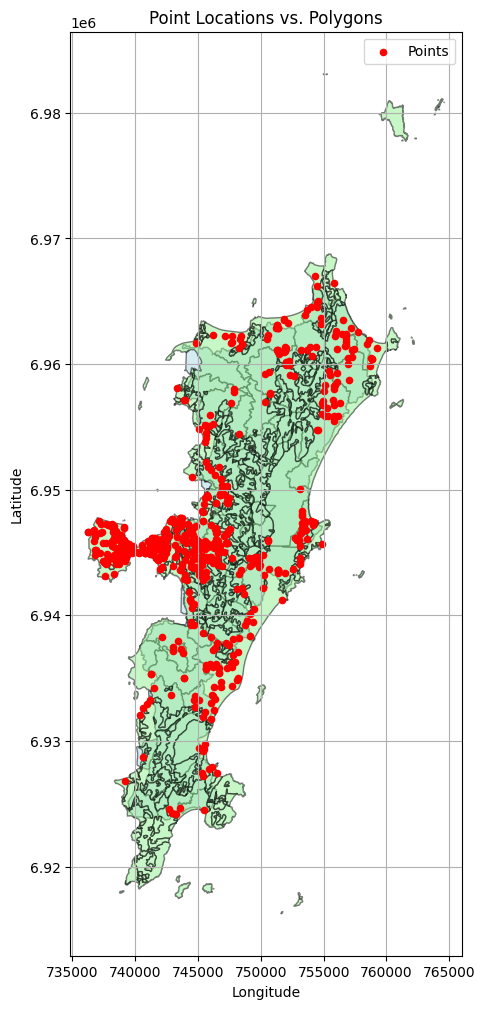

In [ ]:
import matplotlib.pyplot as plt

# Create a plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the polygons from SuscetibilidadeBacias
gdfs["SuscetibilidadeBacias"].plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5, label='Suscetibilidade Bacias')

# Plot the polygons from SuscetibilidadeMovimentoDeMassa_UHT
gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].plot(ax=ax, color='lightgreen', edgecolor='black', alpha=0.5, label='Movimento de Massa')

# Plot the points from dfFloripa
gdf_floripa.plot(ax=ax, color='red', markersize=20, label='Points')

# Add legend and title
plt.legend()
plt.title('Point Locations vs. Polygons')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()


In [ ]:
# Check for None values in the specified columns
none_bacias = dfFloripa['Classe_Bacias'].isnull().sum()
none_movimento = dfFloripa['Classe_Movimento'].isnull().sum()

print(f"Number of None values in Classe_Bacias: {none_bacias}")
print(f"Number of None values in Classe_Movimento: {none_movimento}")


Number of None values in Classe_Bacias: 281
Number of None values in Classe_Movimento: 6


In [ ]:
# Check bounds of polygons
for name, gdf in gdfs.items():
    print(f"{name} bounds: {gdf.total_bounds}")  # total_bounds gives (minx, miny, maxx, maxy)


SuscetibilidadeBacias bounds: [ 739437.9608 6923703.8849  758969.5254 6966103.9321]
SuscetibilidadeEnxurradas bounds: [ 739146.0229 6919248.8432  755286.3622 6960859.1618]
SuscetibilidadeInundacao bounds: [ 736265.1546 6918596.29    759402.0419 6967916.2603]
SuscetibilidadeMovimentoDeMassa bounds: [ 736265.15462608 6916250.19255499  764612.53492853 6983107.5289394 ]
SuscetibilidadeMovimentoDeMassa_UHT bounds: [ 736265.1546     6916250.19255499  764612.53492853 6983107.5289394 ]


In [ ]:
# Check overall data range
longitude_range = dfFloripa['lon_ocorrencia'].min(), dfFloripa['lon_ocorrencia'].max()
latitude_range = dfFloripa['lat_ocorrencia'].min(), dfFloripa['lat_ocorrencia'].max()

print(f"Longitude Range: {longitude_range}")
print(f"Latitude Range: {latitude_range}")


Longitude Range: (-48.6067123, -48.3770847)
Latitude Range: (-27.7849669, -27.3963472)


Projected_X

In [ ]:
from pyproj import Proj, transform

# Define the projection of your bounds and the WGS84 projection
wgs84 = Proj(init='epsg:4326')  # WGS84
projected = Proj(init='EPSG:32722')  # Replace XXXX with the appropriate EPSG code for your bounds

# Convert the coordinates
dfFloripa['Projected_X'], dfFloripa['Projected_Y'] = transform(wgs84, projected, dfFloripa['lon_ocorrencia'].values, dfFloripa['lat_ocorrencia'].values)

# Define the bounds for each classification in projected coordinates
bounds_bacias = [739437.9608, 6923703.8849, 758969.5254, 6966103.9321]
bounds_enxurradas = [739146.0229, 6919248.8432, 755286.3622, 6960859.1618]
bounds_inundacao = [736265.1546, 6918596.29, 759402.0419, 6967916.2603]
bounds_movimento_de_massa = [736265.15462608, 6916250.19255499, 764612.53492853, 6983107.5289394]
bounds_movimento_de_massa_uht = [736265.1546, 6916250.19255499, 764612.53492853, 6983107.5289394]

# Function to classify points
def classify_points(row):
    x, y = row['Projected_X'], row['Projected_Y']  # Use transformed coordinates if applicable
    if bounds_bacias[0] <= x <= bounds_bacias[2] and bounds_bacias[1] <= y <= bounds_bacias[3]:
        return 'SuscetibilidadeBacias'
    elif bounds_enxurradas[0] <= x <= bounds_enxurradas[2] and bounds_enxurradas[1] <= y <= bounds_enxurradas[3]:
        return 'SuscetibilidadeEnxurradas'
    elif bounds_inundacao[0] <= x <= bounds_inundacao[2] and bounds_inundacao[1] <= y <= bounds_inundacao[3]:
        return 'SuscetibilidadeInundacao'
    elif bounds_movimento_de_massa[0] <= x <= bounds_movimento_de_massa[2] and bounds_movimento_de_massa[1] <= y <= bounds_movimento_de_massa[3]:
        return 'SuscetibilidadeMovimentoDeMassa'
    elif bounds_movimento_de_massa_uht[0] <= x <= bounds_movimento_de_massa_uht[2] and bounds_movimento_de_massa_uht[1] <= y <= bounds_movimento_de_massa_uht[3]:
        return 'SuscetibilidadeMovimentoDeMassa_UHT'
    else:
        return None

# Apply the classification to the DataFrame
dfFloripa['Classe_Suscetibilidade'] = dfFloripa.apply(classify_points, axis=1)

# Check for unclassified points
unclassified = dfFloripa[dfFloripa['Classe_Suscetibilidade'].isnull()]
print("Unclassified points in Classe_Suscetibilidade:")
print(unclassified[['lon_ocorrencia', 'lat_ocorrencia']])
print("Number of None values in Classe_Suscetibilidade:", unclassified.shape[0])


Unclassified points in Classe_Suscetibilidade:
        lon_ocorrencia  lat_ocorrencia
233748      -48.606712       -27.58376
234105      -48.606712       -27.58376
Number of None values in Classe_Suscetibilidade: 2


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-113-e9e424bf33cc>:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  dfFloripa['Projected_X'], dfFloripa['Projected_Y']

In [ ]:
from pyproj import Proj, transform

# Define the projection of your bounds and the WGS84 projection
wgs84 = Proj(init='epsg:4326')  # WGS84
projected = Proj(init='EPSG:32722')  # Replace XXXX with the appropriate EPSG code for your bounds

# Convert the coordinates
df4['Projected_X'], df4['Projected_Y'] = transform(wgs84, projected, df4['lon_ocorrencia'].values, df4['lat_ocorrencia'].values)

# Define the bounds for each classification in projected coordinates
bounds_bacias = [739437.9608, 6923703.8849, 758969.5254, 6966103.9321]
bounds_enxurradas = [739146.0229, 6919248.8432, 755286.3622, 6960859.1618]
bounds_inundacao = [736265.1546, 6918596.29, 759402.0419, 6967916.2603]
bounds_movimento_de_massa = [736265.15462608, 6916250.19255499, 764612.53492853, 6983107.5289394]
bounds_movimento_de_massa_uht = [736265.1546, 6916250.19255499, 764612.53492853, 6983107.5289394]

# Function to classify points
def classify_points(row):
    x, y = row['Projected_X'], row['Projected_Y']  # Use transformed coordinates if applicable
    if bounds_bacias[0] <= x <= bounds_bacias[2] and bounds_bacias[1] <= y <= bounds_bacias[3]:
        return 'SuscetibilidadeBacias'
    elif bounds_enxurradas[0] <= x <= bounds_enxurradas[2] and bounds_enxurradas[1] <= y <= bounds_enxurradas[3]:
        return 'SuscetibilidadeEnxurradas'
    elif bounds_inundacao[0] <= x <= bounds_inundacao[2] and bounds_inundacao[1] <= y <= bounds_inundacao[3]:
        return 'SuscetibilidadeInundacao'
    elif bounds_movimento_de_massa[0] <= x <= bounds_movimento_de_massa[2] and bounds_movimento_de_massa[1] <= y <= bounds_movimento_de_massa[3]:
        return 'SuscetibilidadeMovimentoDeMassa'
    elif bounds_movimento_de_massa_uht[0] <= x <= bounds_movimento_de_massa_uht[2] and bounds_movimento_de_massa_uht[1] <= y <= bounds_movimento_de_massa_uht[3]:
        return 'SuscetibilidadeMovimentoDeMassa_UHT'
    else:
        return None

# Apply the classification to the DataFrame
df4['Classe_Suscetibilidade'] = df4.apply(classify_points, axis=1)

# Check for unclassified points
unclassified = df4[df4['Classe_Suscetibilidade'].isnull()]
print("Unclassified points in Classe_Suscetibilidade:")
print(unclassified[['lon_ocorrencia', 'lat_ocorrencia']])
print("Number of None values in Classe_Suscetibilidade:", unclassified.shape[0])


Unclassified points in Classe_Suscetibilidade:
     lon_ocorrencia  lat_ocorrencia
100      -48.606712       -27.58376
96       -48.606712       -27.58376
Number of None values in Classe_Suscetibilidade: 2


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-138-a354b485c9a0>:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  df4['Projected_X'], df4['Projected_Y'] = transform

In [ ]:
# Transform dfFloripa to match the CRS of SuscetibilidadeBacias
gdf_floripa = gdf_floripa.to_crs(epsg=32722)

# Initialize empty columns for Classe
dfFloripa['Classe_Bacias'] = None
dfFloripa['Classe_Movimento'] = None

# Classify points based on SuscetibilidadeBacias
for index, row in gdfs["SuscetibilidadeBacias"].iterrows():
    polygon = row.geometry
    classe = row['CLASSE']  # Adjust if the column name is different

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    # Print how many points were found within the polygon
    if condition.any():
        print(f"Found {condition.sum()} points in {classe}")

    # Assign the Classe value to dfFloripa based on the condition
    dfFloripa.loc[condition, 'Classe_Bacias'] = classe

# Classify points based on SuscetibilidadeMovimentoDeMassa_UHT
for index, row in gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].iterrows():
    polygon = row.geometry
    classe = row['Classe']  # Adjust if the column name is different

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    # Print how many points were found within the polygon
    if condition.any():
        print(f"Found {condition.sum()} points in {classe}")

    # Assign the Classe value to dfFloripa based on the condition
    dfFloripa.loc[condition, 'Classe_Movimento'] = classe

# Now, we will project the coordinates to the defined CRS
from pyproj import Proj, transform

# Define the projection of your bounds and the WGS84 projection
wgs84 = Proj(init='epsg:4326')  # WGS84
projected = Proj(init='EPSG:32722')  # Replace XXXX with the appropriate EPSG code for your bounds

# Convert the coordinates
dfFloripa['Projected_X'], dfFloripa['Projected_Y'] = transform(wgs84, projected, dfFloripa['lon_ocorrencia'].values, dfFloripa['lat_ocorrencia'].values)

# Define the bounds for each classification in projected coordinates
bounds_bacias = [739437.9608, 6923703.8849, 758969.5254, 6966103.9321]
bounds_enxurradas = [739146.0229, 6919248.8432, 755286.3622, 6960859.1618]
bounds_inundacao = [736265.1546, 6918596.29, 759402.0419, 6967916.2603]
bounds_movimento_de_massa = [736265.15462608, 6916250.19255499, 764612.53492853, 6983107.5289394]
bounds_movimento_de_massa_uht = [736265.1546, 6916250.19255499, 764612.53492853, 6983107.5289394]

# Function to classify points based on bounds
def classify_bounds(row):
    x, y = row['Projected_X'], row['Projected_Y']  # Use transformed coordinates
    if bounds_bacias[0] <= x <= bounds_bacias[2] and bounds_bacias[1] <= y <= bounds_bacias[3]:
        return 'SuscetibilidadeBacias'
    elif bounds_enxurradas[0] <= x <= bounds_enxurradas[2] and bounds_enxurradas[1] <= y <= bounds_enxurradas[3]:
        return 'SuscetibilidadeEnxurradas'
    elif bounds_inundacao[0] <= x <= bounds_inundacao[2] and bounds_inundacao[1] <= y <= bounds_inundacao[3]:
        return 'SuscetibilidadeInundacao'
    elif bounds_movimento_de_massa[0] <= x <= bounds_movimento_de_massa[2] and bounds_movimento_de_massa[1] <= y <= bounds_movimento_de_massa[3]:
        return 'SuscetibilidadeMovimentoDeMassa'
    elif bounds_movimento_de_massa_uht[0] <= x <= bounds_movimento_de_massa_uht[2] and bounds_movimento_de_massa_uht[1] <= y <= bounds_movimento_de_massa_uht[3]:
        return 'SuscetibilidadeMovimentoDeMassa_UHT'
    else:
        return None

# Apply the bounds classification to the DataFrame
dfFloripa['Classe_Suscetibilidade'] = dfFloripa.apply(classify_bounds, axis=1)

# Check for unclassified points
unclassified = dfFloripa[dfFloripa['Classe_Suscetibilidade'].isnull()]
print("Unclassified points in Classe_Suscetibilidade:")
print(unclassified[['lon_ocorrencia', 'lat_ocorrencia']])
print("Number of None values in Classe_Suscetibilidade:", unclassified.shape[0])

# Display the updated dfFloripa
print(dfFloripa[['lat_ocorrencia', 'lon_ocorrencia', 'Classe_Bacias', 'Classe_Movimento', 'Classe_Suscetibilidade']])


Found 7 points in Baixa
Found 14 points in Alta
Found 5 points in Media
Found 2 points in Baixa
Found 7 points in Media
Found 7 points in Media
Found 4 points in Media
Found 11 points in Alta
Found 9 points in Alta
Found 1 points in Baixa
Found 1 points in Media
Found 24 points in Alta
Found 1 points in Alta
Found 1 points in Baixa
Found 8 points in Alta
Found 16 points in Media
Found 13 points in Baixa
Found 2 points in Media
Found 20 points in Alta
Found 29 points in Baixa
Found 10 points in Baixa
Found 22 points in Baixa
Found 2 points in Media
Found 55 points in Alta
Found 17 points in Baixa
Found 6 points in Baixa
Found 3 points in Baixa
Found 5 points in Media
Found 3 points in Baixa
Found 4 points in Alta
Found 2 points in Baixa
Found 12 points in Alta
Found 2 points in Alta
Found 10 points in Alta
Found 2 points in Alta
Found 4 points in Alta
Found 1 points in Media
Found 3 points in Alta
Found 1 points in Baixa
Found 2 points in Alta
Found 1 points in Alta
Found 4 points in Al

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-110-38672cda8f87>:46: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  dfFloripa['Projected_X'], dfFloripa['Projected_Y'

In [ ]:
# Transform dfFloripa to match the CRS of SuscetibilidadeBacias
gdf_floripa = gdf_floripa.to_crs(epsg=32722)

# Initialize empty columns for Classe
dfFloripa['Classe_Bacias'] = None
dfFloripa['Classe_Movimento'] = None

# Classify points based on SuscetibilidadeBacias
for index, row in gdfs["SuscetibilidadeBacias"].iterrows():
    polygon = row.geometry
    classe = row['CLASSE']  # Column name in SuscetibilidadeBacias

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    if condition.any():
        print(f"Found {condition.sum()} points in {classe}")

    # Assign the Classe value to dfFloripa based on the condition
    dfFloripa.loc[condition, 'Classe_Bacias'] = classe

# Classify points based on SuscetibilidadeMovimentoDeMassa_UHT
for index, row in gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].iterrows():
    polygon = row.geometry
    classe = row['Classe']  # Column name in SuscetibilidadeMovimentoDeMassa_UHT

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    if condition.any():
        print(f"Found {condition.sum()} points in {classe}")

    # Assign the Classe value to dfFloripa based on the condition
    dfFloripa.loc[condition, 'Classe_Movimento'] = classe

# Function to fill None values with the closest CLASSE based on coordinates
def fill_closest_class(row):
    if pd.isnull(row['Classe_Bacias']):
        # Find the nearest polygon from SuscetibilidadeBacias
        nearest_polygon = gdfs["SuscetibilidadeBacias"].geometry.union_all()  # Changed here
        point = Point(row['Projected_X'], row['Projected_Y'])
        closest_dist = nearest_polygon.distance(point)

        if closest_dist < 100:  # Set a threshold distance if necessary
            return gdfs["SuscetibilidadeBacias"].loc[gdfs["SuscetibilidadeBacias"].geometry.distance(point).idxmin()]['CLASSE']

    if pd.isnull(row['Classe_Movimento']):
        # Find the nearest polygon from SuscetibilidadeMovimentoDeMassa_UHT
        nearest_polygon = gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].geometry.union_all()  # Changed here
        point = Point(row['Projected_X'], row['Projected_Y'])
        closest_dist = nearest_polygon.distance(point)

        if closest_dist < 100:  # Set a threshold distance if necessary
            return gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].loc[gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].geometry.distance(point).idxmin()]['Classe']

    return None  # Return None if no class is found

# Apply the function to fill in None values
dfFloripa['Classe_Bacias'] = dfFloripa.apply(fill_closest_class, axis=1)

# Display the updated dfFloripa
print(dfFloripa[['lat_ocorrencia', 'lon_ocorrencia', 'Classe_Bacias', 'Classe_Movimento']])


Found 7 points in Baixa
Found 14 points in Alta
Found 5 points in Media
Found 2 points in Baixa
Found 7 points in Media
Found 7 points in Media
Found 4 points in Media
Found 11 points in Alta
Found 9 points in Alta
Found 1 points in Baixa
Found 1 points in Media
Found 24 points in Alta
Found 1 points in Alta
Found 1 points in Baixa
Found 8 points in Alta
Found 16 points in Media
Found 13 points in Baixa
Found 2 points in Media
Found 20 points in Alta
Found 29 points in Baixa
Found 10 points in Baixa
Found 22 points in Baixa
Found 2 points in Media
Found 55 points in Alta
Found 17 points in Baixa
Found 6 points in Baixa
Found 3 points in Baixa
Found 5 points in Media
Found 3 points in Baixa
Found 4 points in Alta
Found 2 points in Baixa
Found 12 points in Alta
Found 2 points in Alta
Found 10 points in Alta
Found 2 points in Alta
Found 4 points in Alta
Found 1 points in Media
Found 3 points in Alta
Found 1 points in Baixa
Found 2 points in Alta
Found 1 points in Alta
Found 4 points in Al

In [ ]:
dfFloripa

id_ocorrencia         cidade  populacao              horario  \
1729          10077086  Florianópolis     500973  2017-08-03 04:00:00   
1852          10083288  Florianópolis     500973  2017-11-24 12:38:00   
1853          10082420  Florianópolis     500973  2017-11-09 15:46:00   
1855          10082354  Florianópolis     500973  2017-11-08 18:55:00   
4437          10068370  Florianópolis     500973  2017-03-04 21:53:00   
...                ...            ...        ...                  ...   
1767958       10137822  Florianópolis     500973  2021-01-13 08:36:44   
1768099       10137648  Florianópolis     500973  2021-01-09 14:54:18   
1768438       10137748  Florianópolis     500973  2021-01-11 16:09:36   
1768557       10137866  Florianópolis     500973  2021-01-14 13:31:02   
1768937       10137885  Florianópolis     500973  2021-01-14 19:55:21   

              vtr          mtcl militar_bc  bc_indenizado  \
1729       AR-118  9.213031e+06    Militar          False   
1852     ABTR-116  9.305165e+06    Militar          False   
1853     ABTR-116  9.232818e+06    Militar          False   
1855     ABTR-116  9.184430e+06    Militar          False   
4437      ABT-059  9.232818e+06    Militar          False   
...           ...           ...        ...            ...   
1767958   ABS-006  6.100104e+06    Militar          False   
1768099   ABS-006  9.993541e+06    Militar          False   
1768438   ABTR-66  6.118397e+10         BC           True   
1768557  ABTR-140  6.098100e+06    Militar          False   
1768937   ABTR-66  6.099084e+06    Militar          False   

                                               obm             coordenada_obm  \
1729                                        1|8105                     1|8105   
1852                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1853                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1855                  2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
4437                            1º/2ª/1º BBM - GBS  [-48.5630772,-27.5922913]   
...                                            ...                        ...   
1767958  2ºGBM/2ªPEL/2ªCBM/1º BBM - BARRA DA LAGOA  [-48.4333134,-27.5749765]   
1768099  2ºGBM/2ªPEL/2ªCBM/1º BBM - BARRA DA LAGOA  [-48.4333134,-27.5749765]   
1768438               2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1768557      1ºGBM/1ºPEL/1ªCBM/1ºBBM - RIO TAVARES  [-48.5046816,-27.6696182]   
1768937               2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   

         ...      Time Hour  Year  Month  Day Classe_Bacias Classe_Movimento  \
1729     ...  04:00:00    4  2017      8    3          None            Baixa   
1852     ...  12:38:00   12  2017     11   24          None            Baixa   
1853     ...  15:46:00   15  2017     11    9          None            Baixa   
1855     ...  18:55:00   18  2017     11    8          None            Baixa   
4437     ...  21:53:00   21  2017      3    4          None             Alta   
...      ...       ...  ...   ...    ...  ...           ...              ...   
1767958  ...  08:36:44    8  2021      1   13          None            Baixa   
1768099  ...  14:54:18   14  2021      1    9          None            Baixa   
1768438  ...  16:09:36   16  2021      1   11          None            Baixa   
1768557  ...  13:31:02   13  2021      1   14          None            Baixa   
1768937  ...  19:55:21   19  2021      1   14          None            Baixa   

           Projected_X   Projected_Y  Classe_Suscetibilidade  
1729     757213.262637  6.962861e+06   SuscetibilidadeBacias  
1852     743985.017417  6.943245e+06   SuscetibilidadeBacias  
1853     741251.632246  6.935365e+06   SuscetibilidadeBacias  
1855     745303.396908  6.948321e+06   SuscetibilidadeBacias  
4437     743182.338724  6.945630e+06   SuscetibilidadeBacias  
...                ...           ...                     ...  
1767958  756773.798746  

array(['Baixa', 'Alta', 'Media', None], dtype=object)

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Define the point coordinates
point_coords = [-48.527746, -27.612825]

# Create a Point object
point = Point(point_coords[0], point_coords[1])

# Load the SuscetibilidadeBacias GeoDataFrame (assuming it's already loaded as gdfs["SuscetibilidadeBacias"])
suscetibilidade_bacias = gdfs["SuscetibilidadeBacias"]

# Initialize a variable to store the found class
found_class = None

# Check which polygon contains the point
for index, row in suscetibilidade_bacias.iterrows():
    if point.within(row.geometry):
        found_class = row['CLASSE']  # Adjust column name if necessary
        break

# Output the found class
if found_class:
    print(f"The CLASSE for the point {point_coords} is: {found_class}")
else:
    print(f"The point {point_coords} is not within any polygon in SuscetibilidadeBacias.")


The point [-48.527746, -27.612825] is not within any polygon in SuscetibilidadeBacias.


In [ ]:
# Check the CRS of SuscetibilidadeBacias
print("CRS of SuscetibilidadeBacias:", suscetibilidade_bacias.crs)

# Define the WGS84 projection (EPSG:4326) for your point
wgs84 = gpd.GeoSeries([Point(point_coords[0], point_coords[1])], crs='EPSG:4326')

# Transform the point to the CRS of SuscetibilidadeBacias
point_transformed = wgs84.to_crs(suscetibilidade_bacias.crs).geometry[0]

# Check the transformed point
print("Transformed Point:", point_transformed)


CRS of SuscetibilidadeBacias: EPSG:32722
Transformed Point: POINT (743985.0068793705 6943245.0331201665)


In [ ]:
# Check if the transformed point is within any polygon
is_within = suscetibilidade_bacias['geometry'].contains(point_transformed)

# Filter the polygons where the point is contained
contained_polygons = suscetibilidade_bacias[is_within]

# Check if any polygons were found
if not contained_polygons.empty:
    print("The point is within the following polygon(s):")
    print(contained_polygons[['CLASSE', 'geometry']])
else:
    print("The point is not within any polygon in SuscetibilidadeBacias.")


The point is not within any polygon in SuscetibilidadeBacias.


In [ ]:
# Classify points based on SuscetibilidadeBacias
for index, row in gdfs["SuscetibilidadeBacias"].iterrows():
    polygon = row.geometry
    classe = row['CLASSE']

    condition = gdf_floripa.geometry.within(polygon)
    print(f"Found {condition.sum()} points in {classe}")

    dfFloripa.loc[condition, 'Classe_Bacias'] = classe

# Print points that remain unclassified
remaining_none_bacias = dfFloripa[dfFloripa['Classe_Bacias'].isnull()]
print("Remaining None in Classe_Bacias:", remaining_none_bacias[['lon_ocorrencia', 'lat_ocorrencia']])


Found 7 points in Baixa
Found 14 points in Alta
Found 5 points in Media
Found 2 points in Baixa
Found 7 points in Media
Found 0 points in Alta
Found 0 points in Media
Found 0 points in Media
Found 7 points in Media
Found 4 points in Media
Found 11 points in Alta
Found 9 points in Alta
Found 1 points in Baixa
Found 0 points in Baixa
Found 1 points in Media
Found 24 points in Alta
Found 0 points in Media
Found 1 points in Alta
Found 1 points in Baixa
Found 8 points in Alta
Found 0 points in Baixa
Found 16 points in Media
Found 13 points in Baixa
Found 2 points in Media
Found 20 points in Alta
Found 29 points in Baixa
Found 10 points in Baixa
Found 22 points in Baixa
Found 2 points in Media
Found 55 points in Alta
Found 17 points in Baixa
Found 6 points in Baixa
Found 3 points in Baixa
Found 5 points in Media
Found 3 points in Baixa
Found 4 points in Alta
Found 0 points in Baixa
Found 2 points in Baixa
Found 12 points in Alta
Found 2 points in Alta
Found 10 points in Alta
Found 2 points i

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Step 1: Create a GeoDataFrame from dfFloripa
geometry = [Point(xy) for xy in zip(dfFloripa['lon_ocorrencia'], dfFloripa['lat_ocorrencia'])]
gdf_floripa = gpd.GeoDataFrame(dfFloripa, geometry=geometry)

# Step 2: Set the CRS of gdf_floripa to WGS84 (EPSG:4326)
gdf_floripa.crs = 'EPSG:4326'

# Step 3: Transform gdf_floripa to the CRS of SuscetibilidadeBacias (EPSG:32722)
gdf_floripa = gdf_floripa.to_crs(epsg=32722)

# After transforming, initialize empty columns for Classe
gdf_floripa['Classe_Bacias'] = None
gdf_floripa['Classe_Movimento'] = None

# Classify points based on SuscetibilidadeBacias
for index, row in gdfs["SuscetibilidadeBacias"].iterrows():
    polygon = row.geometry
    classe = row['CLASSE']  # Adjust if the column name is different

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    # Print how many points were found within the polygon
    if condition.any():
        print(f"Found {condition.sum()} points in {classe}")

    # Assign the Classe value to gdf_floripa based on the condition
    gdf_floripa.loc[condition, 'Classe_Bacias'] = classe

# Classify points based on SuscetibilidadeMovimentoDeMassa_UHT
for index, row in gdfs["SuscetibilidadeMovimentoDeMassa_UHT"].iterrows():
    polygon = row.geometry
    classe = row['Classe']  # Adjust if the column name is different

    # Check if any point in gdf_floripa is contained in the polygon
    condition = gdf_floripa.geometry.within(polygon)

    # Print how many points were found within the polygon
    if condition.any():
        print(f"Found {condition.sum()} points in {classe}")

    # Assign the Classe value to gdf_floripa based on the condition
    gdf_floripa.loc[condition, 'Classe_Movimento'] = classe

# Display the updated gdf_floripa
print(gdf_floripa[['lat_ocorrencia', 'lon_ocorrencia', 'Classe_Bacias', 'Classe_Movimento']])


Found 7 points in Baixa
Found 14 points in Alta
Found 5 points in Media
Found 2 points in Baixa
Found 7 points in Media
Found 7 points in Media
Found 4 points in Media
Found 11 points in Alta
Found 9 points in Alta
Found 1 points in Baixa
Found 1 points in Media
Found 24 points in Alta
Found 1 points in Alta
Found 1 points in Baixa
Found 8 points in Alta
Found 16 points in Media
Found 13 points in Baixa
Found 2 points in Media
Found 20 points in Alta
Found 29 points in Baixa
Found 10 points in Baixa
Found 22 points in Baixa
Found 2 points in Media
Found 55 points in Alta
Found 17 points in Baixa
Found 6 points in Baixa
Found 3 points in Baixa
Found 5 points in Media
Found 3 points in Baixa
Found 4 points in Alta
Found 2 points in Baixa
Found 12 points in Alta
Found 2 points in Alta
Found 10 points in Alta
Found 2 points in Alta
Found 4 points in Alta
Found 1 points in Media
Found 3 points in Alta
Found 1 points in Baixa
Found 2 points in Alta
Found 1 points in Alta
Found 4 points in Al

In [ ]:
# prompt: count the numbers of None in Classe_Bacias on dfFloripa and Classe_Movimento on dfFloripa

print(f"Number of None values in Classe_Bacias: {dfFloripa['Classe_Bacias'].isnull().sum()}")
print(f"Number of None values in Classe_Movimento: {dfFloripa['Classe_Movimento'].isnull().sum()}")

Number of None values in Classe_Bacias: 281
Number of None values in Classe_Movimento: 6


In [ ]:
# Inspect points that remain unclassified
unclassified_bacias = dfFloripa[dfFloripa['Classe_Bacias'].isnull()]
print("Unclassified Points in Classe_Bacias:")
print("Longitude:")
print(unclassified_bacias.lon_ocorrencia.unique())
print("Latitude:")
print(unclassified_bacias.lat_ocorrencia.unique())

unclassified_movimento = dfFloripa[dfFloripa['Classe_Movimento'].isnull()]
print("Unclassified Points in Classe_Movimento:")
print("Longitude:")
print(unclassified_movimento.lon_ocorrencia.unique())
print("Latitude:")
print(unclassified_movimento.lat_ocorrencia.unique())


Unclassified Points in Classe_Bacias:
Longitude:
[-48.5277459 -48.5538404 -48.51543   -48.5363546 -48.5139119 -48.5340918
 -48.5696736 -48.5311533 -48.5632686 -48.4582115 -48.5436511 -48.5757954
 -48.5835667 -48.5931399 -48.5899608 -48.5355576 -48.5441324 -48.5762385
 -48.6014925 -48.5839269 -48.5924469 -48.6001666 -48.5776927 -48.5853746
 -48.5530687 -48.4936707 -48.5374086 -48.4771011 -48.4724789 -48.5538778
 -48.5602189 -48.5779514 -48.5465068 -48.5953288 -48.43532   -48.5459986
 -48.5790355 -48.5866986 -48.5832957 -48.5564931 -48.5476194 -48.5474441
 -48.5323173 -48.417974  -48.5384885 -48.5507819 -48.5316687 -48.5442077
 -48.5745796 -48.3809261 -48.5912918 -48.6067123 -48.5752652 -48.5558738
 -48.5967439 -48.586714  -48.5855602 -48.5143879 -48.4524168 -48.5750456
 -48.5598956 -48.5881224 -48.5874423 -48.5504475 -48.4878343 -48.4490173
 -48.5811352 -48.5871638 -48.5906689 -48.5818085 -48.5918893 -48.6005301
 -48.4746649 -48.5971662 -48.594923  -48.5452335 -48.5932098 -48.549766
 -4

Plots dos dados

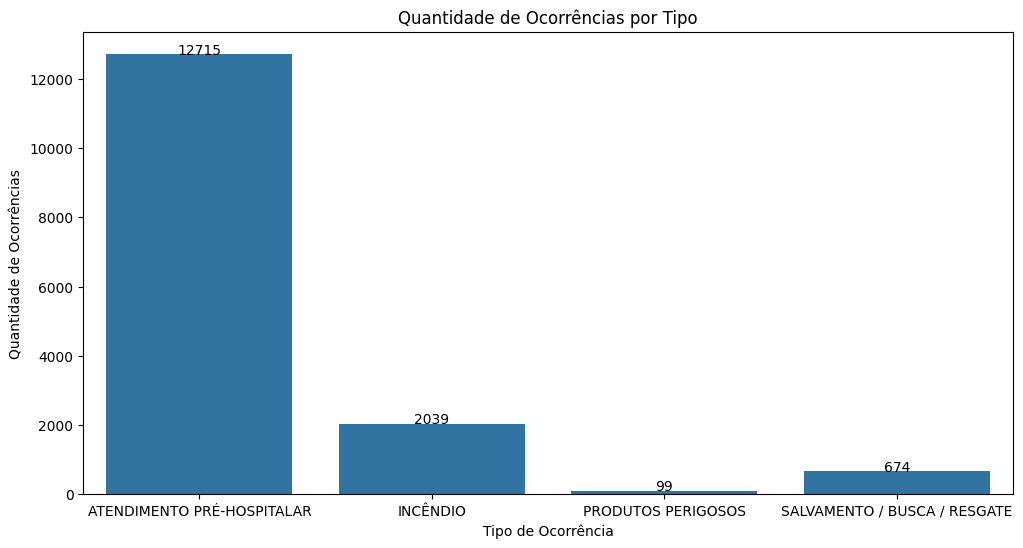

In [ ]:
df_grouped = dfFloripa.groupby('tipo')['id_ocorrencia'].count().reset_index(name='count')

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='tipo', y='count', data=df_grouped)

# Annotate bars with counts
for index, row in df_grouped.iterrows():
    ax.text(index, row['count'], str(row['count']), color='black', ha="center")

# Set title and labels
plt.xlabel('Tipo de Ocorrência')
plt.ylabel('Quantidade de Ocorrências')
plt.title('Quantidade de Ocorrências por Tipo')

# Show the plot
plt.show()

In [ ]:
dfFloripa['regiao'] = np.select(
    [
        (dfFloripa['lon_ocorrencia'] >= -48.629) & (dfFloripa['lon_ocorrencia'] <= -48.5) & (dfFloripa['lat_ocorrencia'] >= -27.65) & (dfFloripa['lat_ocorrencia'] <= -27.52),
        (dfFloripa['lon_ocorrencia'] > -48.6) & (dfFloripa['lon_ocorrencia'] <= -48.45) & (dfFloripa['lat_ocorrencia'] >= -27.9) & (dfFloripa['lat_ocorrencia'] < -27.65),
        (dfFloripa['lon_ocorrencia'] > -48.5) & (dfFloripa['lon_ocorrencia'] <= -48.35) & (dfFloripa['lat_ocorrencia'] >= -27.65) & (dfFloripa['lat_ocorrencia'] <= -27.45),
        ((dfFloripa['lon_ocorrencia'] > -48.55) & (dfFloripa['lon_ocorrencia'] <= -48.45) & (dfFloripa['lat_ocorrencia'] > -27.52) & (dfFloripa['lat_ocorrencia'] <= -27.3)) |
         ((dfFloripa['lon_ocorrencia'] > -48.45) & (dfFloripa['lon_ocorrencia'] <= -48.35) & (dfFloripa['lat_ocorrencia'] >= -27.45) & (dfFloripa['lat_ocorrencia'] <= -27.3))
    ],
    [
        0,
        1,
        2,
        3
    ],
    default=np.nan
)


In [ ]:
df_grouped = dfFloripa.groupby('regiao')['id_ocorrencia'].count().reset_index(name='count')

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='regiao', y='count', data=df_grouped)

# Annotate bars with counts
for index, row in df_grouped.iterrows():
    ax.text(index, row['count'], str(row['count']), color='black', ha="center")

# Set title and labels
plt.xlabel('Regiões')
plt.ylabel('Quantidade de Ocorrências')
plt.title('Quantidade de Ocorrências por Região')

# Show the plot
plt.show()

NameError: name 'dfFloripa' is not defined

In [53]:
dfFloripa['Quantity'] = dfFloripa.groupby(['Year','Month', 'Day']).transform('size')


In [ ]:
df['Quantity'] = df.groupby(['Year','Month','Day']).transform('size')

In [54]:
dfFloripa

id_ocorrencia         cidade  populacao              horario  \
1723          10064986        Palhoça     171797  2017-01-13 16:16:00   
1729          10077086  Florianópolis     500973  2017-08-03 04:00:00   
1852          10083288  Florianópolis     500973  2017-11-24 12:38:00   
1853          10082420  Florianópolis     500973  2017-11-09 15:46:00   
1855          10082354  Florianópolis     500973  2017-11-08 18:55:00   
...                ...            ...        ...                  ...   
1768557       10137866  Florianópolis     500973  2021-01-14 13:31:02   
1768937       10137885  Florianópolis     500973  2021-01-14 19:55:21   
1849930       55053189           Taió      18395  2020-12-24 15:49:15   
1918592       80114726       Garopaba      23078  2020-11-07 11:30:54   
1925696       80117292       Garopaba      23078  2021-01-05 14:57:03   

              vtr          mtcl militar_bc  bc_indenizado  \
1723     ABTR-043  9.228098e+06    Militar          False   
1729       AR-118  9.213031e+06    Militar          False   
1852     ABTR-116  9.305165e+06    Militar          False   
1853     ABTR-116  9.232818e+06    Militar          False   
1855     ABTR-116  9.184430e+06    Militar          False   
...           ...           ...        ...            ...   
1768557  ABTR-140  6.098100e+06    Militar          False   
1768937   ABTR-66  6.099084e+06    Militar          False   
1849930   ASU-458  5.805209e+09         BC           True   
1918592  ABTR-050  5.491100e+09         BC           True   
1925696  ABTR-050  9.318666e+06    Militar          False   

                                           obm             coordenada_obm  \
1723                      2ª/10º BBM - PALHOÇA  [-48.6689615,-27.6478757]   
1729                                    1|8105                     1|8105   
1852              2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1853              2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1855              2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
...                                        ...                        ...   
1768557  1ºGBM/1ºPEL/1ªCBM/1ºBBM - RIO TAVARES  [-48.5046816,-27.6696182]   
1768937           2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1849930                    TAIÓ - 1º/2ª/15ºBBM                        NaN   
1918592                3º/2ª/8º BBM - GAROPABA    [-48.642016,-28.049871]   
1925696                3º/2ª/8º BBM - GAROPABA    [-48.642016,-28.049871]   

         ...  firecast origem_samu       vitima       Dates      Time Hour  \
1723     ...      True         NaN         <NA>  2017-01-13  16:16:00   16   
1729     ...      True         NaN         <NA>  2017-08-03  04:00:00    4   
1852     ...      True         NaN         <NA>  2017-11-24  12:38:00   12   
1853     ...      True         NaN         <NA>  2017-11-09  15:46:00   15   
1855     ...      True         NaN         <NA>  2017-11-08  18:55:00   18   
...      ...       ...         ...          ...         ...       ...  ...   
1768557  ...      True         NaN         <NA>  2021-01-14  13:31:02   13   
1768937  ...      True         NaN         <NA>  2021-01-14  19:55:21   19   
1849930  ...      True         NaN  RSL2020|718  2020-12-24  15:49:15   15   
1918592  ...     False         NaN         <NA>  2020-11-07  11:30:54   11   
1925696  ...     False         NaN         <NA>  2021-01-05  14:57:03   14   

         Year Month Day  Quantity  
1723     2017     1  13         1  
1729     2017     8   3         3  
1852     2017    11  24         1  
1853     2017    11   9         1  
1855     2017    11   8         4  
...       ...   ...  ..       ...  
1768557  2021     1  14         4  
1768937  2021     1  14         4  
1849930  2020    12  24         2  
1918592  2020    11   7         2  
1925696  2021     1   5         2  

[708 rows x 29 columns]

In [57]:
dfCopy['Quantity'] = dfCopy.groupby(['Year','Month', 'Day']).transform('size')


In [59]:
dfFloripa

id_ocorrencia         cidade  populacao              horario  \
1723          10064986        Palhoça     171797  2017-01-13 16:16:00   
1729          10077086  Florianópolis     500973  2017-08-03 04:00:00   
1852          10083288  Florianópolis     500973  2017-11-24 12:38:00   
1853          10082420  Florianópolis     500973  2017-11-09 15:46:00   
1855          10082354  Florianópolis     500973  2017-11-08 18:55:00   
...                ...            ...        ...                  ...   
1768557       10137866  Florianópolis     500973  2021-01-14 13:31:02   
1768937       10137885  Florianópolis     500973  2021-01-14 19:55:21   
1849930       55053189           Taió      18395  2020-12-24 15:49:15   
1918592       80114726       Garopaba      23078  2020-11-07 11:30:54   
1925696       80117292       Garopaba      23078  2021-01-05 14:57:03   

              vtr          mtcl militar_bc  bc_indenizado  \
1723     ABTR-043  9.228098e+06    Militar          False   
1729       AR-118  9.213031e+06    Militar          False   
1852     ABTR-116  9.305165e+06    Militar          False   
1853     ABTR-116  9.232818e+06    Militar          False   
1855     ABTR-116  9.184430e+06    Militar          False   
...           ...           ...        ...            ...   
1768557  ABTR-140  6.098100e+06    Militar          False   
1768937   ABTR-66  6.099084e+06    Militar          False   
1849930   ASU-458  5.805209e+09         BC           True   
1918592  ABTR-050  5.491100e+09         BC           True   
1925696  ABTR-050  9.318666e+06    Militar          False   

                                           obm             coordenada_obm  \
1723                      2ª/10º BBM - PALHOÇA  [-48.6689615,-27.6478757]   
1729                                    1|8105                     1|8105   
1852              2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1853              2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1855              2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
...                                        ...                        ...   
1768557  1ºGBM/1ºPEL/1ªCBM/1ºBBM - RIO TAVARES  [-48.5046816,-27.6696182]   
1768937           2ºPEL/2ªCBM/1ºBBM - TRINDADE  [-48.5200024,-27.5876052]   
1849930                    TAIÓ - 1º/2ª/15ºBBM                        NaN   
1918592                3º/2ª/8º BBM - GAROPABA    [-48.642016,-28.049871]   
1925696                3º/2ª/8º BBM - GAROPABA    [-48.642016,-28.049871]   

         ...  origem_samu       vitima       Dates      Time  Hour  Year  \
1723     ...          NaN         <NA>  2017-01-13  16:16:00    16  2017   
1729     ...          NaN         <NA>  2017-08-03  04:00:00     4  2017   
1852     ...          NaN         <NA>  2017-11-24  12:38:00    12  2017   
1853     ...          NaN         <NA>  2017-11-09  15:46:00    15  2017   
1855     ...          NaN         <NA>  2017-11-08  18:55:00    18  2017   
...      ...          ...          ...         ...       ...   ...   ...   
1768557  ...          NaN         <NA>  2021-01-14  13:31:02    13  2021   
1768937  ...          NaN         <NA>  2021-01-14  19:55:21    19  2021   
1849930  ...          NaN  RSL2020|718  2020-12-24  15:49:15    15  2020   
1918592  ...          NaN         <NA>  2020-11-07  11:30:54    11  2020   
1925696  ...          NaN         <NA>  2021-01-05  14:57:03    14  2021   

        Month Day Quantity  Quantity_diff  
1723        1  13        1            NaN  
1729        8   3        3            2.0  
1852       11  24        1           -2.0  
1853       11   9        1            0.0  
1855       11   8        4            3.0  
...       ...  ..      ...            ...  
1768557     1  14        4            3.0  
1768937     1  14        4            0.0  
1849930    12  24        2           -2.0  
1918592    11   7        2            0.0  
1925696     1   5        2            0.0  

[708 rows x 30 columns]

In [58]:
dfCopy

id_ocorrencia  lat_ocorrencia  lon_ocorrencia  \
1723          10064986      -27.892733      -48.593615   
1729          10077086      -27.433461      -48.397987   
1852          10083288      -27.612825      -48.527746   
1853          10082420      -27.684391      -48.553840   
1855          10082354      -27.566806      -48.515430   
...                ...             ...             ...   
1768557       10137866      -27.676447      -48.501797   
1768937       10137885      -27.593763      -48.573022   
1849930       55053189      -27.494454      -48.505469   
1918592       80114726      -28.038678      -48.608327   
1925696       80117292      -28.038678      -48.608327   

                                 tipo                   subtipo       Dates  \
1723     SALVAMENTO / BUSCA / RESGATE                       NaN  2017-01-13   
1729     SALVAMENTO / BUSCA / RESGATE            COLISÃO/CHOQUE  2017-08-03   
1852     SALVAMENTO / BUSCA / RESGATE                       NaN  2017-11-24   
1853     SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2017-11-09   
1855     SALVAMENTO / BUSCA / RESGATE                       NaN  2017-11-08   
...                               ...                       ...         ...   
1768557  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2021-01-14   
1768937  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2021-01-14   
1849930  SALVAMENTO / BUSCA / RESGATE            COLISÃO/CHOQUE  2020-12-24   
1918592  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2020-11-07   
1925696  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2021-01-05   

             Time  Hour  Year  Month  Day  Quantity  
1723     16:16:00    16  2017      1   13         1  
1729     04:00:00     4  2017      8    3         3  
1852     12:38:00    12  2017     11   24         1  
1853     15:46:00    15  2017     11    9         1  
1855     18:55:00    18  2017     11    8         4  
...           ...   ...   ...    ...  ...       ...  
1768557  13:31:02    13  2021      1   14         4  
1768937  19:55:21    19  2021      1   14         4  
1849930  15:49:15    15  2020     12   24         2  
1918592  11:30:54    11  2020     11    7         2  
1925696  14:57:03    14  2021      1    5         2  

[708 rows x 12 columns]

In [64]:
# prompt: take off the registers that have subtipo Nan

# Drop rows where 'subtipo' is NaN
dfCopy = dfCopy.dropna(subset=['subtipo'])

dfCopy

id_ocorrencia  lat_ocorrencia  lon_ocorrencia  \
1729          10077086      -27.433461      -48.397987   
1853          10082420      -27.684391      -48.553840   
4437          10068370      -27.591457      -48.536355   
4452          10072722      -27.574154      -48.513912   
4561          10074406      -27.579688      -48.492592   
...                ...             ...             ...   
1768557       10137866      -27.676447      -48.501797   
1768937       10137885      -27.593763      -48.573022   
1849930       55053189      -27.494454      -48.505469   
1918592       80114726      -28.038678      -48.608327   
1925696       80117292      -28.038678      -48.608327   

                                 tipo                   subtipo       Dates  \
1729     SALVAMENTO / BUSCA / RESGATE            COLISÃO/CHOQUE  2017-08-03   
1853     SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2017-11-09   
4437     SALVAMENTO / BUSCA / RESGATE              DESLIZAMENTO  2017-03-04   
4452     SALVAMENTO / BUSCA / RESGATE            COLISÃO/CHOQUE  2017-05-14   
4561     SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2017-06-16   
...                               ...                       ...         ...   
1768557  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2021-01-14   
1768937  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2021-01-14   
1849930  SALVAMENTO / BUSCA / RESGATE            COLISÃO/CHOQUE  2020-12-24   
1918592  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2020-11-07   
1925696  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2021-01-05   

             Time  Hour  Year  Month  Day  Quantity  diff  
1729     04:00:00     4  2017      8    3         3   NaN  
1853     15:46:00    15  2017     11    9         1  -2.0  
4437     21:53:00    21  2017      3    4         1   0.0  
4452     20:31:00    20  2017      5   14         1   0.0  
4561     11:58:00    11  2017      6   16         1   0.0  
...           ...   ...   ...    ...  ...       ...   ...  
1768557  13:31:02    13  2021      1   14         4   3.0  
1768937  19:55:21    19  2021      1   14         4   0.0  
1849930  15:49:15    15  2020     12   24         2  -2.0  
1918592  11:30:54    11  2020     11    7         2   0.0  
1925696  14:57:03    14  2021      1    5         2   0.0  

[493 rows x 13 columns]

In [84]:
# prompt: try to find the d of ARIMA model on dfCopy, by doing diff on dfCopy

# Assuming dfCopy is already defined and loaded as in your provided code.
from statsmodels.tsa.stattools import adfuller

def find_d(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] > 0.05:
        return 1 # Non-stationary, needs differencing
    else:
        return 0 # Stationary, no differencing needed


# Example usage:
# Assuming 'Quantity' is the time series column you want to analyze
df['diff'] = df['Quantity'].diff()
d = find_d(df['Quantity'])
print(f"The value of d is: {d}")

if d == 1:
    df['diff_1'] = df['diff'].diff()
    d2 = find_d(df['diff_1'])
    print(f"The value of d after second diff is: {d2}")


ADF Statistic: -12.418586
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
The value of d is: 0


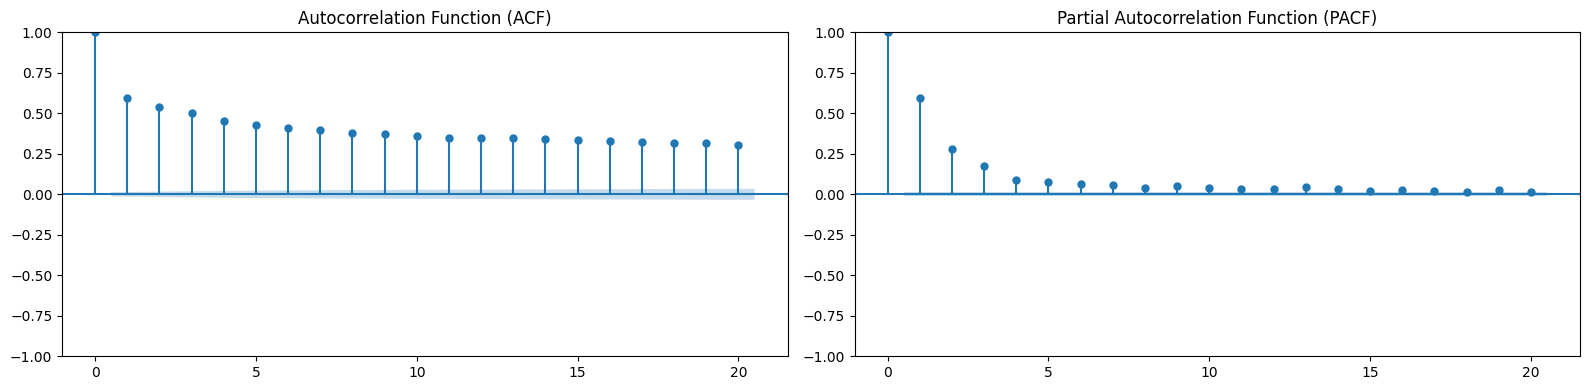

In [85]:
# prompt: make the PADF and ADF graphs to get the p and q ARIMA value on dfCopy

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming dfCopy['Quantity'] is your time series data
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plot the ACF
plot_acf(df['Quantity'], lags=20, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# Plot the PACF
plot_pacf(df['Quantity'], lags=20, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [86]:
df

id_ocorrencia  lat_ocorrencia  lon_ocorrencia  \
0           40045445      -28.684659      -49.388056   
1          130041858      -27.146564      -48.505497   
2           40046947      -28.679681      -49.364891   
3          130041869      -27.153351      -48.484377   
4          130041884      -27.034795      -48.669560   
...              ...             ...             ...   
23280       80117658      -28.070704      -48.622803   
23281       80117841      -28.026137      -48.615941   
23282       20110446      -27.444620      -51.245612   
23283       20110449      -27.392914      -51.218675   
23284       20110484      -27.155513      -50.908091   

                               tipo                   subtipo       Dates  \
0      SALVAMENTO / BUSCA / RESGATE                       NaN  2017-05-20   
1      SALVAMENTO / BUSCA / RESGATE                       NaN  2017-10-23   
2      SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2017-06-29   
3      SALVAMENTO / BUSCA / RESGATE                       NaN  2017-10-24   
4      SALVAMENTO / BUSCA / RESGATE                       NaN  2017-10-24   
...                             ...                       ...         ...   
23280  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2021-01-13   
23281  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2021-01-17   
23282  SALVAMENTO / BUSCA / RESGATE               CAPOTAMENTO  2020-08-28   
23283  SALVAMENTO / BUSCA / RESGATE            COLISÃO/CHOQUE  2020-08-28   
23284  SALVAMENTO / BUSCA / RESGATE               CAPOTAMENTO  2020-08-29   

           Time  Hour  Year  Month  Day  Quantity  diff  
0      16:40:00    16  2017      5   20        16   NaN  
1      17:14:00    17  2017     10   23        24   8.0  
2      20:37:00    20  2017      6   29        21  -3.0  
3      10:38:00    10  2017     10   24        17  -4.0  
4      16:34:00    16  2017     10   24        17   0.0  
...         ...   ...   ...    ...  ...       ...   ...  
23280  13:18:04    13  2021      1   13        31   3.0  
23281  10:10:51    10  2021      1   17        28  -3.0  
23282  08:03:08     8  2020      8   28        21  -7.0  
23283  10:55:02    10  2020      8   28        21   0.0  
23284  01:19:20     1  2020      8   29        24   3.0  

[23285 rows x 13 columns]

Treinamento

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Extract the 'Quantity' column as the target variable
target_variable = dfCopy3['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Create a function to prepare the dataset with lookback
def create_dataset(data, lookback=1):
    X, y = [], []
      for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback), 0])
        y.append(data[i + lookback, 0])
    return np.array(X), np.array(y)

# Set the lookback period (number of previous time steps to use as input variables)
lookback = 2

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.6)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# Prepare the train and test datasets with lookback
X_train, y_train = create_dataset(train_data, lookback)
X_test, y_test = create_dataset(test_data, lookback)

# Check shapes before reshaping
print(f'X_train shape before reshaping: {X_train.shape}')
print(f'X_test shape before reshaping: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Reshape the input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Check shapes after reshaping
print(f'X_train shape after reshaping: {X_train.shape}')
print(f'X_test shape after reshaping: {X_test.shape}')

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(lookback, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predict the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Convert the index of y_test and predictions back to datetime
y_test_dates = dfCopy.index[-len(y_test):]
predictions_dates = dfCopy.index[-len(predictions):]

# Plot the predictions and test data
plt.figure(figsize=(12, 6))
plt.plot(y_test_dates, y_test, label='Test Data')
plt.plot(predictions_dates, predictions, label='Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Calculate the mean squared error
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
date_rng = pd.date_range(start='1/1/2020', end='1/1/2022', freq='D')
df = pd.DataFrame(date_rng, columns=['date'])
df['Quantity'] = np.random.randint(1, 100, size=(len(date_rng)))

# Set date as index
df.set_index('date', inplace=True)

# Split the data into train and test sets
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

# Manual tuning of ARIMA parameters
best_model = None
best_aic = float("inf")
best_order = None

for p in range(1, 6):
    for d in range(0, 2):
        for q in range(0, 6):
            try:
                model = ARIMA(train_data['Quantity'], order=(p, d, q))
                model_fit = model.fit()
                print(f"ARIMA({p},{d},{q}) - AIC: {model_fit.aic}")
                if model_fit.aic < best_aic:
                    best_model = model_fit
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
            except:
                continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")

# Train the best model
model_fit = best_model

# Make predictions
start_index = len(train_data)
end_index = len(train_data) + len(test_data) - 1
predictions = model_fit.predict(start=start_index, end=end_index, typ='levels')

# Align predictions with test data index
predictions.index = test_data.index

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Quantity'], label='Train')
plt.plot(test_data.index, test_data['Quantity'], label='Test')
plt.plot(predictions.index, predictions, label='Predictions', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('ARIMA Model Predictions')
plt.show()

# Calculate the mean squared error
mse = mean_squared_error(test_data['Quantity'], predictions)
print(f'Mean Squared Error: {mse}')

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


ValueError: aspect must be finite and positive 

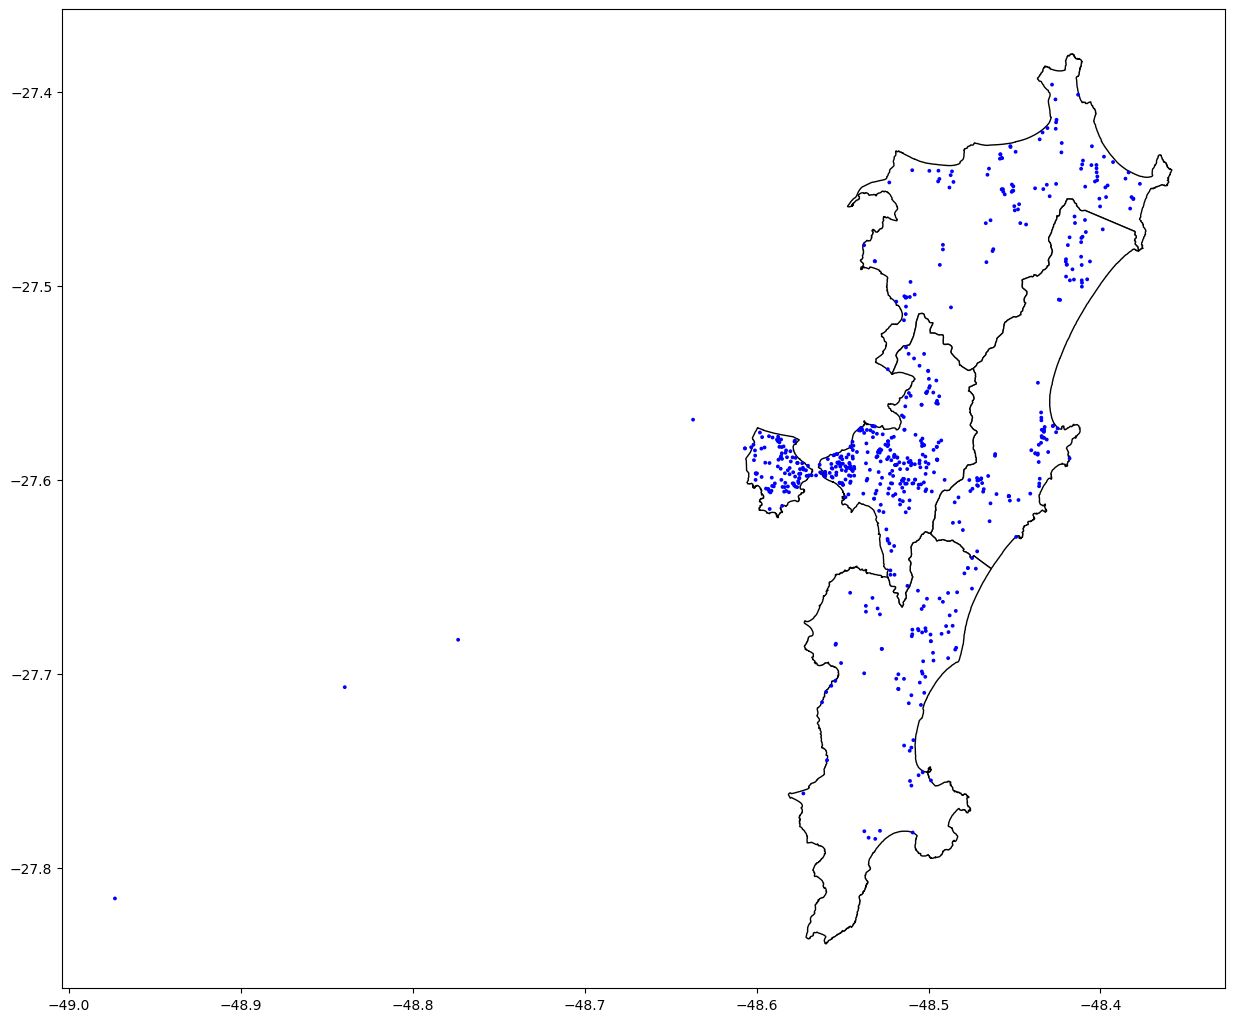

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Creating geometry from lon_ocorrencia and lat_ocorrencia
geometry = [Point(xy) for xy in zip(dfFloripa["lon_ocorrencia"], dfFloripa["lat_ocorrencia"])]

# Creating a GeoDataFrame
geo_df = gpd.GeoDataFrame(dfFloripa, geometry=geometry, crs='EPSG:4326')

# Defining color mapping for "tipo"
tipo_colors = {
    'SALVAMENTO / BUSCA / RESGATE': 'blue',
    'INCÊNDIO': 'green'
}

# Assuming fmap is loaded correctly, adjust as per your actual file loading
fmap = gpd.read_file("drive/MyDrive/TCC/fpolis_regiao/fpolis_regiao.shp")
fmap = fmap.to_crs(epsg=4326)  # Ensure fmap is in the same CRS as geo_df

# Plotting
fig, ax = plt.subplots(figsize=(15, 15))

# Plot base map
fmap.plot(ax=ax, color='white', edgecolor='black')

# Plot points based on "tipo" with specified colors
for tipo, color in tipo_colors.items():
    geo_df[geo_df['tipo'] == tipo].plot(ax=ax, color=color, marker='o', markersize=3, label=tipo, linestyle="")


# Adding legend
plt.legend()

# Showing plot
plt.show()


In [51]:
dfCopy = dfFloripa.copy()

In [ ]:
dfCopy = dfCopy.drop(columns=['cidade','populacao','horario','mtcl','vtr','obm','coordenada_obm','lat_obm','lon_obm','origem_samu','vitima','coordenada_ocorrencia','militar_bc','bc_indenizado','tipo','subtipo','tempo_resposta','tempo_total_empenho','firecast'])

In [52]:
dfCopy = dfCopy.drop(columns=['cidade','populacao','horario','mtcl','vtr','obm','coordenada_obm','lat_obm','lon_obm','origem_samu','vitima','coordenada_ocorrencia','militar_bc','bc_indenizado','tempo_resposta','tempo_total_empenho','firecast'])

In [81]:
df = df.drop(columns=['cidade','populacao','horario','mtcl','vtr','obm','coordenada_obm','lat_obm','lon_obm','origem_samu','vitima','coordenada_ocorrencia','militar_bc','bc_indenizado','tempo_resposta','tempo_total_empenho','firecast'])

Resultados comparativos

LSTM

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1863
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1419  
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0843 
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0402
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311 
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0243 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0167
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114 
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


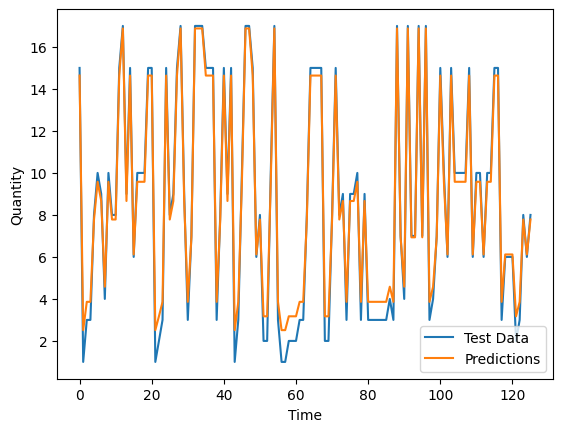

Mean Squared Error: 0.38655792289450996
Root Mean Squared Error: 0.6217378248864307


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Extract the 'Quantity' column as the target variable
target_variable = dfCopy['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# 2. Model Building

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, train_data, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data = scaler.inverse_transform(test_data)

# Plot the predictions and test data
plt.plot(test_data, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

# Calculate the mean squared error
mse = mean_squared_error(test_data, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1922
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1491 
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0867 
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0390 
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311 
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175 
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


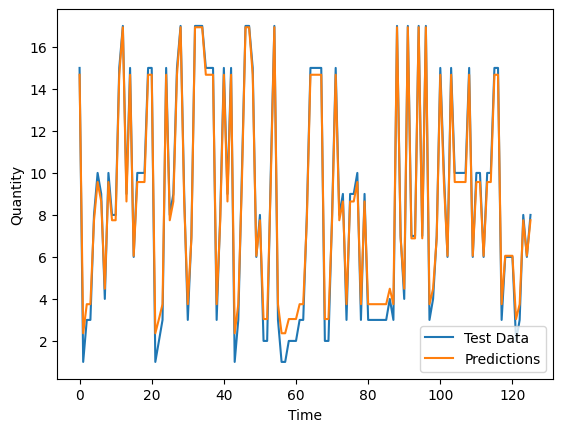

Mean Squared Error: 0.3134232782855016
Root Mean Squared Error: 0.5598421905193477


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Extract the 'Quantity' column as the target variable
target_variable = df2['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# 2. Model Building

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, train_data, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data = scaler.inverse_transform(test_data)

# Plot the predictions and test data
plt.plot(test_data, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

# Calculate the mean squared error
mse = mean_squared_error(test_data, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

In [ ]:
df2

ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


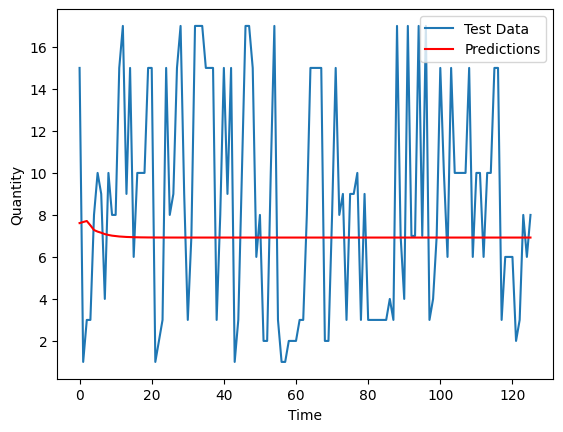

Mean Squared Error: 29.326447454390664
Root Mean Squared Error: 5.415389870950259


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Extract the 'Quantity' column as the target variable
target_variable = dfCopy['Quantity'].values

# Split the data into train and test sets
train_size = int(len(target_variable) * 0.8)
train_data, test_data = target_variable[:train_size], target_variable[train_size:]

# 2. Model Building

# Set ARIMA order (p, d, q)
p = 5  # Autoregressive part
d = 1  # Differencing
q = 2  # Moving average part

# Create the ARIMA model
model = ARIMA(train_data, order=(p, d, q))

# 3. Model Training

# Fit the model to the training data
model_fit = model.fit()

# 4. Prediction and Evaluation

# Forecast the test data
predictions = model_fit.forecast(steps=len(test_data))

# Plot the predictions and test data
plt.plot(test_data, label='Test Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

# Calculate the mean squared error
mse = mean_squared_error(test_data, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test on the target variable
result = adfuller(dfCopy['Quantity'].values)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If p-value > 0.05, the data is non-stationary


ADF Statistic: -8.872874151546148
p-value: 1.3827446393360481e-14


In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.4 MB/s eta 0:00:00


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  501
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -1449.759
Date:                Wed, 23 Oct 2024   AIC                           2909.519
Time:                        18:24:26   BIC                           2930.592
Sample:                             0   HQIC                          2917.788
                                - 501                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2342      0.040      5.929      0.000       0.157       0.312
ar.L2          0.1330      0.043      3.117      0.002       0.049       0.217
ar.L3          0.1095      0.041      2.650      0.0

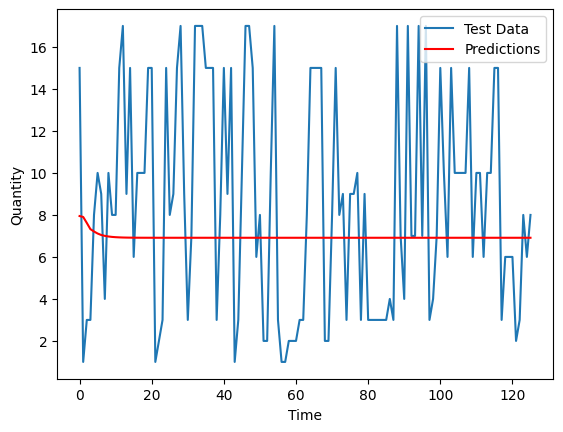

Mean Squared Error: 29.351242525962775
Root Mean Squared Error: 5.417678702725253
Mean Absolute Error: 4.499924389733598
Mean Absolute Percentage Error: 0.8967435100725014


In [ ]:
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


# Automatically discover the best p, d, q values
model = pm.auto_arima(train_data, start_p=0, start_q=0, max_p=10, max_q=10, d=0, seasonal=False, stepwise=True)

# Print the summary of the model to see the best parameters
print(model.summary())

# Fit and forecast
model_fit = model.fit(train_data)
predictions = model_fit.predict(n_periods=len(test_data))

# Plot the predictions and test data
plt.plot(test_data, label='Test Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Calculate error metrics
mse = mean_squared_error(test_data, predictions)
print(f'Mean Squared Error: {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

mae = mean_absolute_error(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape}')


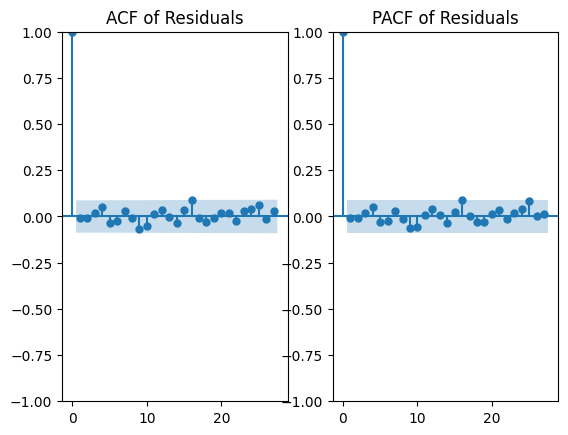

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

residuals = model_fit.resid()
plt.figure()
plt.subplot(121)
plot_acf(residuals, ax=plt.gca(), title="ACF of Residuals")
plt.subplot(122)
plot_pacf(residuals, ax=plt.gca(), title="PACF of Residuals")
plt.show()


In [ ]:
model = pm.auto_arima(train_data, seasonal=True, m=12, stepwise=True)


KeyboardInterrupt: 

Mean Squared Error: 25.069720184762858
Root Mean Squared Error: 5.006967164338394
Mean Absolute Error: 4.145160983282473
Mean Absolute Percentage Error: 0.9910714975187589


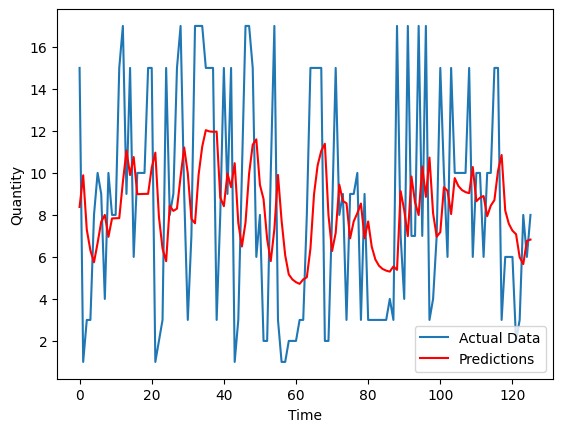

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm



# Initialize history with the training data
history = [x for x in train_data]
predictions = []

# Automatically discover the best p, d, q values
auto_model = pm.auto_arima(train_data, start_p=1, start_q=1, max_p=5, max_q=5, d=0, seasonal=False, stepwise=True)
p, d, q = auto_model.order  # Extract best p, d, q parameters from Auto-ARIMA
# Assume train_data and test_data are already defined

# Perform rolling forecast
for t in range(len(test_data)):
    # Fit the ARIMA model on the rolling history
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data to history (rolling update)
    history.append(test_data[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse transform if necessary (if you had scaled the data)

# Evaluate the performance
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

# Plot predictions vs actual values
plt.plot(test_data, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


Mean Squared Error: 28.1231954576099
Root Mean Squared Error: 5.303130722281876
Mean Absolute Error: 4.305797620243894
Mean Absolute Percentage Error: 0.8324548164773917


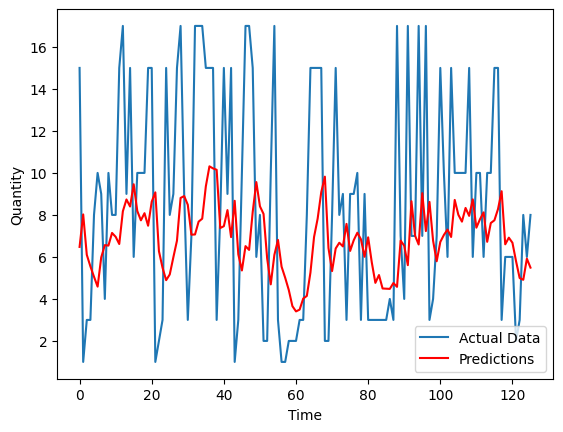

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm

# Apply Log Transformation
train_data_transformed = np.log1p(train_data)  # log(1 + x) to handle 0 values
test_data_transformed = np.log1p(test_data)


# Initialize history with the transformed training data
history = [x for x in train_data_transformed]
predictions = []

# Automatically discover the best p, d, q values using transformed data
auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1, max_p=5, max_q=5, d=0, seasonal=False, stepwise=True)
p, d, q = auto_model.order  # Extract best p, d, q parameters from Auto-ARIMA

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the ARIMA model on the rolling history
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the transformation (log to original scale)
predictions = np.expm1(predictions)  # Inverse log(1+x) -> exp(x)-1
test_data_original = np.expm1(test_data_transformed)


# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


Mean Squared Error: 26.56274438736182
Root Mean Squared Error: 5.153905741024163
Mean Absolute Error: 4.230418838706723
Mean Absolute Percentage Error: 0.6289884495016673


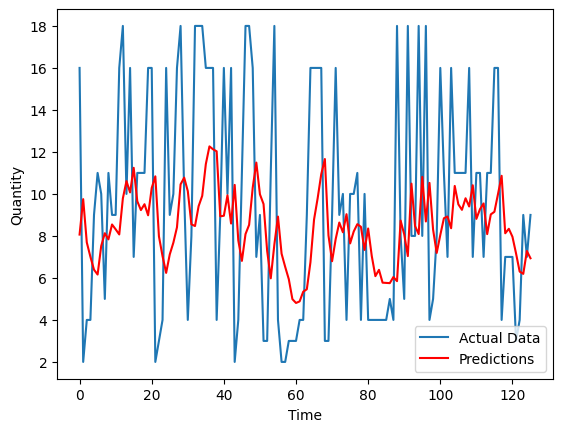

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm


#train_data_transformed = np.log1p(train_data)  # log(1 + x) to handle 0 values
#test_data_transformed = np.log1p(test_data)

# If you want to use Box-Cox transformation instead:
train_data_transformed, lmbda = boxcox(train_data + 1)  # Adding 1 to avoid issues with zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data
history = [x for x in train_data_transformed]
predictions = []

# Automatically discover the best p, d, q values using transformed data
auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1, max_p=5, max_q=5, d=0, seasonal=False, stepwise=True)
p, d, q = auto_model.order  # Extract best p, d, q parameters from Auto-ARIMA

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the ARIMA model on the rolling history
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the transformation (log to original scale)
#predictions = np.expm1(predictions)  # Inverse log(1+x) -> exp(x)-1
#test_data_original = np.expm1(test_data_transformed)

# If using Box-Cox:
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


Mean Squared Error: 27.2891402615584
Root Mean Squared Error: 5.223900866360157
Mean Absolute Error: 4.19805140859361
Mean Absolute Percentage Error: 0.6586733168415156


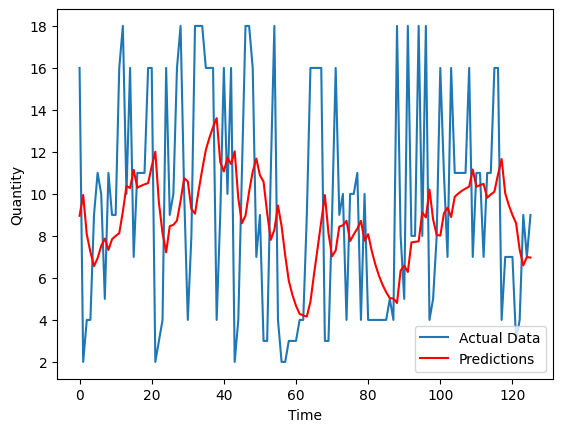

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Use SARIMAX for seasonal ARIMA
from scipy.stats import boxcox
import pmdarima as pm

train_data_transformed, lmbda = boxcox(train_data + 1)  # Adding 1 to avoid issues with zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data
history = [x for x in train_data_transformed]
predictions = []

# Automatically discover the best seasonal parameters (P, D, Q, m) for SARIMA
auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1,
                            max_p=5, max_q=5, d=0, seasonal=True,
                            start_P=0, seasonal_test='ch',
                            m=7, stepwise=True)  # Adjust m based on seasonality (e.g., 12 for monthly)
p, d, q = auto_model.order  # Extract best ARIMA orders
P, D, Q, m = auto_model.seasonal_order  # Extract best seasonal orders

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the SARIMA model on the rolling history
    model = SARIMAX(history, order=(p, d, q), seasonal_order=(P, D, Q, m))
    model_fit = model.fit(disp=False)  # Suppress output

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the Box-Cox transformation
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


Mean Squared Error: 27.2891402615584
Root Mean Squared Error: 5.223900866360157
Mean Absolute Error: 4.19805140859361
Mean Absolute Percentage Error: 0.6586733168415156


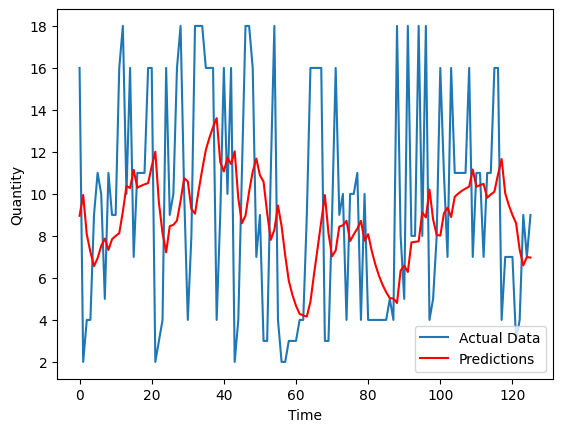

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Use SARIMAX for seasonal ARIMA
from scipy.stats import boxcox
import pmdarima as pm

# Box-Cox transformation:
train_data_transformed, lmbda = boxcox(train_data + 1)  # Adding 1 to avoid issues with zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data
history = [x for x in train_data_transformed]
predictions = []

# Automatically discover the best seasonal parameters (P, D, Q, m) for SARIMA
auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1,
                            max_p=5, max_q=5, d=0, seasonal=True,
                            start_P=0, seasonal_test='ch',
                            m=12, stepwise=True)  # Adjust m based on seasonality (e.g., 12 for monthly)
p, d, q = auto_model.order  # Extract best ARIMA orders
P, D, Q, m = auto_model.seasonal_order  # Extract best seasonal orders

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the SARIMA model on the rolling history
    model = SARIMAX(history, order=(p, d, q), seasonal_order=(P, D, Q, m))
    model_fit = model.fit(disp=False)  # Suppress output

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the Box-Cox transformation
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


<ipython-input-53-4823b075992e>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = train_data.fillna(method='ffill')
<ipython-input-53-4823b075992e>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data = test_data.fillna(method='ffill')


Optimal orders - p: 4, d: 0, q: 0, P: 2, D: 1, Q: 0, m: 12
Mean Squared Error: 32.36855629615207
Root Mean Squared Error: 5.689337070006669
Mean Absolute Error: 4.523248430812978
Mean Absolute Percentage Error: 0.7226303751538745


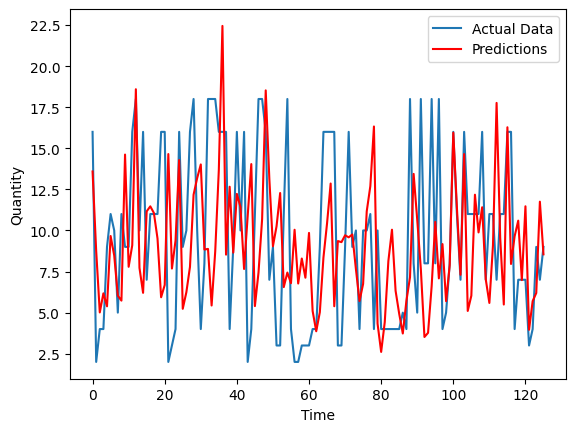

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
import pmdarima as pm

train_data = pd.Series(dfCopy['Quantity'][:train_size])
test_data = pd.Series(dfCopy['Quantity'][train_size:])

# Check for missing values and handle them (e.g., forward fill)
train_data = train_data.fillna(method='ffill')
test_data = test_data.fillna(method='ffill')

# Box-Cox transformation
train_data_transformed, lmbda = boxcox(train_data + 1)  # Add 1 to avoid zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data
history = list(train_data_transformed)
predictions = []

# Automatically discover the best seasonal parameters (P, D, Q, m) for SARIMA
auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1,
                            max_p=5, max_q=5, seasonal=True,
                            m=12, stepwise=True,
                            seasonal_test='ch',
                            start_P=0, start_Q=0,
                            D=1)  # Try setting D=1 for seasonal differencing
p, d, q = auto_model.order
P, D, Q, m = auto_model.seasonal_order


print(f"Optimal orders - p: {p}, d: {d}, q: {q}, P: {P}, D: {D}, Q: {Q}, m: {m}")

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the SARIMA model on the rolling history
    model = SARIMAX(history, order=(p, d, q), seasonal_order=(P, D, Q, m))
    model_fit = model.fit(disp=False)

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the Box-Cox transformation
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


MERGE

In [ ]:
inmet = inmet.assign(
    DatesNew=inmet.DatesNew.astype('string')
)

In [ ]:
dfCopy = dfCopy.assign(
    Dates=dfCopy.Dates.astype('string')
)

In [ ]:
df4 = df4.assign(
    Dates=dfCopy.Dates.astype('string')
)

In [ ]:
inmet

PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  \
0                                 1,4   
1                                 1,8   
2                                 0,8   
3                                   0   
4                                   0   
...                               ...   
8755                              0,2   
8756                                0   
8757                                0   
8758                                0   
8759                                0   

     PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                                  1011      
1                                                1011,4      
2                                                1010,1      
3                                                1009,5      
4                                                  1009      
...                                                 ...      
8755                                             1006,4      
8756                                             1006,3      
8757                                             1006,3      
8758                                             1006,8      
8759                                             1007,6      

     PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
0                                               1011   
1                                             1011,4   
2                                             1011,4   
3                                             1010,2   
4                                             1009,5   
...                                              ...   
8755                                          1007,1   
8756                                          1006,4   
8757                                          1006,3   
8758                                          1006,9   
8759                                          1007,6   

     PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)  \
0                                              1009,7   
1                                              1010,7   
2                                              1010,1   
3                                              1009,5   
4                                              1008,9   
...                                               ...   
8755                                           1006,4   
8756                                           1006,2   
8757                                           1006,2   
8758                                           1006,3   
8759                                           1006,8   

     TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  \
0                                            23,5   
1                                            23,2   
2                                            23,5   
3                                            23,2   
4                                            23,3   
...                                           ...   
8755                                         24,5   
8756                                         25,5   
8757                                         25,4   
8758                                         24,9   
8759                                         24,5   

     TEMPERATURA DO PONTO DE ORVALHO (°C)  \
0                                    21,7   
1                                    21,5   
2                                    21,7   
3                                    21,3   
4                                    21,2   
...                                   ...   
8755                                 20,8   
8756                                   21   
8757                                 20,7   
8758                                 20,6   
8759                                 20,6   

     TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)  \
0                                            24   
1                                          23,6   
2                                          23,6   
3                          

In [ ]:
# prompt: see if inmet has bad data

import pandas as pd

# Assuming 'inmet' and 'dfCopy' are your DataFrames

# Check for missing values in relevant columns
inmet_missing = inmet.isnull().sum()
dfCopy_missing = dfCopy.isnull().sum()

print("Inmet Missing Values:\n", inmet_missing)
print("\nDataFrame Copy Missing Values:\n", dfCopy_missing)


Inmet Missing Values:
 PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                           740
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)       20
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)             20
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)            20
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)                20
TEMPERATURA DO PONTO DE ORVALHO (°C)                        20
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)                  20
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)                  20
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)            20
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)            20
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                    20
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                    20
UMIDADE RELATIVA DO AR, HORARIA (%)                         20
VENTO, DIREÇÃO HORARIA (gr) (° (gr))                        20
VENTO, RAJADA MAXIMA (m/s)                                  20
VENTO, VELOCIDADE HORARIA (m/s) 

In [ ]:
# prompt: make the only the registers of Radiacao in inmet dataframe that are -9999 become the mean of all the others values of the Radiacao collumn

inmet['Radiacao'] = pd.to_numeric(inmet['Radiacao'].str.replace(',', '.'))

# Calculate the mean of 'Radiacao' excluding -9999 values
mean_radiacao = inmet.loc[inmet['Radiacao'] != -9999, 'Radiacao'].mean()

# Replace -9999 values with the calculated mean
inmet.loc[inmet['Radiacao'] == -9999, 'Radiacao'] = mean_radiacao

In [ ]:
inmet

PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  \
0                                 1,4   
1                                 1,8   
2                                 0,8   
3                                   0   
4                                   0   
...                               ...   
8755                              0,2   
8756                                0   
8757                                0   
8758                                0   
8759                                0   

     PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                                  1011      
1                                                1011,4      
2                                                1010,1      
3                                                1009,5      
4                                                  1009      
...                                                 ...      
8755                                             1006,4      
8756                                             1006,3      
8757                                             1006,3      
8758                                             1006,8      
8759                                             1007,6      

     PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
0                                               1011   
1                                             1011,4   
2                                             1011,4   
3                                             1010,2   
4                                             1009,5   
...                                              ...   
8755                                          1007,1   
8756                                          1006,4   
8757                                          1006,3   
8758                                          1006,9   
8759                                          1007,6   

     PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)  \
0                                              1009,7   
1                                              1010,7   
2                                              1010,1   
3                                              1009,5   
4                                              1008,9   
...                                               ...   
8755                                           1006,4   
8756                                           1006,2   
8757                                           1006,2   
8758                                           1006,3   
8759                                           1006,8   

     TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  \
0                                            23,5   
1                                            23,2   
2                                            23,5   
3                                            23,2   
4                                            23,3   
...                                           ...   
8755                                         24,5   
8756                                         25,5   
8757                                         25,4   
8758                                         24,9   
8759                                         24,5   

     TEMPERATURA DO PONTO DE ORVALHO (°C)  \
0                                    21,7   
1                                    21,5   
2                                    21,7   
3                                    21,3   
4                                    21,2   
...                                   ...   
8755                                 20,8   
8756                                   21   
8757                                 20,7   
8758                                 20,6   
8759                                 20,6   

     TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)  \
0                                            24   
1                                          23,6   
2                                          23,6   
3                          

In [ ]:
df2 = pd.merge(dfCopy, inmet,  how='inner', left_on=['Dates', 'Hour'], right_on = ['DatesNew', 'HorasN2'])

In [ ]:
df4 =  pd.merge(df4, inmet,  how='inner', left_on=['Dates', 'Hour'], right_on = ['DatesNew', 'HorasN2'])

In [ ]:
df4

id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
0         10064414      -27.447496      -48.425808  2017-01-04  09:11:00   
1         10064717      -27.455293      -48.380926  2017-01-09  08:57:00   
2         10064915      -27.596752      -48.574580  2017-01-12  14:07:00   
3         10065157      -27.467694      -48.446634  2017-01-16  08:22:00   
4         10065272      -27.601925      -48.512678  2017-01-17  20:11:00   
..             ...             ...             ...         ...       ...   
622       10137885      -27.593763      -48.573022  2021-01-14  19:55:21   
623       10137890      -27.589377      -48.550147  2021-01-14  22:30:11   
624       10137909      -27.535046      -48.511553  2021-01-15  11:40:53   
625       10137954      -27.415774      -48.425837  2021-01-16  12:20:57   
626       10138032      -27.597699      -48.565381  2021-01-17  20:27:40   

     Hour  Year  Month  Day Classe_Bacias  ...  \
0       9  2017      1    4         Media  ...   
1       8  2017      1    9         Baixa  ...   
2      14  2017      1   12         Baixa  ...   
3       8  2017      1   16          Alta  ...   
4      20  2017      1   17          Alta  ...   
..    ...   ...    ...  ...           ...  ...   
622    19  2021      1   14         Baixa  ...   
623    22  2021      1   14         Baixa  ...   
624    11  2021      1   15          Alta  ...   
625    12  2021      1   16         Baixa  ...   
626    20  2021      1   17         Baixa  ...   

    TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)  \
0                                               22,2   
1                                               22,5   
2                                               18,9   
3                                               21,6   
4                                                 19   
..                                               ...   
622                                             18,2   
623                                             19,3   
624                                             20,8   
625                                             21,7   
626                                             22,5   

     UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)  \
0                                        88.0   
1                                        90.0   
2                                        68.0   
3                                        88.0   
4                                        77.0   
..                                        ...   
622                                      80.0   
623                                      87.0   
624                                      91.0   
625                                      75.0   
626                                      82.0   

     UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  \
0                                        86.0   
1                                        89.0   
2                                        60.0   
3                                        86.0   
4                                        62.0   
..                                        ...   
622                                      73.0   
623                                      85.0   
624                                      90.0   
625                                      69.0   
626                                      72.0   

    UMIDADE RELATIVA DO AR, HORARIA (%) VENTO, DIREÇÃO HORARIA (gr) (° (gr))  \
0                                  87.0                                310.0   
1                                  90.0                                337.0   
2                                  63.0                                145.0   
3                                  88.0                                274.0   
4                                  77.0                                181.0   
..                                  ...                                  ...   
622                                74.0                                157.0   


In [ ]:
inmet

PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  \
0                                 1,4   
1                                 1,8   
2                                 0,8   
3                                   0   
4                                   0   
...                               ...   
8755                              0,2   
8756                                0   
8757                                0   
8758                                0   
8759                                0   

     PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                                  1011      
1                                                1011,4      
2                                                1010,1      
3                                                1009,5      
4                                                  1009      
...                                                 ...      
8755                                             1006,4      
8756                                             1006,3      
8757                                             1006,3      
8758                                             1006,8      
8759                                             1007,6      

     PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
0                                               1011   
1                                             1011,4   
2                                             1011,4   
3                                             1010,2   
4                                             1009,5   
...                                              ...   
8755                                          1007,1   
8756                                          1006,4   
8757                                          1006,3   
8758                                          1006,9   
8759                                          1007,6   

     PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)  \
0                                              1009,7   
1                                              1010,7   
2                                              1010,1   
3                                              1009,5   
4                                              1008,9   
...                                               ...   
8755                                           1006,4   
8756                                           1006,2   
8757                                           1006,2   
8758                                           1006,3   
8759                                           1006,8   

     TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  \
0                                            23,5   
1                                            23,2   
2                                            23,5   
3                                            23,2   
4                                            23,3   
...                                           ...   
8755                                         24,5   
8756                                         25,5   
8757                                         25,4   
8758                                         24,9   
8759                                         24,5   

     TEMPERATURA DO PONTO DE ORVALHO (°C)  \
0                                    21,7   
1                                    21,5   
2                                    21,7   
3                                    21,3   
4                                    21,2   
...                                   ...   
8755                                 20,8   
8756                                   21   
8757                                 20,7   
8758                                 20,6   
8759                                 20,6   

     TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)  \
0                                            24   
1                                          23,6   
2                                          23,6   
3                          

<ipython-input-49-cec976cb329c>:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = train_data.fillna(method='ffill')
<ipython-input-49-cec976cb329c>:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data = test_data.fillna(method='ffill')


Optimal orders - p: 4, d: 0, q: 0, P: 2, D: 1, Q: 0, m: 12
Mean Squared Error: 32.36855629615207
Root Mean Squared Error: 5.689337070006669
Mean Absolute Error: 4.523248430812978
Mean Absolute Percentage Error: 0.7226303751538745


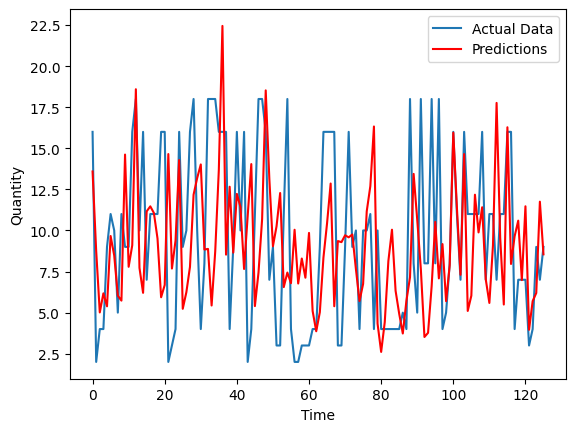

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
import pmdarima as pm

# Extract the 'Quantity' column as the target variable
target_variable = df2['Quantity'].values

# Split the data into train and test sets
train_size = int(len(target_variable) * 0.8)

train_data = pd.Series(df2['Quantity'][:train_size])  # Replace train_size with your split index
test_data = pd.Series(df2['Quantity'][train_size:])   # Adjust for your data split

# Check for missing values and handle them (e.g., forward fill)
train_data = train_data.fillna(method='ffill')
test_data = test_data.fillna(method='ffill')

# Box-Cox transformation
train_data_transformed, lmbda = boxcox(train_data + 1)  # Add 1 to avoid zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data
history = list(train_data_transformed)
predictions = []

# Automatically discover the best seasonal parameters (P, D, Q, m) for SARIMA
auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1,
                            max_p=5, max_q=5, seasonal=True,
                            m=12, stepwise=True,
                            seasonal_test='ch',
                            start_P=0, start_Q=0,
                            D=1)  # Try setting D=1 for seasonal differencing
p, d, q = auto_model.order
P, D, Q, m = auto_model.seasonal_order

print(f"Optimal orders - p: {p}, d: {d}, q: {q}, P: {P}, D: {D}, Q: {Q}, m: {m}")

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the SARIMA model on the rolling history
    model = SARIMAX(history, order=(p, d, q), seasonal_order=(P, D, Q, m))
    model_fit = model.fit(disp=False)

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the Box-Cox transformation
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


armia

<ipython-input-51-1c3f373a15fa>:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = train_data.fillna(method='ffill')
<ipython-input-51-1c3f373a15fa>:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data = test_data.fillna(method='ffill')


Optimal orders - p: 4, d: 0, q: 0, P: 2, D: 1, Q: 0, m: 12
Mean Squared Error: 32.36855629615207
Root Mean Squared Error: 5.689337070006669
Mean Absolute Error: 4.523248430812978
Mean Absolute Percentage Error: 0.7226303751538745


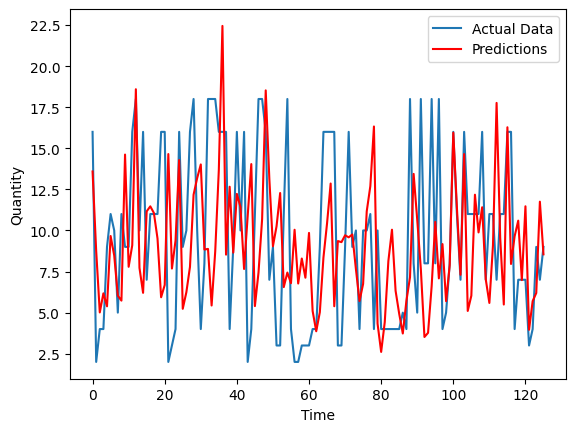

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
import pmdarima as pm

df_encoded = pd.get_dummies(dfCopy, drop_first=True)  # Converts strings to one-hot and drops the first category to avoid multicollinearity

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Split the data into train and test sets
train_size = int(len(target_variable) * 0.8)

# Ensure train_data and test_data are Pandas Series
# Assuming dfCopy is your original DataFrame and 'Quantity' is the column of interest
train_data = pd.Series(dfCopy['Quantity'][:train_size])  # Replace train_size with your split index
test_data = pd.Series(dfCopy['Quantity'][train_size:])   # Adjust for your data split

# Check for missing values and handle them (e.g., forward fill)
train_data = train_data.fillna(method='ffill')
test_data = test_data.fillna(method='ffill')

# Box-Cox transformation
train_data_transformed, lmbda = boxcox(train_data + 1)  # Add 1 to avoid zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data
history = list(train_data_transformed)
predictions = []

# Automatically discover the best seasonal parameters (P, D, Q, m) for SARIMA
auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1,
                            max_p=5, max_q=5, seasonal=True,
                            m=12, stepwise=True,
                            seasonal_test='ch',
                            start_P=0, start_Q=0,
                            D=1)  # Try setting D=1 for seasonal differencing
p, d, q = auto_model.order
P, D, Q, m = auto_model.seasonal_order

print(f"Optimal orders - p: {p}, d: {d}, q: {q}, P: {P}, D: {D}, Q: {Q}, m: {m}")

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the SARIMA model on the rolling history
    model = SARIMAX(history, order=(p, d, q), seasonal_order=(P, D, Q, m))
    model_fit = model.fit(disp=False)

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the Box-Cox transformation
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1926
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1167
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0810
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0649
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0529
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0403
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0284
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0206
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0121
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


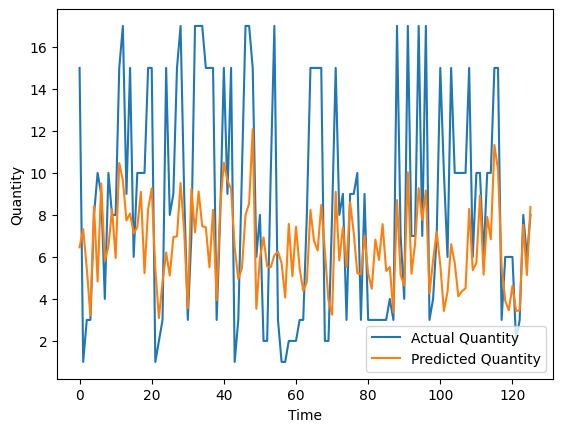

Mean Squared Error: 22.235768906189122
Root Mean Squared Error: 4.715481831816248


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(dfCopy, drop_first=True)  # Converts strings to one-hot and drops the first category to avoid multicollinearity

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for LSTM (samples, time steps, features)
train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))

# 2. Model Building

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_features, train_target, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(test_target, predictions)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


In [100]:
df_sorted

id_ocorrencia  lat_ocorrencia  lon_ocorrencia  \
1042        30033855      -26.811298      -49.089642   
1021        30033860      -26.931668      -48.940209   
4731        20056421      -27.058718      -50.896902   
1045        30033862      -26.875069      -49.112146   
4744        40039794      -28.682715      -49.365377   
...              ...             ...             ...   
22393       30085005      -27.151188      -48.958058   
20002      130091420      -27.124377      -48.605054   
22394       30085007      -27.139926      -48.959814   
20001      130091424      -26.898541      -48.692159   
18222       80117897      -28.474519      -49.010571   

                               tipo                   subtipo       Dates  \
1042   SALVAMENTO / BUSCA / RESGATE            COLISÃO/CHOQUE  2017-01-01   
1021   SALVAMENTO / BUSCA / RESGATE            COLISÃO/CHOQUE  2017-01-01   
4731   SALVAMENTO / BUSCA / RESGATE                       NaN  2017-01-01   
1045   SALVAMENTO / BUSCA / RESGATE            COLISÃO/CHOQUE  2017-01-01   
4744   SALVAMENTO / BUSCA / RESGATE                       NaN  2017-01-01   
...                             ...                       ...         ...   
22393  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2021-01-18   
20002  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2021-01-18   
22394  SALVAMENTO / BUSCA / RESGATE            COLISÃO/CHOQUE  2021-01-18   
20001  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2021-01-18   
18222  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2021-01-18   

           Time  Hour  Year  Month  Day  Quantity  
1042   00:47:00     0  2017      1    1        10  
1021   08:49:00     8  2017      1    1        10  
4731   10:08:00    10  2017      1    1        10  
1045   10:12:00    10  2017      1    1        10  
4744   14:04:00    14  2017      1    1        10  
...         ...   ...   ...    ...  ...       ...  
22393  20:02:53    20  2021      1   18        23  
20002  20:46:05    20  2021      1   18        23  
22394  21:19:58    21  2021      1   18        23  
20001  21:55:12    21  2021      1   18        23  
18222  23:02:31    23  2021      1   18        23  

[23285 rows x 12 columns]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1826
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0927
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0500
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0390
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0161
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0095
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


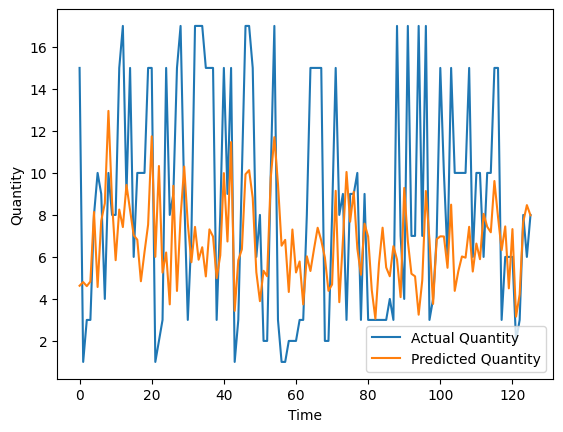

Mean Squared Error: 26.759056517459662
Root Mean Squared Error: 5.172915668891158


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df2, drop_first=True)  # Converts strings to one-hot and drops the first category to avoid multicollinearity

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for LSTM (samples, time steps, features)
train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))

# 2. Model Building

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_features, train_target, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(test_target, predictions)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


<ipython-input-46-25143e1218a8>:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = train_data.fillna(method='ffill')
<ipython-input-46-25143e1218a8>:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data = test_data.fillna(method='ffill')


Optimal orders - p: 4, d: 0, q: 0, P: 2, D: 1, Q: 0, m: 12
Mean Squared Error: 32.36855629615207
Root Mean Squared Error: 5.689337070006669
Mean Absolute Error: 4.523248430812978
Mean Absolute Percentage Error: 0.7226303751538745


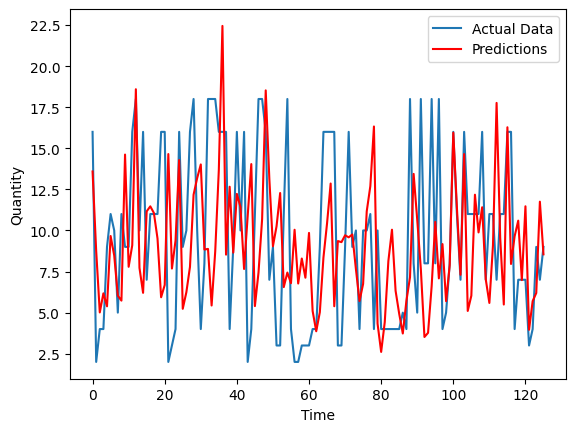

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
import pmdarima as pm

df_encoded = pd.get_dummies(df2, drop_first=True)  # Converts strings to one-hot and drops the first category to avoid multicollinearity

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Split the data into train and test sets
train_size = int(len(target_variable) * 0.8)

# Ensure train_data and test_data are Pandas Series
# Assuming dfCopy is your original DataFrame and 'Quantity' is the column of interest
train_data = pd.Series(df2['Quantity'][:train_size])  # Replace train_size with your split index
test_data = pd.Series(df2['Quantity'][train_size:])   # Adjust for your data split

# Check for missing values and handle them (e.g., forward fill)
train_data = train_data.fillna(method='ffill')
test_data = test_data.fillna(method='ffill')

# Box-Cox transformation
train_data_transformed, lmbda = boxcox(train_data + 1)  # Add 1 to avoid zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data
history = list(train_data_transformed)
predictions = []

# Automatically discover the best seasonal parameters (P, D, Q, m) for SARIMA
auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1,
                            max_p=5, max_q=5, seasonal=True,
                            m=12, stepwise=True,
                            seasonal_test='ch',
                            start_P=0, start_Q=0,
                            D=1)  # Try setting D=1 for seasonal differencing
p, d, q = auto_model.order
P, D, Q, m = auto_model.seasonal_order

print(f"Optimal orders - p: {p}, d: {d}, q: {q}, P: {P}, D: {D}, Q: {Q}, m: {m}")

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the SARIMA model on the rolling history
    model = SARIMAX(history, order=(p, d, q), seasonal_order=(P, D, Q, m))
    model_fit = model.fit(disp=False)

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the Box-Cox transformation
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
import pmdarima as pm

df_encoded = pd.get_dummies(dfCopy, drop_first=True)  # Converts strings to one-hot and drops the first category to avoid multicollinearity

# Extract 'Quantity' as the target variable and the rest as exogenous features
target_variable = df_encoded['Quantity'].values
exogenous_features = df_encoded.drop('Quantity', axis=1).values  # Drop target variable 'Quantity'

# Split the data into train and test sets
train_size = int(len(target_variable) * 0.8)

train_data = pd.Series(dfCopy['Quantity'][:train_size])
test_data = pd.Series(dfCopy['Quantity'][train_size:])

# Split exogenous features into train and test sets
exog_train = exogenous_features[:train_size, :]
exog_test = exogenous_features[train_size:, :]

# Handle missing values
train_data = train_data.fillna(method='ffill')
test_data = test_data.fillna(method='ffill')

# Box-Cox transformation to stabilize variance
train_data_transformed, lmbda = boxcox(train_data + 1)  # Add 1 to avoid zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data and exogenous history
history = list(train_data_transformed)
history_exog = exog_train.tolist()
predictions = []

# Automatically discover the best seasonal parameters (P, D, Q, m) for SARIMA
auto_model = pm.auto_arima(train_data_transformed, exogenous=exog_train, start_p=1, start_q=1,
                            max_p=5, max_q=5, seasonal=True,
                            m=12, stepwise=True,
                            seasonal_test='ch',
                            start_P=0, start_Q=0,
                            D=1)  # Seasonal differencing

p, d, q = auto_model.order
P, D, Q, m = auto_model.seasonal_order

print(f"Optimal orders - p: {p}, d: {d}, q: {q}, P: {P}, D: {D}, Q: {Q}, m: {m}")

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the SARIMAX model with exogenous variables on the rolling history
    model = SARIMAX(history, exog=np.array(history_exog), order=(p, d, q), seasonal_order=(P, D, Q, m))
    model_fit = model.fit(disp=False)

    # Make the forecast for the next time step with exogenous features from test set
    yhat = model_fit.forecast(exog=exog_test[t].reshape(1, -1))[0]

    # Store the prediction
    predictions.append(yhat)

    # Update history with the true observation and exogenous features
    history.append(test_data_transformed[t])
    history_exog.append(exog_test[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the Box-Cox transformation
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox


train_data_sample = train_data[:100].astype(float)  # Ensure data is float
exog_train_sample = exog_train[:100].astype(float)  # Ensure exogenous data is float

test_data_sample = test_data[:20].astype(float)  # Ensure test data is float
exog_test_sample = exog_test[:20].astype(float)  # Ensure test exogenous data is float

# Check for missing values and fill with np.nan_to_num (for numpy arrays)
train_data_sample = np.nan_to_num(train_data_sample, nan=0.0)  # Replace NaNs with 0
exog_train_sample = np.nan_to_num(exog_train_sample, nan=0.0)  # Replace NaNs with 0

test_data_sample = np.nan_to_num(test_data_sample, nan=0.0)  # Replace NaNs with 0
exog_test_sample = np.nan_to_num(exog_test_sample, nan=0.0)  # Replace NaNs with 0

# Initialize history and exogenous history for rolling forecast
history = list(train_data_sample)
history_exog = exog_train_sample.tolist()

predictions = []

p, d, q = 4, 0, 0
P, D, Q, m = 2, 1, 0, 12

# Perform a rolling forecast on a small dataset
for t in range(min(len(test_data_sample), 10)):  # Test on only 10 points initially
    # Ensure exogenous variables are properly reshaped
    exog_train_reshaped = np.array(history_exog).reshape(len(history_exog), -1)

    # Fit the SARIMAX model with exogenous variables
    model = SARIMAX(history, exog=exog_train_reshaped, order=(p, d, q), seasonal_order=(P, D, Q, m))

    try:
        # Fit the model with limited iterations
        model_fit = model.fit(disp=False, maxiter=50, method='powell')
    except ValueError as e:
        print(f"Error occurred during model fitting: {e}")
        break

    # Forecast with reshaped exogenous test data
    exog_test_reshaped = exog_test_sample[t].reshape(1, -1)
    yhat = model_fit.forecast(exog=exog_test_reshaped)[0]
    predictions.append(yhat)

    # Append the true observation and exogenous variables to history
    history.append(test_data_sample[t])
    history_exog.append(exog_test_sample[t])

# Print predictions for review
print(predictions)


[106.84368523672674, 16.261436260201442, -0.6952725227706651, -0.03218340056912439, 10.682114027123617, 4.505494513030612, 12.434043010479115, 4.601402847036923, 1.2165790915259862, 9.342911627623664]


<ipython-input-95-b373d8a80f53>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = pd.Series(df2['Quantity'][:train_size]).fillna(method='ffill')
<ipython-input-95-b373d8a80f53>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data = pd.Series(df2['Quantity'][train_size:]).fillna(method='ffill')


Optimal orders - p: 4, d: 0, q: 0, P: 2, D: 1, Q: 0, m: 12
Mean Squared Error: 32.36855629615207
Root Mean Squared Error: 5.689337070006669
Mean Absolute Error: 4.523248430812978
Mean Absolute Percentage Error: 0.7226303751538745


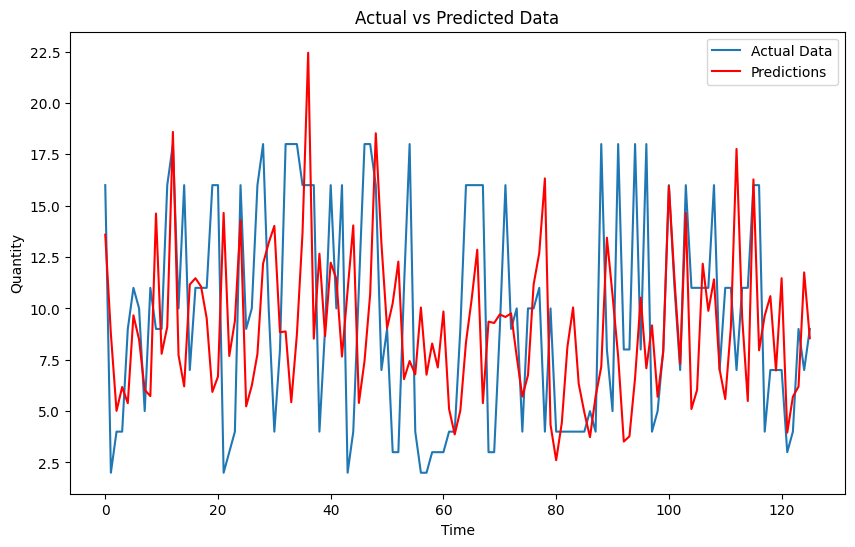

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
import pmdarima as pm

# Encode categorical variables and separate features/target
df_encoded = pd.get_dummies(df2, drop_first=True)  # Convert strings to one-hot encoding, drop first category
features = df_encoded.drop('Quantity', axis=1).values  # Features excluding 'Quantity'
target_variable = df_encoded['Quantity'].values  # Target variable 'Quantity'

# Split into train/test sets
train_size = int(len(target_variable) * 0.8)
train_data = pd.Series(df2['Quantity'][:train_size]).fillna(method='ffill')
test_data = pd.Series(df2['Quantity'][train_size:]).fillna(method='ffill')

# Apply Box-Cox transformation
train_data_transformed, lmbda = boxcox(train_data + 1)  # Add 1 to avoid zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with transformed train data
history = list(train_data_transformed)
predictions = []

# Automatically discover the best SARIMA parameters
auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1,
                           max_p=5, max_q=5, seasonal=True, m=12, stepwise=True,
                           seasonal_test='ch', start_P=0, start_Q=0, D=1)
p, d, q = auto_model.order
P, D, Q, m = auto_model.seasonal_order

print(f"Optimal orders - p: {p}, d: {d}, q: {q}, P: {P}, D: {D}, Q: {Q}, m: {m}")

# Rolling forecast for each test point
for t in range(len(test_data_transformed)):
    model = SARIMAX(history, order=(p, d, q), seasonal_order=(P, D, Q, m))
    model_fit = model.fit(disp=False)

    # Make forecast and store prediction
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)

    # Rolling update with the true test observation
    history.append(test_data_transformed[t])

# Convert predictions to numpy array
predictions = np.array(predictions)

# Inverse Box-Cox transformation to obtain original scale
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Calculate evaluation metrics
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

# Plot actual vs. predicted data
plt.figure(figsize=(10, 6))
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.title('Actual vs Predicted Data')
plt.show()


In [ ]:
df_encoded = pd.get_dummies(dfCopy, drop_first=True)  # Converts strings to one-hot and drops the first category to avoid multicollinearity

# Extract 'Quantity' as the target variable and the rest as exogenous features
target_variable = df_encoded['Quantity'].values
exogenous_features = df_encoded.drop('Quantity', axis=1).values  # Drop target variable 'Quantity'

# Split the data into train and test sets
train_size = int(len(target_variable) * 0.8)

train_data = pd.Series(dfCopy['Quantity'][:train_size])
test_data = pd.Series(dfCopy['Quantity'][train_size:])

# Split exogenous features into train and test sets
exog_train = exogenous_features[:train_size, :]
exog_test = exogenous_features[train_size:, :]

# Handle missing values
train_data = train_data.fillna(method='ffill')
test_data = test_data.fillna(method='ffill')

# Check for missing values and fill with np.nan_to_num (for numpy arrays)
train_data_sample = np.nan_to_num(train_data, nan=0.0)  # Replace NaNs with 0
exog_train_sample = np.nan_to_num(exog_train, nan=0.0)  # Replace NaNs with 0

test_data_sample = np.nan_to_num(test_data, nan=0.0)  # Replace NaNs with 0
exog_test_sample = np.nan_to_num(exog_test, nan=0.0)  # Replace NaNs with 0

# Initialize history and exogenous history for rolling forecast
history = list(train_data_sample)
history_exog = exog_train_sample.tolist()

predictions = []

p, d, q = 4, 0, 0
P, D, Q, m = 2, 1, 0, 12

# Perform a rolling forecast on a small dataset
for t in range(min(len(test_data_sample), 10)):  # Test on only 10 points initially
    # Ensure exogenous variables are properly reshaped
    exog_train_reshaped = np.array(history_exog).reshape(len(history_exog), -1)

    # Fit the SARIMAX model with exogenous variables
    model = SARIMAX(history, exog=exog_train_reshaped, order=(p, d, q), seasonal_order=(P, D, Q, m))

    try:
        # Fit the model with limited iterations
        model_fit = model.fit(disp=False, maxiter=50, method='powell')
    except ValueError as e:
        print(f"Error occurred during model fitting: {e}")
        break

    # Forecast with reshaped exogenous test data
    exog_test_reshaped = exog_test_sample[t].reshape(1, -1)
    yhat = model_fit.forecast(exog=exog_test_reshaped)[0]
    predictions.append(yhat)

    # Append the true observation and exogenous variables to history
    history.append(test_data_sample[t])
    history_exog.append(exog_test_sample[t])

# Calculate evaluation metrics
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

# Plot actual vs. predicted data
plt.figure(figsize=(10, 6))
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.title('Actual vs Predicted Data')
plt.show()


<ipython-input-96-d71fe2d0f021>:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = train_data.fillna(method='ffill')
<ipython-input-96-d71fe2d0f021>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data = test_data.fillna(method='ffill')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1321
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0406
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0162
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0106
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0063
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


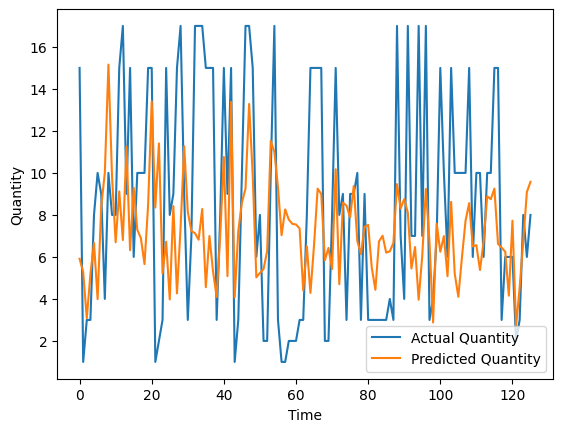

Mean Squared Error: 26.455240133877655
Root Mean Squared Error: 5.143465770652863


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df2, drop_first=True)

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for RNN (samples, time steps, features)
train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))

# 2. Model Building

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_features, train_target, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(test_target, predictions)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1518
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0231 
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040  
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


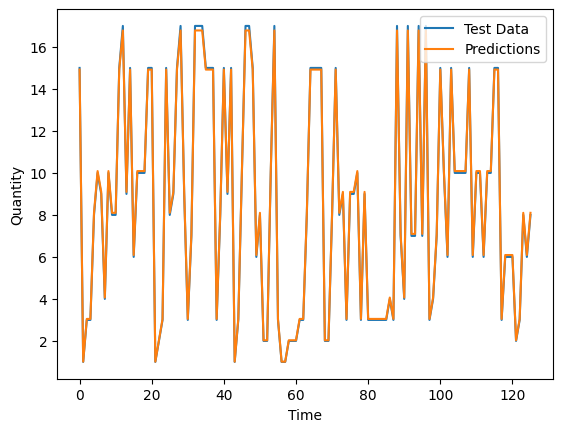

Mean Squared Error: 0.009794646545722346
Root Mean Squared Error: 0.09896790664514607


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Extract the 'Quantity' column as the target variable
target_variable = df2['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape input data to be 3D (samples, time steps, features) for RNN input
train_data = np.reshape(train_data, (train_data.shape[0], 1, 1))
test_data = np.reshape(test_data, (test_data.shape[0], 1, 1))

# 2. Model Building

# Create the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, scaled_target[:train_size], epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data_original = scaler.inverse_transform(scaled_target[train_size:])

# Plot the predictions and test data
plt.plot(test_data_original, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

# Calculate the mean squared error
mse = mean_squared_error(test_data_original, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


In [ ]:
df2

id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
0         10077086      -27.433461      -48.397987  2017-08-03  04:00:00   
1         10083288      -27.612825      -48.527746  2017-11-24  12:38:00   
2         10082420      -27.684391      -48.553840  2017-11-09  15:46:00   
3         10082354      -27.566806      -48.515430  2017-11-08  18:55:00   
4         10068370      -27.591457      -48.536355  2017-03-04  21:53:00   
..             ...             ...             ...         ...       ...   
622       10137822      -27.441516      -48.402242  2021-01-13  08:36:44   
623       10137648      -27.574695      -48.433085  2021-01-09  14:54:18   
624       10137748      -27.596848      -48.522426  2021-01-11  16:09:36   
625       10137866      -27.676447      -48.501797  2021-01-14  13:31:02   
626       10137885      -27.593763      -48.573022  2021-01-14  19:55:21   

     Hour  Year  Month  Day Classe_Bacias  ...  \
0       4  2017      8    3          Alta  ...   
1      12  2017     11   24         Baixa  ...   
2      15  2017     11    9          Alta  ...   
3      18  2017     11    8          Alta  ...   
4      21  2017      3    4         Baixa  ...   
..    ...   ...    ...  ...           ...  ...   
622     8  2021      1   13          Alta  ...   
623    14  2021      1    9         Baixa  ...   
624    16  2021      1   11         Baixa  ...   
625    13  2021      1   14          Alta  ...   
626    19  2021      1   14         Baixa  ...   

    TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)  \
0                                               16,8   
1                                               16,2   
2                                               17,6   
3                                               16,8   
4                                               22,4   
..                                               ...   
622                                             21,2   
623                                             17,1   
624                                               22   
625                                             18,6   
626                                             18,2   

     UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)  \
0                                        92.0   
1                                        65.0   
2                                        71.0   
3                                        76.0   
4                                        86.0   
..                                        ...   
622                                      84.0   
623                                      60.0   
624                                      67.0   
625                                      80.0   
626                                      80.0   

     UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  \
0                                        90.0   
1                                        60.0   
2                                        63.0   
3                                        72.0   
4                                        82.0   
..                                        ...   
622                                      77.0   
623                                      42.0   
624                                      62.0   
625                                      77.0   
626                                      73.0   

     UMIDADE RELATIVA DO AR, HORARIA (%)  \
0                                   92.0   
1                                   61.0   
2                                   66.0   
3                                   72.0   
4                                   84.0   
..                                   ...   
622                                 84.0   
623                                 45.0   
624                                 65.0   
625                                 80.0   
626                                 74.0   

     VENTO, DIREÇÃO HORARIA (gr) (° (gr)) VENTO, RAJADA MAXIMA (m/s)  \
0                                   193

In [ ]:
# prompt: show every collumn on df2

df2.columns

Index(['id_ocorrencia', 'lat_ocorrencia', 'lon_ocorrencia', 'Dates', 'Time',
       'Hour', 'Year', 'Month', 'Day', 'Classe_Bacias', 'Classe_Movimento',
       'regiao', 'Quantity', 'Projected_X', 'Projected_Y',
       'Classe_Suscetibilidade', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 'VENTO, RAJADA MA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm


#train_data_transformed = np.log1p(train_data)  # log(1 + x) to handle 0 values
#test_data_transformed = np.log1p(test_data)

# If you want to use Box-Cox transformation instead:
train_data_transformed, lmbda = boxcox(train_data + 1)  # Adding 1 to avoid issues with zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data
history = [x for x in train_data_transformed]
predictions = []

# Automatically discover the best p, d, q values using transformed data
auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1, max_p=5, max_q=5, d=0, seasonal=False, stepwise=True)
p, d, q = auto_model.order  # Extract best p, d, q parameters from Auto-ARIMA

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the ARIMA model on the rolling history
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the transformation (log to original scale)
#predictions = np.expm1(predictions)  # Inverse log(1+x) -> exp(x)-1
#test_data_original = np.expm1(test_data_transformed)

# If using Box-Cox:
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


KeyboardInterrupt: 

SC LSTM


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - loss: 0.0098
Epoch 2/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 7.4503e-04
Epoch 3/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 3.8417e-04
Epoch 4/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - loss: 2.8751e-04
Epoch 5/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - loss: 2.8051e-04
Epoch 6/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - loss: 2.1813e-04
Epoch 7/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 2.2610e-04
Epoch 8/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 2.2763e-04
Epoch 9/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 2.0229e-04
Epoch 10/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 1.7177e-04
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


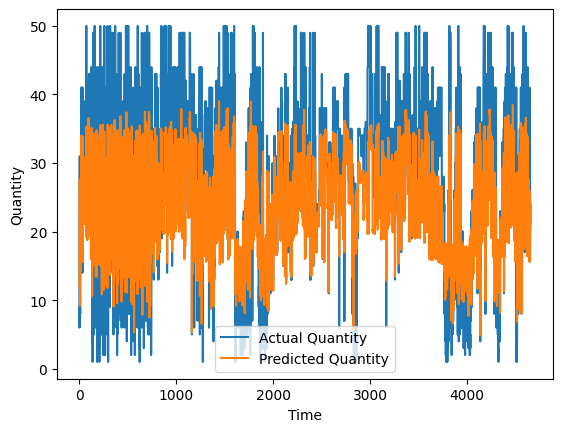

Mean Squared Error: 63.72924465925373
Root Mean Squared Error: 7.983059855672744


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df, drop_first=True)  # Converts strings to one-hot and drops the first category to avoid multicollinearity

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for LSTM (samples, time steps, features)
train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))

# 2. Model Building

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_features, train_target, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(test_target, predictions)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


583/583 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0084
Epoch 2/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.2314e-04
Epoch 3/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.6738e-05
Epoch 4/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.1319e-05
Epoch 5/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.4927e-05
Epoch 6/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.1044e-05
Epoch 7/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.3933e-05
Epoch 8/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.3187e-05
Epoch 9/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.6519e-05
Epoch 10/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.9709e-05
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


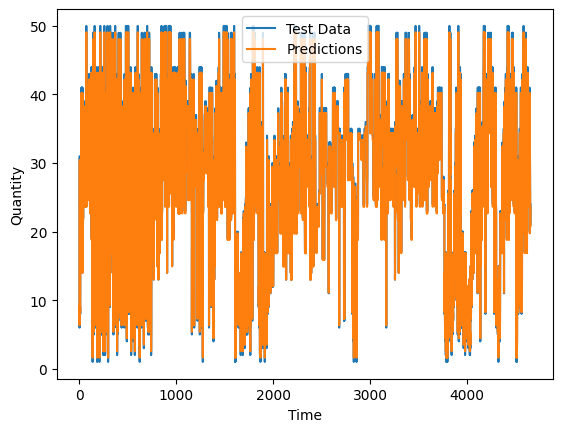

Mean Squared Error: 0.3109023622933149
Root Mean Squared Error: 0.5575861927032582


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Extract the 'Quantity' column as the target variable
target_variable = df['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape input data to be 3D (samples, time steps, features) for RNN input
train_data = np.reshape(train_data, (train_data.shape[0], 1, 1))
test_data = np.reshape(test_data, (test_data.shape[0], 1, 1))

# 2. Model Building

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, scaled_target[:train_size], epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data_original = scaler.inverse_transform(scaled_target[train_size:])

# Plot the predictions and test data
plt.plot(test_data_original, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

# Calculate the mean squared error
mse = mean_squared_error(test_data_original, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


Simple RNN SC

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0074
Epoch 2/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0014
Epoch 3/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 6.5845e-04
Epoch 4/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 5.4529e-04
Epoch 5/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 4.6935e-04
Epoch 6/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 3.8865e-04
Epoch 7/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.8874e-04
Epoch 8/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 3.3751e-04
Epoch 9/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.9517e-04
Epoch 10/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 2.8667e-04
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


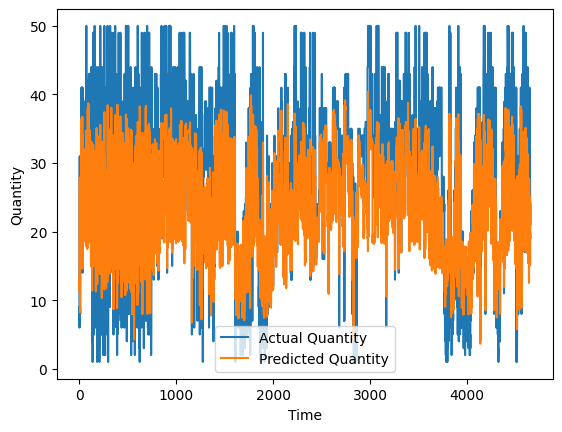

Mean Squared Error: 69.38176930653069
Root Mean Squared Error: 8.329571976190055


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df, drop_first=True)

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for RNN (samples, time steps, features)
train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))

# 2. Model Building

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_features, train_target, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(test_target, predictions)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


SC RNN Target

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


583/583 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0012
Epoch 2/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0311e-04
Epoch 3/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.7885e-05
Epoch 4/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.5171e-05
Epoch 5/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8985e-05
Epoch 6/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.5444e-05
Epoch 7/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.3211e-05
Epoch 8/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.7399e-05
Epoch 9/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.2581e-05
Epoch 10/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.3606e-05
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


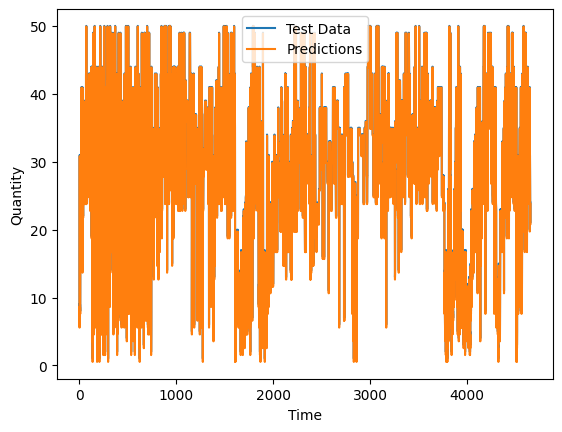

Mean Squared Error: 0.05545448265348045
Root Mean Squared Error: 0.23548775478457568


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Extract the 'Quantity' column as the target variable
target_variable = df['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape input data to be 3D (samples, time steps, features) for RNN input
train_data = np.reshape(train_data, (train_data.shape[0], 1, 1))
test_data = np.reshape(test_data, (test_data.shape[0], 1, 1))

# 2. Model Building

# Create the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, scaled_target[:train_size], epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data_original = scaler.inverse_transform(scaled_target[train_size:])

# Plot the predictions and test data
plt.plot(test_data_original, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

# Calculate the mean squared error
mse = mean_squared_error(test_data_original, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


SC LSTM TArget

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


583/583 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0093
Epoch 2/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.1866e-04
Epoch 3/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.6842e-05
Epoch 4/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.6259e-05
Epoch 5/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.9950e-05
Epoch 6/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5.7135e-05
Epoch 7/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.6601e-05
Epoch 8/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.9141e-05
Epoch 9/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.4007e-05
Epoch 10/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.7833e-05
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


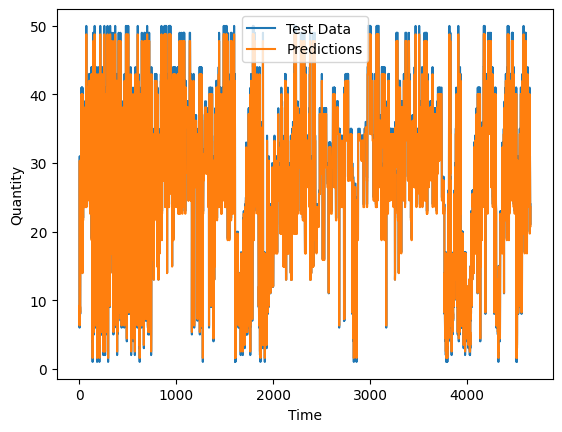

Mean Squared Error: 0.4426069199802387
Root Mean Squared Error: 0.6652870959069015


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Extract the 'Quantity' column as the target variable
target_variable = df['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# 2. Model Building

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, train_data, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data = scaler.inverse_transform(test_data)

# Plot the predictions and test data
plt.plot(test_data, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

# Calculate the mean squared error
mse = mean_squared_error(test_data, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

In [ ]:
df

id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
44            40045445      -28.684659      -49.388056  2017-05-20  16:40:00   
59           130041858      -27.146564      -48.505497  2017-10-23  17:14:00   
64            40046947      -28.679681      -49.364891  2017-06-29  20:37:00   
88           130041869      -27.153351      -48.484377  2017-10-24  10:38:00   
120          130041884      -27.034795      -48.669560  2017-10-24  16:34:00   
...                ...             ...             ...         ...       ...   
1927109       80117658      -28.070704      -48.622803  2021-01-13  13:18:04   
1927210       80117841      -28.026137      -48.615941  2021-01-17  10:10:51   
1927242       20110446      -27.444620      -51.245612  2020-08-28  08:03:08   
1927250       20110449      -27.392914      -51.218675  2020-08-28  10:55:02   
1927337       20110484      -27.155513      -50.908091  2020-08-29  01:19:20   

         Hour  Year  Month  Day  Quantity  
44         16  2017      5   20        16  
59         17  2017     10   23        24  
64         20  2017      6   29        21  
88         10  2017     10   24        17  
120        16  2017     10   24        17  
...       ...   ...    ...  ...       ...  
1927109    13  2021      1   13        31  
1927210    10  2021      1   17        28  
1927242     8  2020      8   28        21  
1927250    10  2020      8   28        21  
1927337     1  2020      8   29        24  

[23285 rows x 10 columns]

In [ ]:
# prompt: check if df dataframe has id_ocorrencia duplicated

df.duplicated(subset=['id_ocorrencia']).sum()

0

In [91]:
df_sorted = df.sort_values(by=['Dates', 'Time'])

In [ ]:
df2_sorted = df2.sort_values(by=['Dates', 'Time'])

In [ ]:
df3_sorted = df3.sort_values(by=['Dates', 'Time'])

In [ ]:
df2_sorted

id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
91        10064414      -27.447496      -48.425808  2017-01-04  09:11:00   
93        10064717      -27.455293      -48.380926  2017-01-09  08:57:00   
92        10064915      -27.596752      -48.574580  2017-01-12  14:07:00   
21        10065157      -27.467694      -48.446634  2017-01-16  08:22:00   
201       10065272      -27.601925      -48.512678  2017-01-17  20:11:00   
..             ...             ...             ...         ...       ...   
626       10137885      -27.593763      -48.573022  2021-01-14  19:55:21   
505       10137890      -27.589377      -48.550147  2021-01-14  22:30:11   
540       10137909      -27.535046      -48.511553  2021-01-15  11:40:53   
523       10137954      -27.415774      -48.425837  2021-01-16  12:20:57   
510       10138032      -27.597699      -48.565381  2021-01-17  20:27:40   

     Hour  Year  Month  Day PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  ...  \
91      9  2017      1    4                                0  ...   
93      8  2017      1    9                                0  ...   
92     14  2017      1   12                                0  ...   
21      8  2017      1   16                                0  ...   
201    20  2017      1   17                              1,8  ...   
..    ...   ...    ...  ...                              ...  ...   
626    19  2021      1   14                                0  ...   
505    22  2021      1   14                                0  ...   
540    11  2021      1   15                              2,6  ...   
523    12  2021      1   16                                0  ...   
510    20  2021      1   17                              2,2  ...   

    UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)  \
91                                      88.0   
93                                      90.0   
92                                      68.0   
21                                      88.0   
201                                     77.0   
..                                       ...   
626                                     80.0   
505                                     87.0   
540                                     91.0   
523                                     75.0   
510                                     82.0   

    UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  \
91                                      86.0   
93                                      89.0   
92                                      60.0   
21                                      86.0   
201                                     62.0   
..                                       ...   
626                                     73.0   
505                                     85.0   
540                                     90.0   
523                                     69.0   
510                                     72.0   

    UMIDADE RELATIVA DO AR, HORARIA (%) VENTO, DIREÇÃO HORARIA (gr) (° (gr))  \
91                                 87.0                                310.0   
93                                 90.0                                337.0   
92                                 63.0                                145.0   
21                                 88.0                                274.0   
201                                77.0                                181.0   
..                                  ...                                  ...   
626                                74.0                                157.0   
505                                87.0                                159.0   
540                                90.0                                172.0   
523                                72.0                                 10.0   
510                                82.0                                 13.0   

    VENTO, RAJADA MAXIMA (m/s) VENTO, VELOCIDADE HORARIA (m/s)    DatesNew  \
91                         2,9                             0,5  2017-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0098
Epoch 2/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0708e-04
Epoch 3/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.9229e-05
Epoch 4/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 6.4648e-05
Epoch 5/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 6.6897e-05
Epoch 6/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5.4014e-05
Epoch 7/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 5.8762e-05
Epoch 8/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.8648e-05
Epoch 9/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.8183e-05
Epoch 10/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.3543e-05
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


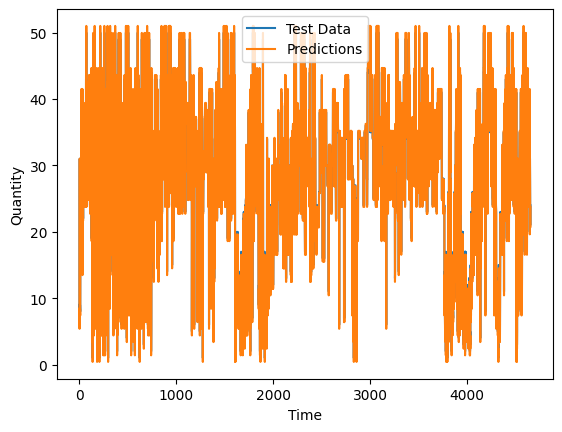

Mean Squared Error: 0.17227983077274983
Root Mean Squared Error: 0.4150660559148987


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Extract the 'Quantity' column as the target variable
target_variable = df['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# 2. Model Building

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, train_data, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data = scaler.inverse_transform(test_data)

# Plot the predictions and test data
plt.plot(test_data, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

# Calculate the mean squared error
mse = mean_squared_error(test_data, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0077
Epoch 2/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0013
Epoch 3/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 5.6033e-04
Epoch 4/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 5.1524e-04
Epoch 5/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 4.3400e-04
Epoch 6/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 4.9125e-04
Epoch 7/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 4.2875e-04
Epoch 8/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 3.6534e-04
Epoch 9/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 3.6221e-04
Epoch 10/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 2.8326e-04
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


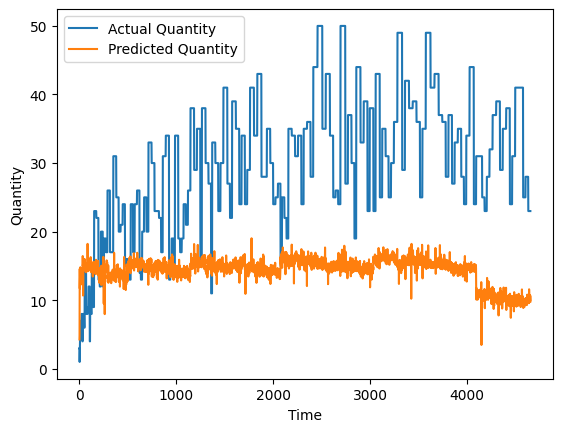

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df_sorted, drop_first=True)

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for RNN (samples, time steps, features)
train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))

# 2. Model Building

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_features, train_target, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(test_target, predictions)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


In [ ]:
import pandas as pd

# Ensure 'Dates' is in datetime format
df_sorted['Dates'] = pd.to_datetime(df_sorted['Dates'])

# Convert 'Time' column to a timedelta by converting it to a string first
df_sorted['Time'] = pd.to_timedelta(df_sorted['Time'].astype(str))

# Combine 'Dates' and 'Time' into a single 'Datetime' column
df_sorted['Datetime'] = df_sorted['Dates'] + df_sorted['Time']

# Set the new 'Datetime' column as the index
df_sorted.set_index('Datetime', inplace=True)

# Optionally, drop the original 'Dates' and 'Time' columns
df_sorted.drop(columns=['Dates', 'Time'], inplace=True)

# The DataFrame is now indexed by combined date and time


In [ ]:
df_sorted

id_ocorrencia  lat_ocorrencia  lon_ocorrencia  Hour  \
Datetime                                                                   
2017-01-01 00:47:00       30033855      -26.811298      -49.089642     0   
2017-01-01 08:49:00       30033860      -26.931668      -48.940209     8   
2017-01-01 10:08:00       20056421      -27.058718      -50.896902    10   
2017-01-01 10:12:00       30033862      -26.875069      -49.112146    10   
2017-01-01 14:04:00       40039794      -28.682715      -49.365377    14   
...                            ...             ...             ...   ...   
2021-01-18 20:02:53       30085005      -27.151188      -48.958058    20   
2021-01-18 20:46:05      130091420      -27.124377      -48.605054    20   
2021-01-18 21:19:58       30085007      -27.139926      -48.959814    21   
2021-01-18 21:55:12      130091424      -26.898541      -48.692159    21   
2021-01-18 23:02:31       80117897      -28.474519      -49.010571    23   

                     Year  Month  Day  Quantity  
Datetime                                         
2017-01-01 00:47:00  2017      1    1        10  
2017-01-01 08:49:00  2017      1    1        10  
2017-01-01 10:08:00  2017      1    1        10  
2017-01-01 10:12:00  2017      1    1        10  
2017-01-01 14:04:00  2017      1    1        10  
...                   ...    ...  ...       ...  
2021-01-18 20:02:53  2021      1   18        23  
2021-01-18 20:46:05  2021      1   18        23  
2021-01-18 21:19:58  2021      1   18        23  
2021-01-18 21:55:12  2021      1   18        23  
2021-01-18 23:02:31  2021      1   18        23  

[23285 rows x 8 columns]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0432
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0078
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0066
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0059
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0058
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0056
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0054
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0053
Epoch 9/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0054
Epoch 10/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0055
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


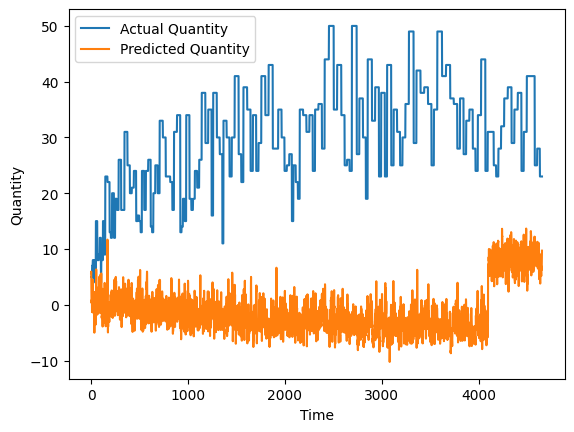

Mean Squared Error: 1110.3141217423145
Root Mean Squared Error: 33.321376348259


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df_sorted, drop_first=True)

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for RNN with 5 time steps
def create_sequences(features, target, time_steps=5):
    x, y = [], []
    for i in range(len(features) - time_steps):
        x.append(features[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(x), np.array(y)

train_features, train_target = create_sequences(train_features, train_target, time_steps=5)
test_features, test_target = create_sequences(test_features, test_target, time_steps=5)

# 2. Model Building

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_features, train_target, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(test_target, predictions)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.6041 - val_loss: 2.9149
Epoch 2/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.3977 - val_loss: 3.2706
Epoch 3/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.3585 - val_loss: 2.8715
Epoch 4/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.3437 - val_loss: 3.2547
Epoch 5/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.3025 - val_loss: 3.4005
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2803 - val_loss: 3.9546
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2943 - val_loss: 3.3349
Epoch 8/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.2723 - val_loss: 3.2830
Epoch 9/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.2629 - val_loss: 3.4202
Epoch 10/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2384 - val_loss: 3.3724
Epoch 11/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2411 - val_loss: 3.6081
Epoch 12/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms

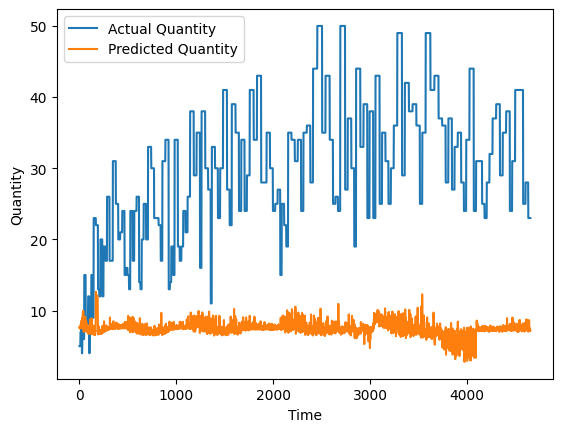

Mean Squared Error: 621.7776517670594
Root Mean Squared Error: 24.935469752283783


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df_sorted, drop_first=True)

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately using RobustScaler
scaler_features = RobustScaler()
scaled_features = scaler_features.fit_transform(features)

scaler_target = RobustScaler()
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for RNN with 5 time steps
def create_sequences(features, target, time_steps=5):
    x, y = [], []
    for i in range(len(features) - time_steps):
        x.append(features[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(x), np.array(y)

train_features, train_target = create_sequences(train_features, train_target, time_steps=5)
test_features, test_target = create_sequences(test_features, test_target, time_steps=5)

# 2. Model Building

# Build the RNN model with increased depth and epochs
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))

# Add additional RNN layers
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Increase the number of epochs to 50 for better learning
history = model.fit(train_features, train_target, epochs=50, batch_size=32, validation_data=(test_features, test_target))

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(test_target, predictions)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0729 - val_loss: 0.0311
Epoch 2/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0087 - val_loss: 0.0300
Epoch 3/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0074 - val_loss: 0.0664
Epoch 4/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0071 - val_loss: 0.0609
Epoch 5/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0067 - val_loss: 0.0589
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0062 - val_loss: 0.0464
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0058 - val_loss: 0.0678
Epoch 8/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0058 - val_loss: 0.0633
Epoch 9/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0055 - val_loss: 0.0680
Epoch 10/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0054 - val_loss: 0.0667
Epoch 11/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0051 - val_loss: 0.0711
Epoch 12/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.

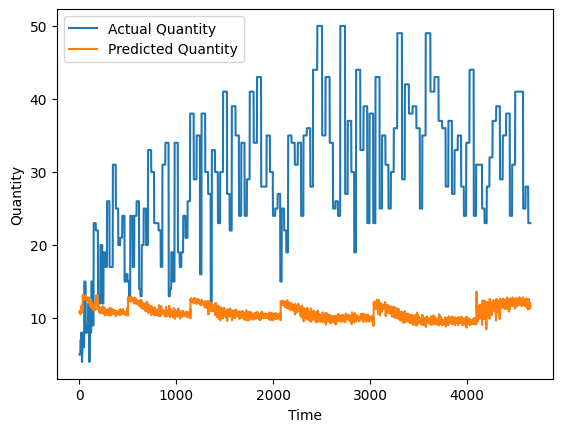

Mean Squared Error: 484.36620797389463
Root Mean Squared Error: 22.00832133475642


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df_sorted, drop_first=True)

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately using MinMaxScaler
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for RNN with 5 time steps
def create_sequences(features, target, time_steps=5):
    x, y = [], []
    for i in range(len(features) - time_steps):
        x.append(features[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(x), np.array(y)

train_features, train_target = create_sequences(train_features, train_target, time_steps=5)
test_features, test_target = create_sequences(test_features, test_target, time_steps=5)

# 2. Model Building

# Build the RNN model with increased depth and epochs
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))

# Add additional RNN layers
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_features, train_target, epochs=50, batch_size=32, validation_data=(test_features, test_target))

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(test_target, predictions)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df, drop_first=True)

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately using MinMaxScaler
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for RNN with 5 time steps
def create_sequences(features, target, time_steps=5):
    x, y = [], []
    for i in range(len(features) - time_steps):
        x.append(features[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(x), np.array(y)

train_features, train_target = create_sequences(train_features, train_target, time_steps=5)
test_features, test_target = create_sequences(test_features, test_target, time_steps=5)

# 2. Model Building

# Build the RNN model with increased depth and epochs
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))

# Add additional RNN layers
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_features, train_target, epochs=50, batch_size=32, validation_data=(test_features, test_target))

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(test_target, predictions)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0060
Epoch 2/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0015
Epoch 3/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 6.4220e-04
Epoch 4/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 4.8342e-04
Epoch 5/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 3.8257e-04
Epoch 6/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 3.6332e-04
Epoch 7/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 3.3730e-04
Epoch 8/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 3.9004e-04
Epoch 9/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 2.8945e-04
Epoch 10/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 2.9694e-04
Epoch 11/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 3.0659e-04
Epoch 12/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 2.8234e-04
Epoch 13/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.5072e-04
Epoch 14/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - los

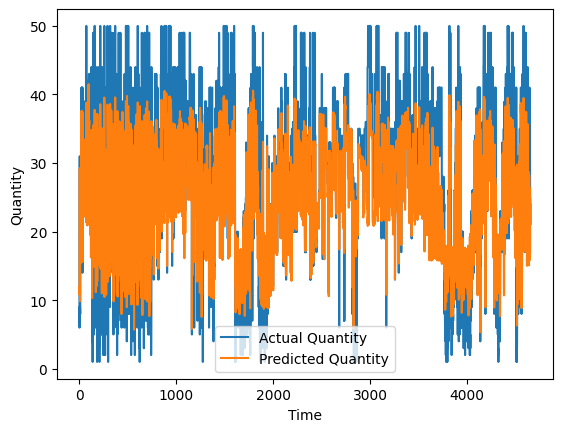

Mean Squared Error: 47.93833544304833
Root Mean Squared Error: 6.92375154400043


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df, drop_first=True)

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for RNN (samples, time steps, features)
train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))

# 2. Model Building

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_features, train_target, epochs=50, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(test_target, predictions)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


583/583 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0011
Epoch 2/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0953e-04
Epoch 3/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.3772e-05
Epoch 4/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.8477e-05
Epoch 5/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.5390e-05
Epoch 6/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.6820e-05
Epoch 7/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3460e-05
Epoch 8/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.9207e-05
Epoch 9/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.1640e-05
Epoch 10/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.7741e-05
Epoch 11/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.3767e-05
Epoch 12/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.4243e-05
Epoch 13/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.2041e-05
Epoch 14/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.5415e-04
Epoch 15/50
583/

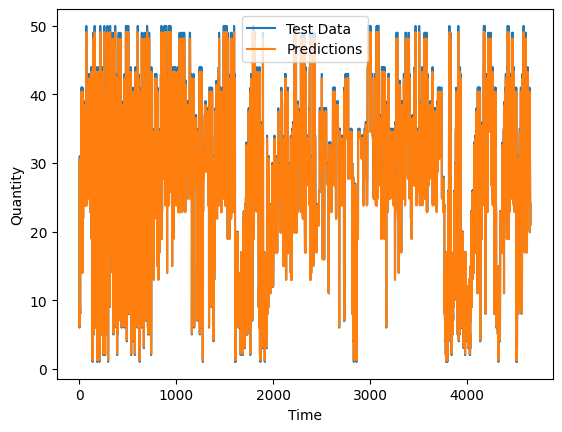

Mean Squared Error: 0.15795902874896836
Root Mean Squared Error: 0.397440597761437


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Extract the 'Quantity' column as the target variable
target_variable = df['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape input data to be 3D (samples, time steps, features) for RNN input
train_data = np.reshape(train_data, (train_data.shape[0], 1, 1))
test_data = np.reshape(test_data, (test_data.shape[0], 1, 1))

# 2. Model Building

# Create the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, scaled_target[:train_size], epochs=50, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data_original = scaler.inverse_transform(scaled_target[train_size:])

# Plot the predictions and test data
plt.plot(test_data_original, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

# Calculate the mean squared error
mse = mean_squared_error(test_data_original, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm


#train_data_transformed = np.log1p(train_data)  # log(1 + x) to handle 0 values
#test_data_transformed = np.log1p(test_data)

# If you want to use Box-Cox transformation instead:
train_data_transformed, lmbda = boxcox(train_data + 1)  # Adding 1 to avoid issues with zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data
history = [x for x in train_data_transformed]
predictions = []

# Automatically discover the best p, d, q values using transformed data
auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1, max_p=5, max_q=5, d=0, seasonal=False, stepwise=True)
p, d, q = auto_model.order  # Extract best p, d, q parameters from Auto-ARIMA

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the ARIMA model on the rolling history
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the transformation (log to original scale)
#predictions = np.expm1(predictions)  # Inverse log(1+x) -> exp(x)-1
#test_data_original = np.expm1(test_data_transformed)

# If using Box-Cox:
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0658
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0262
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


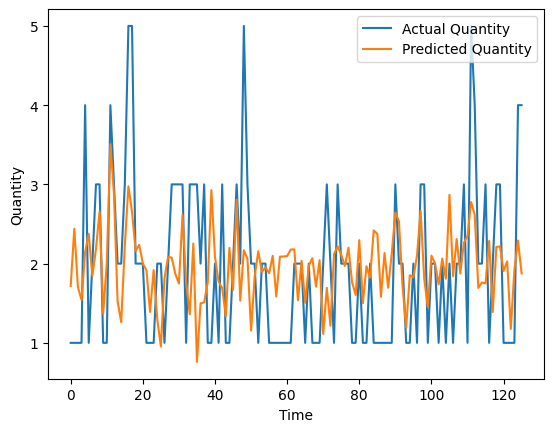

Mean Squared Error: 0.9307259729105356
Root Mean Squared Error: 0.9647414020920506


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df2, drop_first=True)

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for RNN (samples, time steps, features)
train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))

# 2. Model Building

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_features, train_target, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(test_target, predictions)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0421
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018     
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1340e-04 
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9979e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


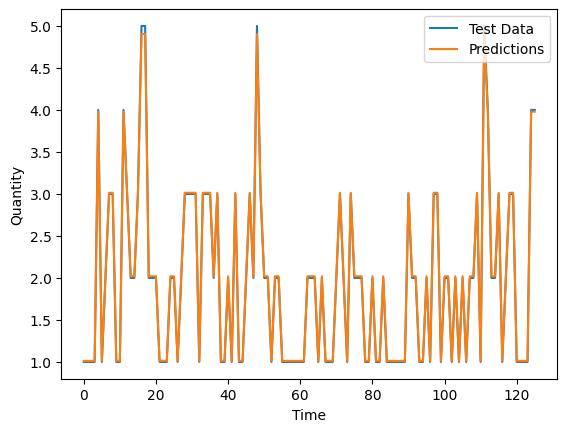

Mean Squared Error: 0.0005440536757681607
Root Mean Squared Error: 0.023324958215785955


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Extract the 'Quantity' column as the target variable
target_variable = df2['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape input data to be 3D (samples, time steps, features) for RNN input
train_data = np.reshape(train_data, (train_data.shape[0], 1, 1))
test_data = np.reshape(test_data, (test_data.shape[0], 1, 1))

# 2. Model Building

# Create the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, scaled_target[:train_size], epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data_original = scaler.inverse_transform(scaled_target[train_size:])

# Plot the predictions and test data
plt.plot(test_data_original, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

# Calculate the mean squared error
mse = mean_squared_error(test_data_original, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


<ipython-input-52-d36870b9be0b>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = pd.Series(df['Quantity'][:train_size]).fillna(method='ffill')
<ipython-input-52-d36870b9be0b>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data = pd.Series(df['Quantity'][train_size:]).fillna(method='ffill')


Mean Squared Error: 205.56565960731209
Root Mean Squared Error: 14.337561145721823
Mean Absolute Error: 12.331442274958384
Mean Absolute Percentage Error: 0.5384205112232158


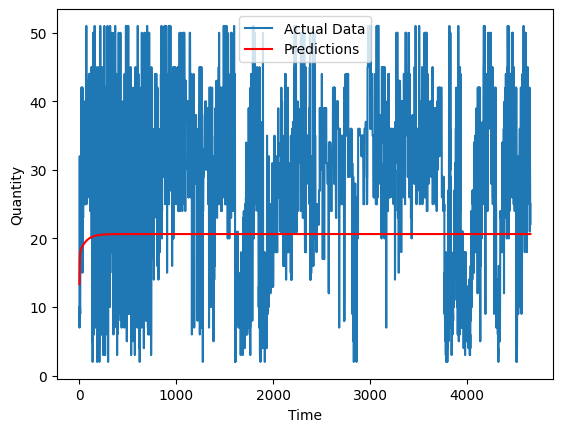

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm

# Encode categorical variables and separate features/target
df_encoded = pd.get_dummies(df, drop_first=True)  # Convert strings to one-hot encoding, drop first category
features = df_encoded.drop('Quantity', axis=1).values  # Features excluding 'Quantity'
target_variable = df_encoded['Quantity'].values  # Target variable 'Quantity'

# Split into train/test sets
train_size = int(len(target_variable) * 0.8)
train_data = pd.Series(df['Quantity'][:train_size]).fillna(method='ffill')
test_data = pd.Series(df['Quantity'][train_size:]).fillna(method='ffill')

# Assuming train_data and test_data are already defined
# Apply Box-Cox transformation to handle 0 values, adding 1 to avoid issues with zero values
train_data_transformed, lmbda = boxcox(train_data + 1)
test_data_transformed = boxcox(test_data + 1, lmbda)

# Automatically find the best p, d, q values using the transformed training data
auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1, max_p=5, max_q=5, d=0, seasonal=False, stepwise=True)
p, d, q = auto_model.order  # Extract best parameters from Auto-ARIMA

# Fit the ARIMA model once on the entire transformed training data
model = ARIMA(train_data_transformed, order=(p, d, q))
model_fit = model.fit()

# Forecast for the entire test data period
forecast = model_fit.forecast(steps=len(test_data_transformed))

# Convert the forecasted values back to the original scale
predictions = (forecast * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the model performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm


#train_data_transformed = np.log1p(train_data)  # log(1 + x) to handle 0 values
#test_data_transformed = np.log1p(test_data)

# Encode categorical variables and separate features/target
df_encoded = pd.get_dummies(df, drop_first=True)  # Convert strings to one-hot encoding, drop first category
features = df_encoded.drop('Quantity', axis=1).values  # Features excluding 'Quantity'
target_variable = df_encoded['Quantity'].values  # Target variable 'Quantity'

# Split into train/test sets
train_size = int(len(target_variable) * 0.8)
train_data = pd.Series(df['Quantity'][:train_size]).fillna(method='ffill')
test_data = pd.Series(df['Quantity'][train_size:]).fillna(method='ffill')


# If you want to use Box-Cox transformation instead:
train_data_transformed, lmbda = boxcox(train_data + 1)  # Adding 1 to avoid issues with zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data
history = [x for x in train_data_transformed]
predictions = []

# Automatically discover the best p, d, q values using transformed data
auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1, max_p=5, max_q=5, d=0, seasonal=False, stepwise=True)
p, d, q = auto_model.order  # Extract best p, d, q parameters from Auto-ARIMA

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the ARIMA model on the rolling history
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the transformation (log to original scale)
#predictions = np.expm1(predictions)  # Inverse log(1+x) -> exp(x)-1
#test_data_original = np.expm1(test_data_transformed)

# If using Box-Cox:
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


<ipython-input-55-48b4cf212c05>:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = pd.Series(df['Quantity'][:train_size]).fillna(method='ffill')
<ipython-input-55-48b4cf212c05>:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data = pd.Series(df['Quantity'][train_size:]).fillna(method='ffill')


KeyboardInterrupt: 

In [ ]:
# Teste de estacionariedade (ADF)
result = adfuller(df['Quantity'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# Se o p-value for maior que 0.05, a série não é estacionária e precisa ser diferenciada
if result[1] > 0.05:
    print("Série não estacionária. Realizando diferenciação.")
    df['Quantity_diff'] = df['Quantity'].diff().dropna()
    df = df.dropna()  # Remover valores NaN após a diferenciação
else:
    print("Série já é estacionária.")


ADF Statistic: -12.418585973076638
p-value: 4.1862547204222425e-23
Série já é estacionária.


In [83]:
# Calcular a quantidade de ocorrências por data
df_quantity = df.groupby(['Year', 'Month', 'Day']).size().reset_index(name='Quantity')

# Agora, para cada registro no DataFrame original, junte com a quantidade de ocorrências do dia
df = pd.merge(df, df_quantity[['Year', 'Month', 'Day', 'Quantity']], on=['Year', 'Month', 'Day'], how='left')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.2730 - val_loss: 0.0278
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0317 - val_loss: 0.0300
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0235 - val_loss: 0.0267
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0206 - val_loss: 0.0262
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0183 - val_loss: 0.0264
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0174 - val_loss: 0.0264
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0163 - val_loss: 0.0255
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0161 - val_loss: 0.0269
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0163 - val_loss: 0.0269
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0172 - val_loss: 0.0255
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0191 - val_loss: 0.0269
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0173 - val_l

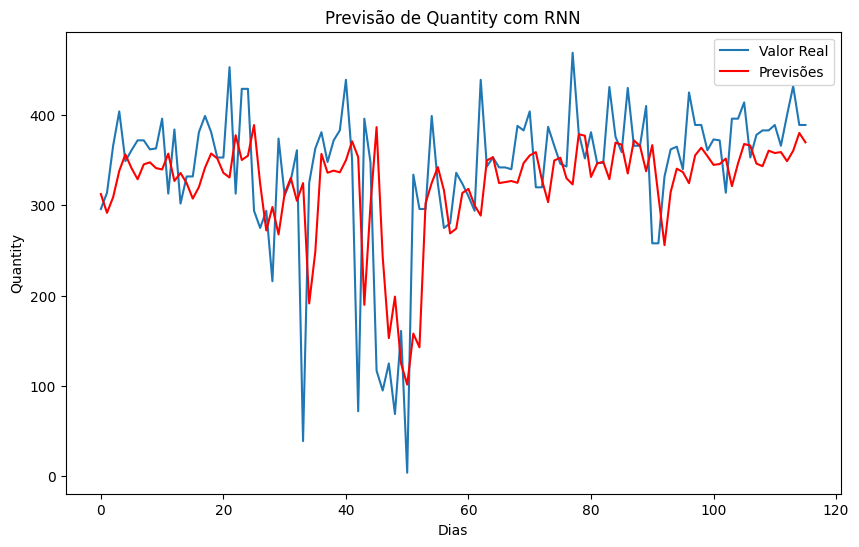

Mean Squared Error: 5877.305929894639
Root Mean Squared Error: 76.66358933610296
Mean Absolute Error: 52.32996105325633


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

# 1. Pré-processamento dos dados
# Supondo que o DataFrame 'df' já tenha sido calculado com a coluna 'Quantity'
# A coluna 'Quantity' deve ser o número total de ocorrências por dia, conforme explicado.

# Escalonamento da coluna 'Quantity' (normalização para o intervalo [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
dfCopy['Quantity_scaled'] = scaler.fit_transform(dfCopy[['Quantity']])

# 2. Criação de janelas de tempo
time_step = 10  # Número de passos de tempo a serem considerados para a predição

# Função para criar o dataset com janelas de tempo
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# Dividir em treino e teste
train_data, test_data = train_test_split(dfCopy['Quantity_scaled'], test_size=0.2, shuffle=False)

# Criar datasets de treinamento e teste
X_train, y_train = create_dataset(train_data.values, time_step)
X_test, y_test = create_dataset(test_data.values, time_step)

# Reformatar para o formato esperado pelo RNN (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Adicionando a dimensão 'features'
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 3. Criação do Modelo RNN
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(time_step, 1)))  # RNN com 50 unidades
model.add(Dense(1))  # Camada de saída com 1 unidade (previsão para o próximo valor)

# 4. Compilação do Modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Treinamento do Modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# 6. Realizando previsões
predictions = model.predict(X_test)

# Inversão da transformação para retornar ao valor original da 'Quantity'
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Avaliação do Modelo
# Plotando a previsão vs o valor real
plt.figure(figsize=(10,6))
plt.plot(y_test_original, label='Valor Real')
plt.plot(predictions, label='Previsões', color='red')
plt.title('Previsão de Quantity com RNN')
plt.xlabel('Dias')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 8. Cálculo das métricas de desempenho
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 0.0123 - val_loss: 0.0204
Epoch 2/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 0.0089 - val_loss: 0.0201
Epoch 3/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 65s 7ms/step - loss: 0.0088 - val_loss: 0.0205
Epoch 4/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.0087 - val_loss: 0.0200
Epoch 5/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 0.0088 - val_loss: 0.0199
Epoch 6/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 0.0089 - val_loss: 0.0201
Epoch 7/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 0.0087 - val_loss: 0.0201
Epoch 8/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 0.0087 - val_loss: 0.0202
Epoch 9/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 0.0087 - val_loss: 0.0199
Epoch 10/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - loss: 0.0087 - val_loss: 0.0203
Epoch 11/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 0.0086 - val_loss: 0.0200
Epoch 12/20
8824/88

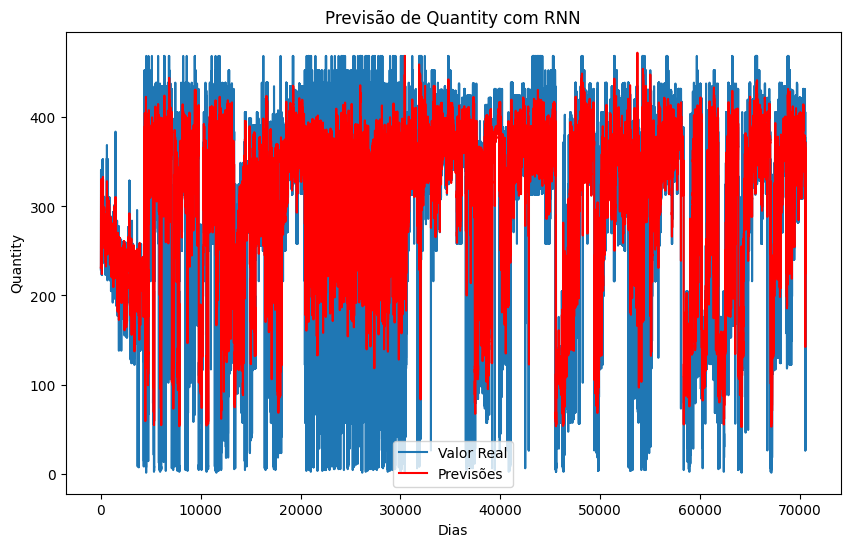

Mean Squared Error: 4359.335019297959
Root Mean Squared Error: 66.02526046368888
Mean Absolute Error: 40.17053013297553


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

# 1. Pré-processamento dos dados
# Supondo que o DataFrame 'df' já tenha sido calculado com a coluna 'Quantity'
# A coluna 'Quantity' deve ser o número total de ocorrências por dia, conforme explicado.

# Escalonamento da coluna 'Quantity' (normalização para o intervalo [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
df['Quantity_scaled'] = scaler.fit_transform(df[['Quantity']])

# 2. Criação de janelas de tempo
time_step = 10  # Número de passos de tempo a serem considerados para a predição

# Função para criar o dataset com janelas de tempo
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# Dividir em treino e teste
train_data, test_data = train_test_split(df['Quantity_scaled'], test_size=0.2, shuffle=False)

# Criar datasets de treinamento e teste
X_train, y_train = create_dataset(train_data.values, time_step)
X_test, y_test = create_dataset(test_data.values, time_step)

# Reformatar para o formato esperado pelo RNN (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Adicionando a dimensão 'features'
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 3. Criação do Modelo RNN
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(time_step, 1)))  # RNN com 50 unidades
model.add(Dense(1))  # Camada de saída com 1 unidade (previsão para o próximo valor)

# 4. Compilação do Modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Treinamento do Modelo
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# 6. Realizando previsões
predictions = model.predict(X_test)

# Inversão da transformação para retornar ao valor original da 'Quantity'
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Avaliação do Modelo
# Plotando a previsão vs o valor real
plt.figure(figsize=(10,6))
plt.plot(y_test_original, label='Valor Real')
plt.plot(predictions, label='Previsões', color='red')
plt.title('Previsão de Quantity com RNN')
plt.xlabel('Dias')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 8. Cálculo das métricas de desempenho
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')


In [ ]:
df = df.drop(columns=['cidade','populacao','horario','mtcl','vtr','obm','coordenada_obm','lat_obm','lon_obm','origem_samu','vitima','coordenada_ocorrencia','militar_bc','bc_indenizado','tipo','subtipo','tempo_resposta','tempo_total_empenho','firecast'])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8824/8824 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 0.0124 - val_loss: 0.0201
Epoch 2/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 0.0088 - val_loss: 0.0203
Epoch 3/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 0.0089 - val_loss: 0.0200
Epoch 4/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 0.0088 - val_loss: 0.0199
Epoch 5/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 0.0088 - val_loss: 0.0199
Epoch 6/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.0087 - val_loss: 0.0199
Epoch 7/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.0088 - val_loss: 0.0199
Epoch 8/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 0.0088 - val_loss: 0.0200
Epoch 9/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.0088 - val_loss: 0.0200
Epoch 10/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - loss: 0.0087 - val_loss: 0.0199
Epoch 11/20
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.0087 - val_loss: 0.0202
Epoch 12/20
8824/8824 ━━━━━━━━

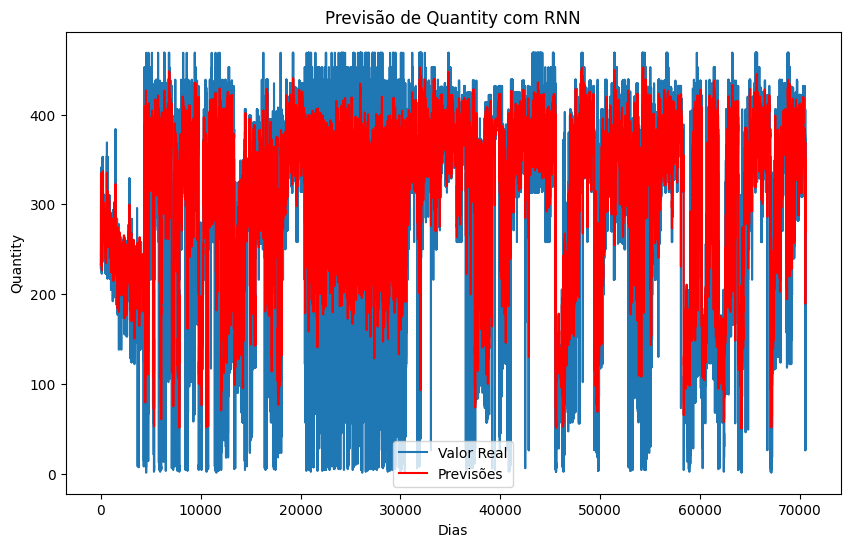

Mean Squared Error: 4391.131393728873
Root Mean Squared Error: 66.26561245268071
Mean Absolute Error: 40.129928142727465


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

# 1. Pré-processamento dos dados
# Supondo que o DataFrame 'df' já tenha sido calculado com a coluna 'Quantity'
# A coluna 'Quantity' deve ser o número total de ocorrências por dia, conforme explicado.

# Escalonamento da coluna 'Quantity' (normalização para o intervalo [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
df['Quantity_scaled'] = scaler.fit_transform(df[['Quantity']])

# 2. Criação de janelas de tempo
time_step = 10  # Número de passos de tempo a serem considerados para a predição

# Função para criar o dataset com janelas de tempo
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# Dividir em treino e teste
train_data, test_data = train_test_split(df['Quantity_scaled'], test_size=0.2, shuffle=False)

# Criar datasets de treinamento e teste
X_train, y_train = create_dataset(train_data.values, time_step)
X_test, y_test = create_dataset(test_data.values, time_step)

# Reformatar para o formato esperado pelo RNN (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Adicionando a dimensão 'features'
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 3. Criação do Modelo RNN
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(time_step, 1)))  # RNN com 50 unidades
model.add(Dense(1))  # Camada de saída com 1 unidade (previsão para o próximo valor)

# 4. Compilação do Modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Treinamento do Modelo
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# 6. Realizando previsões
predictions = model.predict(X_test)

# Inversão da transformação para retornar ao valor original da 'Quantity'
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Avaliação do Modelo
# Plotando a previsão vs o valor real
plt.figure(figsize=(10,6))
plt.plot(y_test_original, label='Valor Real')
plt.plot(predictions, label='Previsões', color='red')
plt.title('Previsão de Quantity com RNN')
plt.xlabel('Dias')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 8. Cálculo das métricas de desempenho
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.4066
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2743
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0781
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0357
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0232
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0174
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0137
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


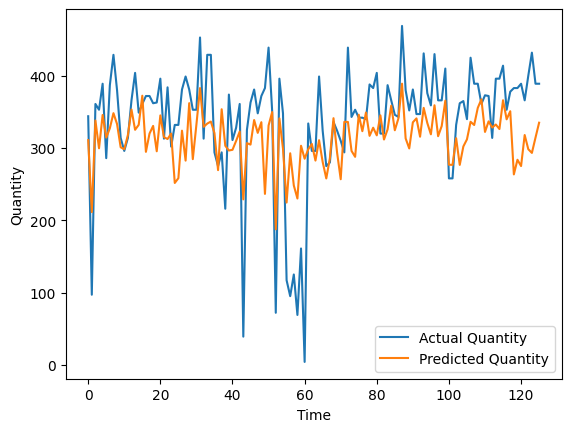

Mean Squared Error: 5042.663017372416
Root Mean Squared Error: 71.01171042421394


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(dfCopy, drop_first=True)  # Converts strings to one-hot and drops the first category to avoid multicollinearity

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for LSTM (samples, time steps, features)
train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))

# 2. Model Building

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_features, train_target, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(test_target, predictions)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


In [ ]:
dfCopy

id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
806          10077086      -27.433461      -48.397987  2017-08-03  04:00:00   
866          10083288      -27.612825      -48.527746  2017-11-24  12:38:00   
867          10082420      -27.684391      -48.553840  2017-11-09  15:46:00   
869          10082354      -27.566806      -48.515430  2017-11-08  18:55:00   
2262         10068370      -27.591457      -48.536355  2017-03-04  21:53:00   
...               ...             ...             ...         ...       ...   
340409       10137822      -27.441516      -48.402242  2021-01-13  08:36:44   
340468       10137648      -27.574695      -48.433085  2021-01-09  14:54:18   
340504       10137748      -27.596848      -48.522426  2021-01-11  16:09:36   
340528       10137866      -27.676447      -48.501797  2021-01-14  13:31:02   
340590       10137885      -27.593763      -48.573022  2021-01-14  19:55:21   

        Hour  Year  Month  Day  Quantity  Quantity_scaled  
806        4  2017      8    3       328         0.696774  
866       12  2017     11   24       421         0.896774  
867       15  2017     11    9       381         0.810753  
869       18  2017     11    8       330         0.701075  
2262      21  2017      3    4       206         0.434409  
...      ...   ...    ...  ...       ...              ...  
340409     8  2021      1   13       366         0.778495  
340468    14  2021      1    9       400         0.851613  
340504    16  2021      1   11       432         0.920430  
340528    13  2021      1   14       389         0.827957  
340590    19  2021      1   14       389         0.827957  

[627 rows x 11 columns]

In [ ]:
# First, ensure there are no other factors affecting the grouping
# Calculate the daily occurrences count for each unique Year, Month, Day
df_quantity = dfCopy.groupby(['Year', 'Month', 'Day']).size().reset_index(name='Quantity')

# Merge the calculated daily occurrences back into the original DataFrame
dfCopy = pd.merge(dfCopy, df_quantity, on=['Year', 'Month', 'Day'], how='left')


In [ ]:
# Check if Quantity matches correctly for a given date
print(dfCopy[dfCopy['Year'] == 2017][dfCopy['Month'] == 8][dfCopy['Day'] == 3])


     id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
0         10077086      -27.433461      -48.397987  2017-08-03  04:00:00   
14        10077104      -27.589707      -48.494905  2017-08-03  11:52:00   
152       10077103      -27.589616      -48.494952  2017-08-03  11:52:00   

     Hour  Year  Month  Day Classe_Bacias Classe_Movimento  Quantity  
0       4  2017      8    3          Alta            Baixa         3  
14     11  2017      8    3          Alta            Baixa         3  
152    11  2017      8    3          Alta            Baixa         3  


<ipython-input-123-88b0207ab723>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(dfCopy[dfCopy['Year'] == 2017][dfCopy['Month'] == 8][dfCopy['Day'] == 3])
<ipython-input-123-88b0207ab723>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(dfCopy[dfCopy['Year'] == 2017][dfCopy['Month'] == 8][dfCopy['Day'] == 3])


In [ ]:
dfCopy

id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
0         10077086      -27.433461      -48.397987  2017-08-03  04:00:00   
1         10083288      -27.612825      -48.527746  2017-11-24  12:38:00   
2         10082420      -27.684391      -48.553840  2017-11-09  15:46:00   
3         10082354      -27.566806      -48.515430  2017-11-08  18:55:00   
4         10068370      -27.591457      -48.536355  2017-03-04  21:53:00   
..             ...             ...             ...         ...       ...   
622       10137822      -27.441516      -48.402242  2021-01-13  08:36:44   
623       10137648      -27.574695      -48.433085  2021-01-09  14:54:18   
624       10137748      -27.596848      -48.522426  2021-01-11  16:09:36   
625       10137866      -27.676447      -48.501797  2021-01-14  13:31:02   
626       10137885      -27.593763      -48.573022  2021-01-14  19:55:21   

     Hour  Year  Month  Day Classe_Bacias Classe_Movimento  Quantity  
0       4  2017      8    3          Alta            Baixa         3  
1      12  2017     11   24         Baixa            Baixa         1  
2      15  2017     11    9          Alta            Baixa         1  
3      18  2017     11    8          Alta            Baixa         3  
4      21  2017      3    4         Baixa             Alta         1  
..    ...   ...    ...  ...           ...              ...       ...  
622     8  2021      1   13          Alta            Baixa         1  
623    14  2021      1    9         Baixa            Baixa         1  
624    16  2021      1   11         Baixa            Baixa         1  
625    13  2021      1   14          Alta            Baixa         4  
626    19  2021      1   14         Baixa            Baixa         4  

[627 rows x 12 columns]

In [ ]:
df3 = dfCopy.copy()

In [ ]:
df4 = df3_sorted.copy()

In [ ]:
df1

id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
0         10077086      -27.433461      -48.397987  2017-08-03  04:00:00   
1         10083288      -27.612825      -48.527746  2017-11-24  12:38:00   
2         10082420      -27.684391      -48.553840  2017-11-09  15:46:00   
3         10082354      -27.566806      -48.515430  2017-11-08  18:55:00   
4         10068370      -27.591457      -48.536355  2017-03-04  21:53:00   
..             ...             ...             ...         ...       ...   
622       10137822      -27.441516      -48.402242  2021-01-13  08:36:44   
623       10137648      -27.574695      -48.433085  2021-01-09  14:54:18   
624       10137748      -27.596848      -48.522426  2021-01-11  16:09:36   
625       10137866      -27.676447      -48.501797  2021-01-14  13:31:02   
626       10137885      -27.593763      -48.573022  2021-01-14  19:55:21   

     Hour  Year  Month  Day  Quantity  
0       4  2017      8    3         3  
1      12  2017     11   24         1  
2      15  2017     11    9         1  
3      18  2017     11    8         3  
4      21  2017      3    4         1  
..    ...   ...    ...  ...       ...  
622     8  2021      1   13         1  
623    14  2021      1    9         1  
624    16  2021      1   11         1  
625    13  2021      1   14         4  
626    19  2021      1   14         4  

[627 rows x 10 columns]

In [ ]:
df2

id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
0         10077086      -27.433461      -48.397987  2017-08-03  04:00:00   
1         10083288      -27.612825      -48.527746  2017-11-24  12:38:00   
2         10082420      -27.684391      -48.553840  2017-11-09  15:46:00   
3         10082354      -27.566806      -48.515430  2017-11-08  18:55:00   
4         10068370      -27.591457      -48.536355  2017-03-04  21:53:00   
..             ...             ...             ...         ...       ...   
622       10137822      -27.441516      -48.402242  2021-01-13  08:36:44   
623       10137648      -27.574695      -48.433085  2021-01-09  14:54:18   
624       10137748      -27.596848      -48.522426  2021-01-11  16:09:36   
625       10137866      -27.676447      -48.501797  2021-01-14  13:31:02   
626       10137885      -27.593763      -48.573022  2021-01-14  19:55:21   

     Hour  Year  Month  Day PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  ...  \
0       4  2017      8    3                              2,6  ...   
1      12  2017     11   24                                0  ...   
2      15  2017     11    9                                0  ...   
3      18  2017     11    8                                0  ...   
4      21  2017      3    4                              0,2  ...   
..    ...   ...    ...  ...                              ...  ...   
622     8  2021      1   13                                0  ...   
623    14  2021      1    9                                0  ...   
624    16  2021      1   11                                0  ...   
625    13  2021      1   14                                0  ...   
626    19  2021      1   14                                0  ...   

    UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)  \
0                                       92.0   
1                                       65.0   
2                                       71.0   
3                                       76.0   
4                                       86.0   
..                                       ...   
622                                     84.0   
623                                     60.0   
624                                     67.0   
625                                     80.0   
626                                     80.0   

    UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  \
0                                       90.0   
1                                       60.0   
2                                       63.0   
3                                       72.0   
4                                       82.0   
..                                       ...   
622                                     77.0   
623                                     42.0   
624                                     62.0   
625                                     77.0   
626                                     73.0   

    UMIDADE RELATIVA DO AR, HORARIA (%) VENTO, DIREÇÃO HORARIA (gr) (° (gr))  \
0                                  92.0                                193.0   
1                                  61.0                                  1.0   
2                                  66.0                                352.0   
3                                  72.0                                355.0   
4                                  84.0                                108.0   
..                                  ...                                  ...   
622                                84.0                                161.0   
623                                45.0                                 45.0   
624                                65.0                                 30.0   
625                                80.0                                164.0   
626                                74.0                                157.0   

    VENTO, RAJADA MAXIMA (m/s) VENTO, VELOCIDADE HORARIA (m/s)    DatesNew  \
0                          1,4                             0,2  2017-0

In [ ]:
df4

id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
91        10064414      -27.447496      -48.425808  2017-01-04  09:11:00   
93        10064717      -27.455293      -48.380926  2017-01-09  08:57:00   
92        10064915      -27.596752      -48.574580  2017-01-12  14:07:00   
21        10065157      -27.467694      -48.446634  2017-01-16  08:22:00   
201       10065272      -27.601925      -48.512678  2017-01-17  20:11:00   
..             ...             ...             ...         ...       ...   
626       10137885      -27.593763      -48.573022  2021-01-14  19:55:21   
505       10137890      -27.589377      -48.550147  2021-01-14  22:30:11   
540       10137909      -27.535046      -48.511553  2021-01-15  11:40:53   
523       10137954      -27.415774      -48.425837  2021-01-16  12:20:57   
510       10138032      -27.597699      -48.565381  2021-01-17  20:27:40   

     Hour  Year  Month  Day Classe_Bacias Classe_Movimento  Quantity  \
91      9  2017      1    4         Media            Baixa         1   
93      8  2017      1    9         Baixa            Baixa         1   
92     14  2017      1   12         Baixa            Baixa         1   
21      8  2017      1   16          Alta            Baixa         1   
201    20  2017      1   17          Alta            Media         1   
..    ...   ...    ...  ...           ...              ...       ...   
626    19  2021      1   14         Baixa            Baixa         4   
505    22  2021      1   14         Baixa            Baixa         4   
540    11  2021      1   15          Alta            Baixa         1   
523    12  2021      1   16         Baixa            Baixa         1   
510    20  2021      1   17         Baixa            Baixa         1   

     Quantity_scaled  
91               0.0  
93               0.0  
92               0.0  
21               0.0  
201              0.0  
..               ...  
626              0.6  
505              0.6  
540              0.0  
523              0.0  
510              0.0  

[627 rows x 13 columns]

In [ ]:
# prompt: find df2_sorted NaN

# Assuming df2 is defined and available in your environment.
# Replace df2 with your actual DataFrame name if different.

nan_values = df2_sorted[df2_sorted.isna().any(axis=1)]
nan_values

id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
435       10118397      -27.590933      -48.516977  2019-11-02  03:17:00   

     Hour  Year  Month  Day PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  ...  \
435     3  2019     11    2                              NaN  ...   

    UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  \
435                                     83.0   

    UMIDADE RELATIVA DO AR, HORARIA (%) VENTO, DIREÇÃO HORARIA (gr) (° (gr))  \
435                                83.0                                 39.0   

    VENTO, RAJADA MAXIMA (m/s) VENTO, VELOCIDADE HORARIA (m/s)    DatesNew  \
435                        3,7                             1,3  2019-11-02   

    HorasN2     Radiacao Quantity  Quantity_scaled  
435       3  1310.717514        1              0.0  

[1 rows x 30 columns]

In [ ]:
nan_values = df4[df4.isna().any(axis=1)]
nan_values

id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
468       10118397      -27.590933      -48.516977  2019-11-02  03:17:00   

     Hour  Year  Month  Day Classe_Bacias  ...  \
468     3  2019     11    2          Alta  ...   

    TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)  \
468                                             19,2   

     UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)  \
468                                      87.0   

     UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  \
468                                      83.0   

    UMIDADE RELATIVA DO AR, HORARIA (%) VENTO, DIREÇÃO HORARIA (gr) (° (gr))  \
468                                83.0                                 39.0   

    VENTO, RAJADA MAXIMA (m/s) VENTO, VELOCIDADE HORARIA (m/s)    DatesNew  \
468                        3,7                             1,3  2019-11-02   

    HorasN2     Radiacao  
468       3  1310.717514  

[1 rows x 32 columns]

In [ ]:
# prompt: change only the NaN values of Radiacao for the mean values of radiacao on df2_sorted

# Assuming df2_sorted and 'Radiacao' column exist
# Calculate the mean of 'Radiacao', ignoring NaN values
mean_radiacao = df2_sorted['Radiacao'].mean(skipna=True)

# Fill NaN values in 'Radiacao' with the calculated mean
df2_sorted['Radiacao'] = df2_sorted['Radiacao'].fillna(mean_radiacao)

In [ ]:
# prompt: change only the NaN values of Radiacao for the mean values of radiacao on df2_sorted

# Assuming df2_sorted and 'Radiacao' column exist
# Calculate the mean of 'Radiacao', ignoring NaN values
mean_radiacao = df4['Radiacao'].mean(skipna=True)

# Fill NaN values in 'Radiacao' with the calculated mean
df4['Radiacao'] = df2_sorted['Radiacao'].fillna(mean_radiacao)

In [ ]:
# First, ensure there are no other factors affecting the grouping
# Calculate the daily occurrences count for each unique Year, Month, Day
df_quantity = df2.groupby(['Year', 'Month', 'Day']).size().reset_index(name='Quantity')

# Merge the calculated daily occurrences back into the original DataFrame
df2 = pd.merge(df2, df_quantity, on=['Year', 'Month', 'Day'], how='left')


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0553 - val_loss: 0.0419
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0389 - val_loss: 0.0404
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0413 - val_loss: 0.0391
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0383 - val_loss: 0.0390
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0354 - val_loss: 0.0385
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0426 - val_loss: 0.0400
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0438 - val_loss: 0.0384
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0367 - val_loss: 0.0380
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0385 - val_loss: 0.0378
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0327 - val_loss: 0.0380
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0402 - val_loss: 0.0404
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0349 - val_loss: 0.0383

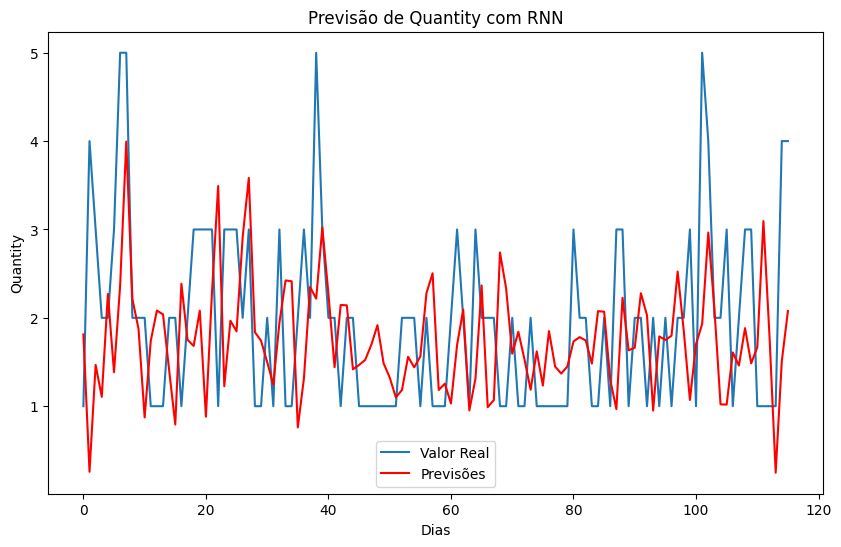

Mean Squared Error: 1.3088160542763274
Root Mean Squared Error: 1.1440349882220944
Mean Absolute Error: 0.9140389833984703


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

# 1. Pré-processamento dos dados
# Supondo que o DataFrame 'df' já tenha sido calculado com a coluna 'Quantity'
# A coluna 'Quantity' deve ser o número total de ocorrências por dia, conforme explicado.

# Escalonamento da coluna 'Quantity' (normalização para o intervalo [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
dfCopy['Quantity_scaled'] = scaler.fit_transform(dfCopy[['Quantity']])

# 2. Criação de janelas de tempo
time_step = 10  # Número de passos de tempo a serem considerados para a predição

# Função para criar o dataset com janelas de tempo
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# Dividir em treino e teste
train_data, test_data = train_test_split(dfCopy['Quantity_scaled'], test_size=0.2, shuffle=False)

# Criar datasets de treinamento e teste
X_train, y_train = create_dataset(train_data.values, time_step)
X_test, y_test = create_dataset(test_data.values, time_step)

# Reformatar para o formato esperado pelo RNN (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Adicionando a dimensão 'features'
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 3. Criação do Modelo RNN
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(time_step, 1)))  # RNN com 50 unidades
model.add(Dense(1))  # Camada de saída com 1 unidade (previsão para o próximo valor)

# 4. Compilação do Modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Treinamento do Modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# 6. Realizando previsões
predictions = model.predict(X_test)

# Inversão da transformação para retornar ao valor original da 'Quantity'
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Avaliação do Modelo
# Plotando a previsão vs o valor real
plt.figure(figsize=(10,6))
plt.plot(y_test_original, label='Valor Real')
plt.plot(predictions, label='Previsões', color='red')
plt.title('Previsão de Quantity com RNN')
plt.xlabel('Dias')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 8. Cálculo das métricas de desempenho
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0559 - val_loss: 0.0423
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0426 - val_loss: 0.0407
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0447 - val_loss: 0.0411
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0367 - val_loss: 0.0409
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0410 - val_loss: 0.0401
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0464 - val_loss: 0.0404
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0457 - val_loss: 0.0407
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0458 - val_loss: 0.0402
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0404 - val_loss: 0.0400
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0433 - val_loss: 0.0401
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0385 - val_loss: 0.0403
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0410 - 

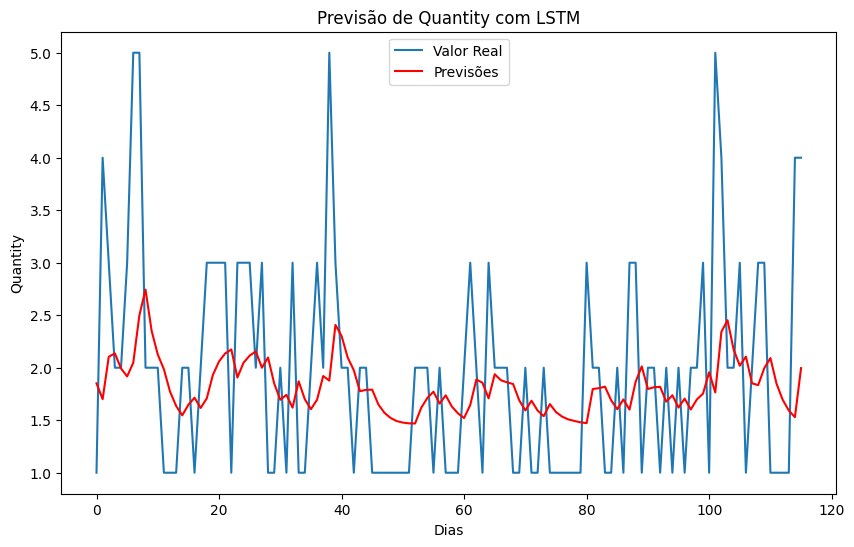

Mean Squared Error: 0.9724846910663404
Root Mean Squared Error: 0.9861463841977723
Mean Absolute Error: 0.7795759418915058


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

# Escalonamento da coluna 'Quantity' (normalização para o intervalo [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
dfCopy['Quantity_scaled'] = scaler.fit_transform(dfCopy[['Quantity']])

# 2. Criação de janelas de tempo
time_step = 10  # Número de passos de tempo a serem considerados para a predição

# Função para criar o dataset com janelas de tempo
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# Dividir em treino e teste
train_data, test_data = train_test_split(dfCopy['Quantity_scaled'], test_size=0.2, shuffle=False)

# Criar datasets de treinamento e teste
X_train, y_train = create_dataset(train_data.values, time_step)
X_test, y_test = create_dataset(test_data.values, time_step)

# Reformatar para o formato esperado pelo RNN (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Adicionando a dimensão 'features'
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 3. Criação do Modelo RNN
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(time_step, 1)))  # RNN com 50 unidades
model.add(Dense(1))  # Camada de saída com 1 unidade (previsão para o próximo valor)

# 4. Compilação do Modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Treinamento do Modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# 6. Realizando previsões
predictions = model.predict(X_test)

# Inversão da transformação para retornar ao valor original da 'Quantity'
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Avaliação do Modelo
# Plotando a previsão vs o valor real
plt.figure(figsize=(10,6))
plt.plot(y_test_original, label='Valor Real')
plt.plot(predictions, label='Previsões', color='red')
plt.title('Previsão de Quantity com LSTM')
plt.xlabel('Dias')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 8. Cálculo das métricas de desempenho
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')


In [ ]:
dfCopy

id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
0         10077086      -27.433461      -48.397987  2017-08-03  04:00:00   
1         10083288      -27.612825      -48.527746  2017-11-24  12:38:00   
2         10082420      -27.684391      -48.553840  2017-11-09  15:46:00   
3         10082354      -27.566806      -48.515430  2017-11-08  18:55:00   
4         10068370      -27.591457      -48.536355  2017-03-04  21:53:00   
..             ...             ...             ...         ...       ...   
622       10137822      -27.441516      -48.402242  2021-01-13  08:36:44   
623       10137648      -27.574695      -48.433085  2021-01-09  14:54:18   
624       10137748      -27.596848      -48.522426  2021-01-11  16:09:36   
625       10137866      -27.676447      -48.501797  2021-01-14  13:31:02   
626       10137885      -27.593763      -48.573022  2021-01-14  19:55:21   

     Hour  Year  Month  Day  Quantity  Quantity_scaled  
0       4  2017      8    3         3              0.4  
1      12  2017     11   24         1              0.0  
2      15  2017     11    9         1              0.0  
3      18  2017     11    8         3              0.4  
4      21  2017      3    4         1              0.0  
..    ...   ...    ...  ...       ...              ...  
622     8  2021      1   13         1              0.0  
623    14  2021      1    9         1              0.0  
624    16  2021      1   11         1              0.0  
625    13  2021      1   14         4              0.6  
626    19  2021      1   14         4              0.6  

[627 rows x 11 columns]

In [ ]:
df1

id_ocorrencia  lat_ocorrencia  lon_ocorrencia       Dates      Time  \
0         10077086      -27.433461      -48.397987  2017-08-03  04:00:00   
1         10083288      -27.612825      -48.527746  2017-11-24  12:38:00   
2         10082420      -27.684391      -48.553840  2017-11-09  15:46:00   
3         10082354      -27.566806      -48.515430  2017-11-08  18:55:00   
4         10068370      -27.591457      -48.536355  2017-03-04  21:53:00   
..             ...             ...             ...         ...       ...   
622       10137822      -27.441516      -48.402242  2021-01-13  08:36:44   
623       10137648      -27.574695      -48.433085  2021-01-09  14:54:18   
624       10137748      -27.596848      -48.522426  2021-01-11  16:09:36   
625       10137866      -27.676447      -48.501797  2021-01-14  13:31:02   
626       10137885      -27.593763      -48.573022  2021-01-14  19:55:21   

     Hour  Year  Month  Day  Quantity  Quantity_scaled  
0       4  2017      8    3         3              0.4  
1      12  2017     11   24         1              0.0  
2      15  2017     11    9         1              0.0  
3      18  2017     11    8         3              0.4  
4      21  2017      3    4         1              0.0  
..    ...   ...    ...  ...       ...              ...  
622     8  2021      1   13         1              0.0  
623    14  2021      1    9         1              0.0  
624    16  2021      1   11         1              0.0  
625    13  2021      1   14         4              0.6  
626    19  2021      1   14         4              0.6  

[627 rows x 11 columns]

Optimal (p, d, q): (1, 0, 0)
Mean Squared Error: 1.3560878962980862
Root Mean Squared Error: 1.1645118703981021
Mean Absolute Error: 0.9216595671562368


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

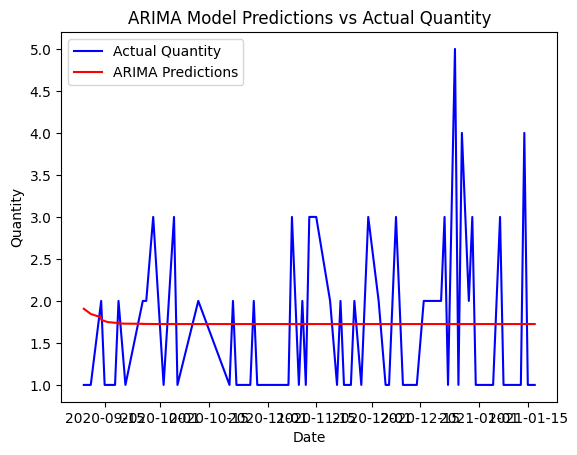

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import matplotlib.pyplot as plt

# Ensure 'Date' column is in datetime format and sorted
dfCopy['Date'] = pd.to_datetime(dfCopy[['Year', 'Month', 'Day']])
dfCopy = dfCopy.sort_values(by='Date')
dfCopy.set_index('Date', inplace=True)

# Extract the Quantity series
quantity_series = dfCopy['Quantity']

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(quantity_series) * 0.8)
train_data, test_data = quantity_series[:train_size], quantity_series[train_size:]

# Use Auto ARIMA to find optimal p, d, q parameters
auto_model = pm.auto_arima(train_data, seasonal=False, stepwise=True, suppress_warnings=True)
p, d, q = auto_model.order
print(f"Optimal (p, d, q): {p, d, q}")

# Fit ARIMA model using the best parameters
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# Forecast for the test period
forecast = model_fit.forecast(steps=len(test_data))
forecast = forecast[:len(test_data)]  # Ensure forecast length matches test data

# Evaluate the forecast
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, forecast)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

# Plot the forecast against actual test values
plt.plot(test_data, label='Actual Quantity', color='blue')
plt.plot(test_data.index, forecast, label='ARIMA Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.title('ARIMA Model Predictions vs Actual Quantity')
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Mean Squared Error: 1.186554432866772
Root Mean Squared Error: 1.0892907935288778
Mean Absolute Error: 0.8217902171614636
Mean Absolute Percentage Error: 0.24232137249778474


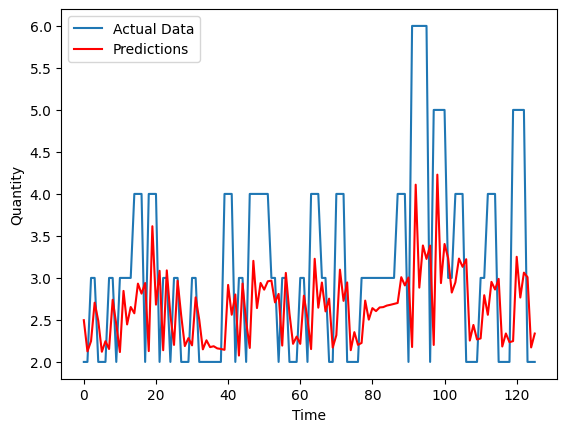

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm


#train_data_transformed = np.log1p(train_data)  # log(1 + x) to handle 0 values
#test_data_transformed = np.log1p(test_data)

# If you want to use Box-Cox transformation instead:
train_data_transformed, lmbda = boxcox(train_data + 1)  # Adding 1 to avoid issues with zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data
history = [x for x in train_data_transformed]
predictions = []

# Automatically discover the best p, d, q values using transformed data
auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1, max_p=5, max_q=5, d=0, seasonal=False, stepwise=True)
p, d, q = auto_model.order  # Extract best p, d, q parameters from Auto-ARIMA

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the ARIMA model on the rolling history
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the transformation (log to original scale)
#predictions = np.expm1(predictions)  # Inverse log(1+x) -> exp(x)-1
#test_data_original = np.expm1(test_data_transformed)

# If using Box-Cox:
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Best (p, d, q): {p, d, q}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Mean Squared Error: 1.186554432866772
Root Mean Squared Error: 1.0892907935288778
Mean Absolute Error: 0.8217902171614636
Mean Absolute Percentage Error: 0.24232137249778474
Best (p, d, q): (1, 0, 2)


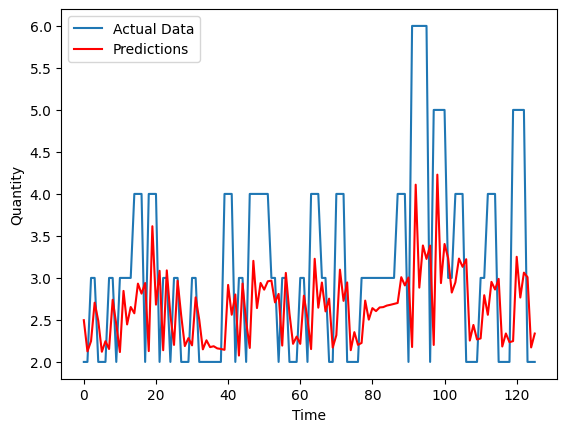

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm


#train_data_transformed = np.log1p(train_data)  # log(1 + x) to handle 0 values
#test_data_transformed = np.log1p(test_data)

# If you want to use Box-Cox transformation instead:
train_data_transformed, lmbda = boxcox(train_data + 1)  # Adding 1 to avoid issues with zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data
history = [x for x in train_data_transformed]
predictions = []

# Automatically discover the best p, d, q values using transformed data
auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1, max_p=5, max_q=5, d=0, seasonal=False, stepwise=True)
p, d, q = auto_model.order  # Extract best p, d, q parameters from Auto-ARIMA

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the ARIMA model on the rolling history
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the transformation (log to original scale)
#predictions = np.expm1(predictions)  # Inverse log(1+x) -> exp(x)-1
#test_data_original = np.expm1(test_data_transformed)

# If using Box-Cox:
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Best (p, d, q): {p, d, q}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


df1,df2,df3,df4,df5

LEMBRA DE DAR SORT

EXPERIMENTO 1

ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 1.0799807460856634
Root Mean Squared Error: 1.0392212209561849
Mean Absolute Error: 0.7877994118093652
Mean Absolute Percentage Error: 0.24015835909466038
Best (p, d, q): (1, 1, 2)


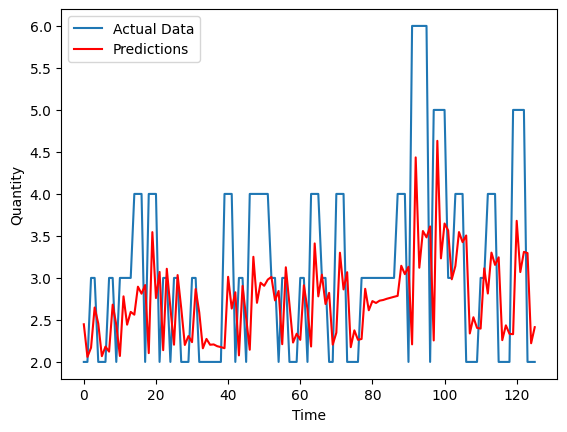

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm


# Dividir em treino e teste
train_data, test_data = train_test_split(df_sorted['Quantity'], test_size=0.2, shuffle=False)

#train_data_transformed = np.log1p(train_data)  # log(1 + x) to handle 0 values
#test_data_transformed = np.log1p(test_data)

# If you want to use Box-Cox transformation instead:
train_data_transformed, lmbda = boxcox(train_data + 1)  # Adding 1 to avoid issues with zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data
history = [x for x in train_data_transformed]
predictions = []

# Automatically discover the best p, d, q values using transformed data
#auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1, max_p=5, max_q=5, d=0, seasonal=False, stepwise=True)
p, d, q = (1,1,2)#auto_model.order  # Extract best p, d, q parameters from Auto-ARIMA

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the ARIMA model on the rolling history
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the transformation (log to original scale)
#predictions = np.expm1(predictions)  # Inverse log(1+x) -> exp(x)-1
#test_data_original = np.expm1(test_data_transformed)

# If using Box-Cox:
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Best (p, d, q): {p, d, q}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


RNN

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0451 - val_loss: 0.0371
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0275 - val_loss: 0.0369
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0306 - val_loss: 0.0356
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0237 - val_loss: 0.0355
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0239 - val_loss: 0.0362
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0255 - val_loss: 0.0346
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0232 - val_loss: 0.0348
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0204 - val_loss: 0.0338
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0194 - val_loss: 0.0328
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0205 - val_loss: 0.0339
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0255 - val_loss: 0.0345
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0205 - val_loss: 0.0335

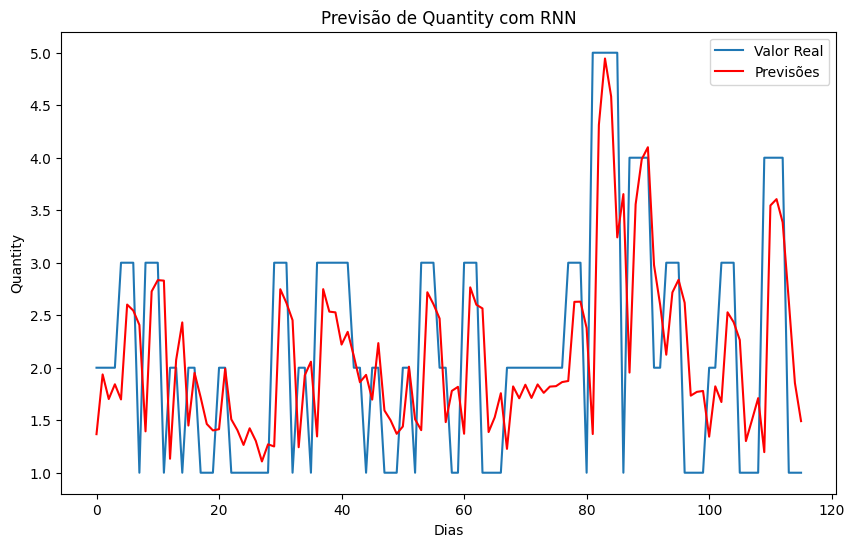

Mean Squared Error: 0.8377132537942734
Root Mean Squared Error: 0.9152667664644409
Mean Absolute Error: 0.6751245455495243
Mean Absolute Percentage Error: 0.4156983697380143


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

# 1. Pré-processamento dos dados
# Supondo que o DataFrame 'df' já tenha sido calculado com a coluna 'Quantity'
# A coluna 'Quantity' deve ser o número total de ocorrências por dia, conforme explicado.

# Escalonamento da coluna 'Quantity' (normalização para o intervalo [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
df_sorted['Quantity_scaled'] = scaler.fit_transform(df_sorted[['Quantity']])

# 2. Criação de janelas de tempo
time_step = 10  # Número de passos de tempo a serem considerados para a predição

# Função para criar o dataset com janelas de tempo
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# Dividir em treino e teste
train_data, test_data = train_test_split(df_sorted['Quantity_scaled'], test_size=0.2, shuffle=False)

# Criar datasets de treinamento e teste
X_train, y_train = create_dataset(train_data.values, time_step)
X_test, y_test = create_dataset(test_data.values, time_step)

# Reformatar para o formato esperado pelo RNN (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Adicionando a dimensão 'features'
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 3. Criação do Modelo RNN
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(time_step, 1)))  # RNN com 50 unidades
model.add(Dense(1))  # Camada de saída com 1 unidade (previsão para o próximo valor)

# 4. Compilação do Modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Treinamento do Modelo
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# 6. Realizando previsões
predictions = model.predict(X_test)

# Inversão da transformação para retornar ao valor original da 'Quantity'
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Avaliação do Modelo
# Plotando a previsão vs o valor real
plt.figure(figsize=(10,6))
plt.plot(y_test_original, label='Valor Real')
plt.plot(predictions, label='Previsões', color='red')
plt.title('Previsão de Quantity com RNN')
plt.xlabel('Dias')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 8. Cálculo das métricas de desempenho
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)
mape = mean_absolute_percentage_error(y_test_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")



RNN TARGET

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0235
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.9231e-04
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1558e-04 
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0439e-04 
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7733e-04 
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3362e-04 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


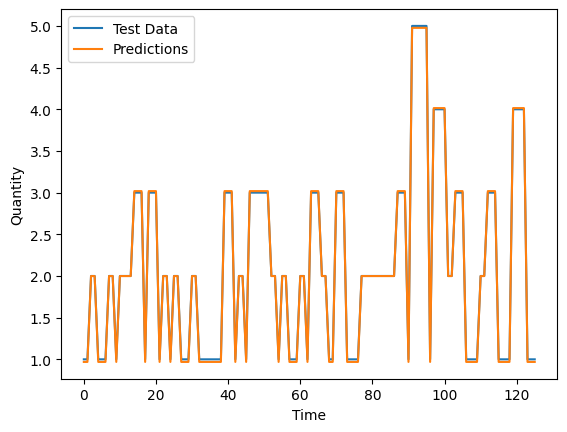

Mean Squared Error: 0.0004570684752090479
Root Mean Squared Error: 0.021379159834031082
Mean Absolute Error: 0.017501286570987897
Mean Absolute Percentage Error: 0.013081259670711663


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Extract the 'Quantity' column as the target variable
target_variable = df_sorted['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape input data to be 3D (samples, time steps, features) for RNN input
train_data = np.reshape(train_data, (train_data.shape[0], 1, 1))
test_data = np.reshape(test_data, (test_data.shape[0], 1, 1))

# 2. Model Building

# Create the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, scaled_target[:train_size], epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data_original = scaler.inverse_transform(scaled_target[train_size:])

# Plot the predictions and test data
plt.plot(test_data_original, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")


LSTM

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0518
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0424
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0328
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0279
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0179
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.2316e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


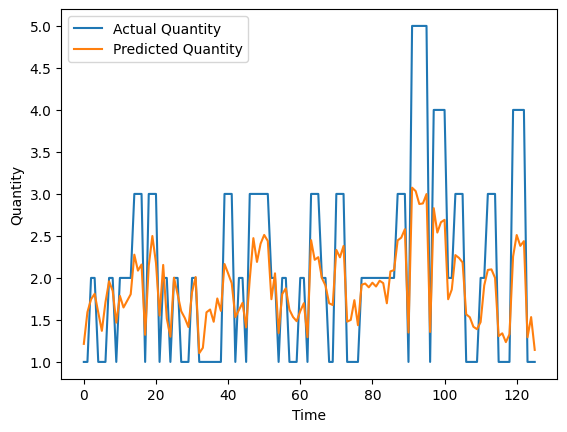

Mean Squared Error: 0.5364685110730867
Root Mean Squared Error: 0.732440107498959
Mean Absolute Error: 0.5662553584764874
Mean Absolute Percentage Error: 0.28792905968333055


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df_sorted, drop_first=True)  # Converts strings to one-hot and drops the first category to avoid multicollinearity

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for LSTM (samples, time steps, features)
train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))

# 2. Model Building

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_features, train_target, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

LSTM TARGET

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0594
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0429
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0395
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0289
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0191
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4237e-04
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1062e-04
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7839e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


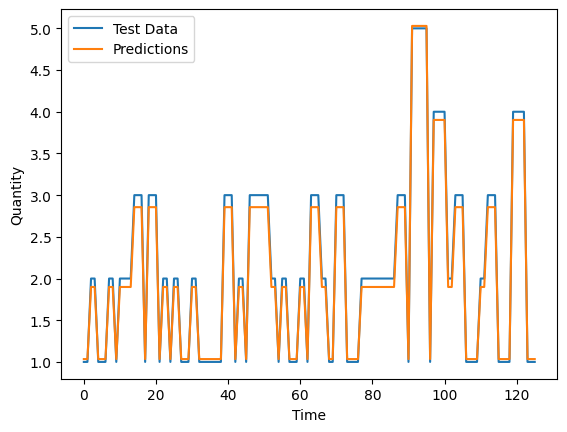

Mean Squared Error: 0.009095996090624578
Root Mean Squared Error: 0.0953729316453289
Mean Absolute Error: 0.08442639736902158
Mean Absolute Percentage Error: 0.04068794704618911


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Extract the 'Quantity' column as the target variable
target_variable = df_sorted['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape input data to be 3D (samples, time steps, features) for RNN input
train_data = np.reshape(train_data, (train_data.shape[0], 1, 1))
test_data = np.reshape(test_data, (test_data.shape[0], 1, 1))

# 2. Model Building

# Create the RNN model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, scaled_target[:train_size], epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data_original = scaler.inverse_transform(scaled_target[train_size:])

# Plot the predictions and test data
plt.plot(test_data_original, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")


EXPERIMENTO 2

ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 1.0799807460856634
Root Mean Squared Error: 1.0392212209561849
Mean Absolute Error: 0.7877994118093652
Mean Absolute Percentage Error: 0.24015835909466038
Best (p, d, q): (1, 1, 2)


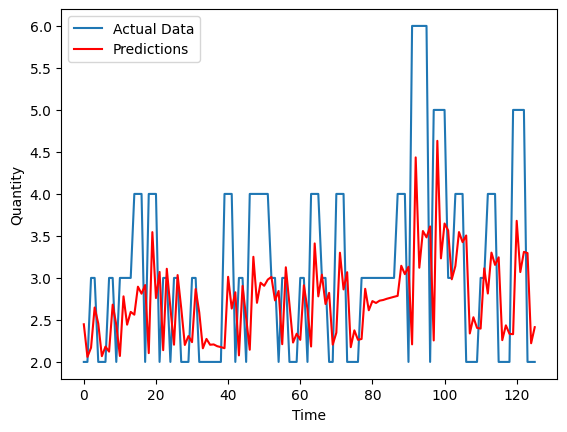

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm


# Dividir em treino e teste
train_data, test_data = train_test_split(df2_sorted['Quantity'], test_size=0.2, shuffle=False)

#train_data_transformed = np.log1p(train_data)  # log(1 + x) to handle 0 values
#test_data_transformed = np.log1p(test_data)

# If you want to use Box-Cox transformation instead:
train_data_transformed, lmbda = boxcox(train_data + 1)  # Adding 1 to avoid issues with zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data
history = [x for x in train_data_transformed]
predictions = []

# Automatically discover the best p, d, q values using transformed data
#auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1, max_p=5, max_q=5, d=0, seasonal=False, stepwise=True)
p, d, q = (1,1,2)#auto_model.order  # Extract best p, d, q parameters from Auto-ARIMA

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the ARIMA model on the rolling history
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the transformation (log to original scale)
#predictions = np.expm1(predictions)  # Inverse log(1+x) -> exp(x)-1
#test_data_original = np.expm1(test_data_transformed)

# If using Box-Cox:
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Best (p, d, q): {p, d, q}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


RNN

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0520 - val_loss: 0.0467
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0359 - val_loss: 0.0432
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0316 - val_loss: 0.0395
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0253 - val_loss: 0.0375
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0217 - val_loss: 0.0361
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0222 - val_loss: 0.0373
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0211 - val_loss: 0.0347
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0234 - val_loss: 0.0378
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0230 - val_loss: 0.0375
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0241 - val_loss: 0.0347
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0253 - val_loss: 0.0375
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0210 - v

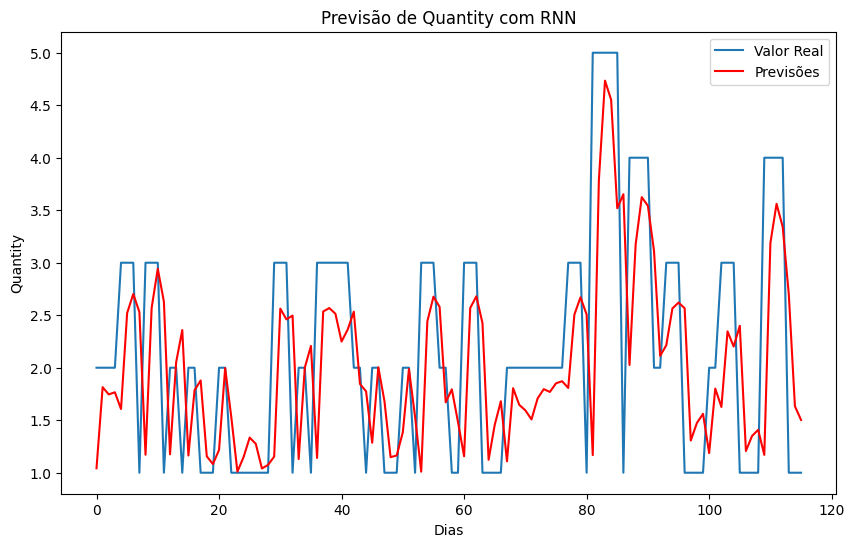

Mean Squared Error: 0.908842596231674
Root Mean Squared Error: 0.9533323639904784
Mean Absolute Error: 0.702428787946701
Mean Absolute Percentage Error: 0.4020874322659668


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

# 1. Pré-processamento dos dados
# Supondo que o DataFrame 'df' já tenha sido calculado com a coluna 'Quantity'
# A coluna 'Quantity' deve ser o número total de ocorrências por dia, conforme explicado.

# Escalonamento da coluna 'Quantity' (normalização para o intervalo [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
df2_sorted['Quantity_scaled'] = scaler.fit_transform(df2_sorted[['Quantity']])

# 2. Criação de janelas de tempo
time_step = 10  # Número de passos de tempo a serem considerados para a predição

# Função para criar o dataset com janelas de tempo
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# Dividir em treino e teste
train_data, test_data = train_test_split(df2_sorted['Quantity_scaled'], test_size=0.2, shuffle=False)

# Criar datasets de treinamento e teste
X_train, y_train = create_dataset(train_data.values, time_step)
X_test, y_test = create_dataset(test_data.values, time_step)

# Reformatar para o formato esperado pelo RNN (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Adicionando a dimensão 'features'
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 3. Criação do Modelo RNN
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(time_step, 1)))  # RNN com 50 unidades
model.add(Dense(1))  # Camada de saída com 1 unidade (previsão para o próximo valor)

# 4. Compilação do Modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Treinamento do Modelo
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# 6. Realizando previsões
predictions = model.predict(X_test)

# Inversão da transformação para retornar ao valor original da 'Quantity'
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Avaliação do Modelo
# Plotando a previsão vs o valor real
plt.figure(figsize=(10,6))
plt.plot(y_test_original, label='Valor Real')
plt.plot(predictions, label='Previsões', color='red')
plt.title('Previsão de Quantity com RNN')
plt.xlabel('Dias')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 8. Cálculo das métricas de desempenho
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)
mape = mean_absolute_percentage_error(y_test_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

RNN TARGET

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0327
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011     
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3492e-04
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010      
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0698e-04 
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5264e-04
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5491e-04  
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


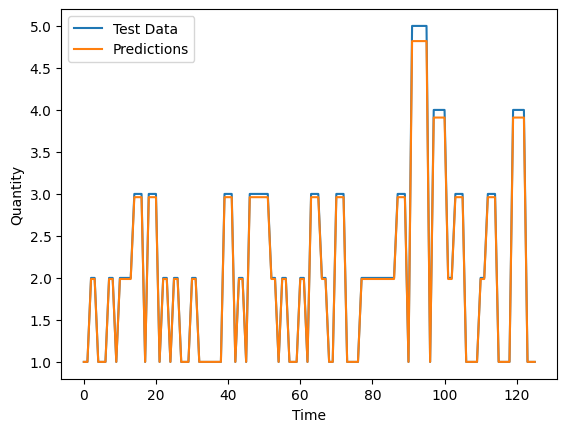

Mean Squared Error: 0.0022258293604088893
Root Mean Squared Error: 0.04717869604396554
Mean Absolute Error: 0.026224925404503337
Mean Absolute Percentage Error: 0.008089085104604281


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Extract the 'Quantity' column as the target variable
target_variable = df2_sorted['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape input data to be 3D (samples, time steps, features) for RNN input
train_data = np.reshape(train_data, (train_data.shape[0], 1, 1))
test_data = np.reshape(test_data, (test_data.shape[0], 1, 1))

# 2. Model Building

# Create the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, scaled_target[:train_size], epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data_original = scaler.inverse_transform(scaled_target[train_size:])

# Plot the predictions and test data
plt.plot(test_data_original, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

LSTM

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0538
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0316
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0220
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0063
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.6412e-04
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.9298e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


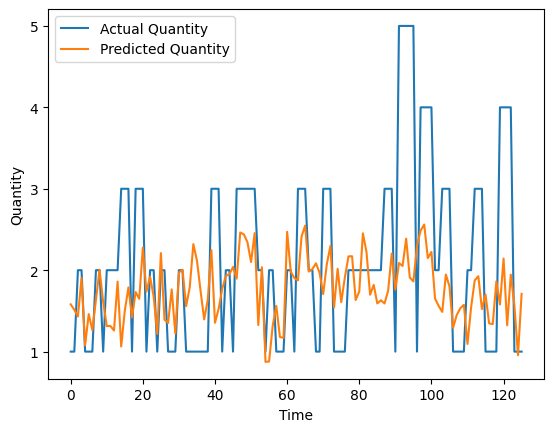

Mean Squared Error: 1.1247995628988074
Root Mean Squared Error: 1.0605656806152117
Mean Absolute Error: 0.8120203179026407
Mean Absolute Percentage Error: 0.4052409275183602


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df2_sorted, drop_first=True)  # Converts strings to one-hot and drops the first category to avoid multicollinearity

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for LSTM (samples, time steps, features)
train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))

# 2. Model Building

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_features, train_target, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

LSTM TARGET

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0612
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0494
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0367
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0258
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0174
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0142e-04
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8963e-04
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4457e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


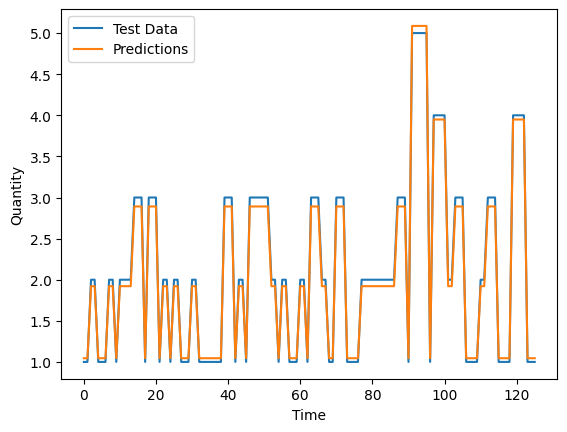

Mean Squared Error: 0.005899067117027271
Root Mean Squared Error: 0.07680538468771099
Mean Absolute Error: 0.07253183921178193
Mean Absolute Percentage Error: 0.03813022337262596


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Extract the 'Quantity' column as the target variable
target_variable = df2_sorted['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape input data to be 3D (samples, time steps, features) for RNN input
train_data = np.reshape(train_data, (train_data.shape[0], 1, 1))
test_data = np.reshape(test_data, (test_data.shape[0], 1, 1))

# 2. Model Building

# Create the RNN model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, scaled_target[:train_size], epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data_original = scaler.inverse_transform(scaled_target[train_size:])

# Plot the predictions and test data
plt.plot(test_data_original, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")


EXPERIMENTO 3

ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 1.0799807460856634
Root Mean Squared Error: 1.0392212209561849
Mean Absolute Error: 0.7877994118093652
Mean Absolute Percentage Error: 0.24015835909466038
Best (p, d, q): (1, 1, 2)


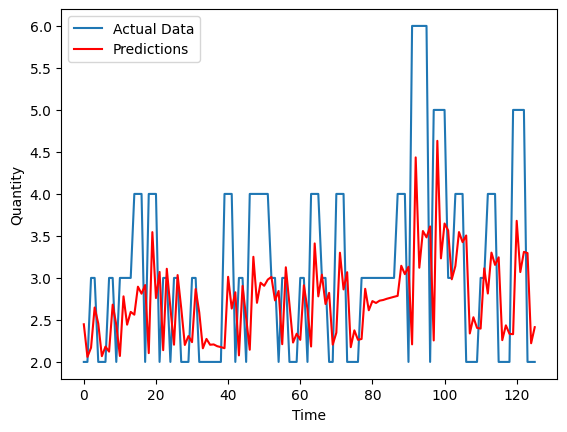

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm


# Dividir em treino e teste
train_data, test_data = train_test_split(df3_sorted['Quantity'], test_size=0.2, shuffle=False)

#train_data_transformed = np.log1p(train_data)  # log(1 + x) to handle 0 values
#test_data_transformed = np.log1p(test_data)

# If you want to use Box-Cox transformation instead:
train_data_transformed, lmbda = boxcox(train_data + 1)  # Adding 1 to avoid issues with zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data
history = [x for x in train_data_transformed]
predictions = []

# Automatically discover the best p, d, q values using transformed data
#auto_model = pm.auto_arima(train_data_transformed, start_p=1, start_q=1, max_p=5, max_q=5, d=0, seasonal=False, stepwise=True)
p, d, q = (1,1,2)#auto_model.order  # Extract best p, d, q parameters from Auto-ARIMA

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the ARIMA model on the rolling history
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the transformation (log to original scale)
#predictions = np.expm1(predictions)  # Inverse log(1+x) -> exp(x)-1
#test_data_original = np.expm1(test_data_transformed)

# If using Box-Cox:
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Best (p, d, q): {p, d, q}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


RNN

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0275 - val_loss: 0.0348
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0251 - val_loss: 0.0353
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0243 - val_loss: 0.0338
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0212 - val_loss: 0.0340
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0229 - val_loss: 0.0333
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0228 - val_loss: 0.0335
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0189 - val_loss: 0.0325
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0214 - val_loss: 0.0328
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0188 - val_loss: 0.0320
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0176 - val_loss: 0.0323
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0200 - val_loss: 0.0323
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0180 - val_loss: 0.0317

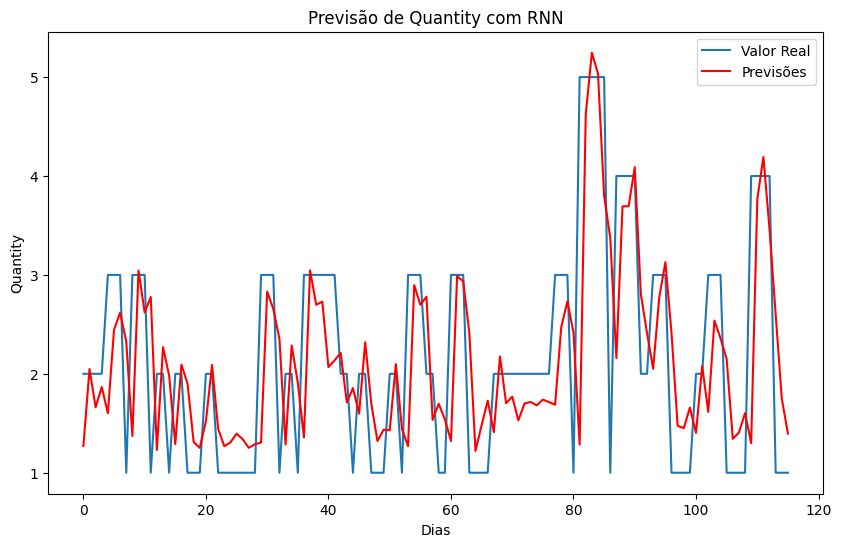

Mean Squared Error: 0.7657419451225291
Root Mean Squared Error: 0.8750668232326769
Mean Absolute Error: 0.6386634666344216
Mean Absolute Percentage Error: 0.3869933060188403


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

# 1. Pré-processamento dos dados
# Supondo que o DataFrame 'df' já tenha sido calculado com a coluna 'Quantity'
# A coluna 'Quantity' deve ser o número total de ocorrências por dia, conforme explicado.

# Escalonamento da coluna 'Quantity' (normalização para o intervalo [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
df3_sorted['Quantity_scaled'] = scaler.fit_transform(df3_sorted[['Quantity']])

# 2. Criação de janelas de tempo
time_step = 10  # Número de passos de tempo a serem considerados para a predição

# Função para criar o dataset com janelas de tempo
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# Dividir em treino e teste
train_data, test_data = train_test_split(df3_sorted['Quantity_scaled'], test_size=0.2, shuffle=False)

# Criar datasets de treinamento e teste
X_train, y_train = create_dataset(train_data.values, time_step)
X_test, y_test = create_dataset(test_data.values, time_step)

# Reformatar para o formato esperado pelo RNN (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Adicionando a dimensão 'features'
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 3. Criação do Modelo RNN
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(time_step, 1)))  # RNN com 50 unidades
model.add(Dense(1))  # Camada de saída com 1 unidade (previsão para o próximo valor)

# 4. Compilação do Modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Treinamento do Modelo
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# 6. Realizando previsões
predictions = model.predict(X_test)

# Inversão da transformação para retornar ao valor original da 'Quantity'
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Avaliação do Modelo
# Plotando a previsão vs o valor real
plt.figure(figsize=(10,6))
plt.plot(y_test_original, label='Valor Real')
plt.plot(predictions, label='Previsões', color='red')
plt.title('Previsão de Quantity com RNN')
plt.xlabel('Dias')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 8. Cálculo das métricas de desempenho
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)
mape = mean_absolute_percentage_error(y_test_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")



RNN TARGET

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0953
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014     
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012     
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6492e-04 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9190e-04
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011     
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010     
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


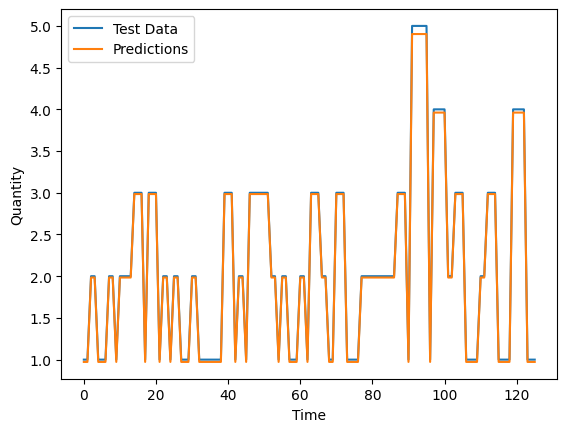

Mean Squared Error: 0.0008708645807098401
Root Mean Squared Error: 0.029510414783764732
Mean Absolute Error: 0.024528907878058403
Mean Absolute Percentage Error: 0.014792489784735255


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Extract the 'Quantity' column as the target variable
target_variable = df3_sorted['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape input data to be 3D (samples, time steps, features) for RNN input
train_data = np.reshape(train_data, (train_data.shape[0], 1, 1))
test_data = np.reshape(test_data, (test_data.shape[0], 1, 1))

# 2. Model Building

# Create the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, scaled_target[:train_size], epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data_original = scaler.inverse_transform(scaled_target[train_size:])

# Plot the predictions and test data
plt.plot(test_data_original, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")


LSTM

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0514
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0371
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0351
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0257
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0118
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


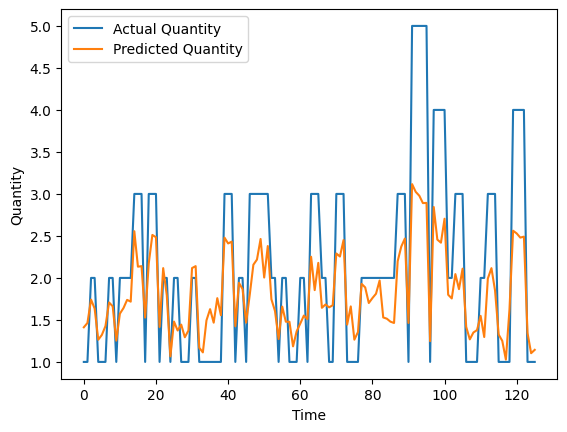

Mean Squared Error: 0.551430675654156
Root Mean Squared Error: 0.7425837835922328
Mean Absolute Error: 0.5899638713352264
Mean Absolute Percentage Error: 0.28527164935434934


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df3_sorted, drop_first=True)  # Converts strings to one-hot and drops the first category to avoid multicollinearity

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for LSTM (samples, time steps, features)
train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))

# 2. Model Building

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_features, train_target, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

LSTM TARGET

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0630
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0479
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0327
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0265
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0229
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.9357e-04
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4029e-04
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.9794e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


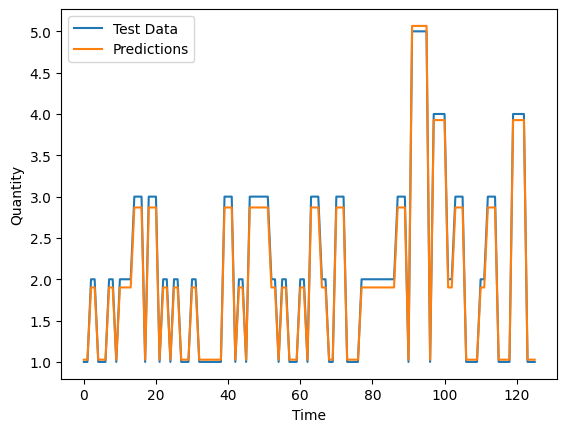

Mean Squared Error: 0.007818549879710599
Root Mean Squared Error: 0.08842256431313558
Mean Absolute Error: 0.07801274742398955
Mean Absolute Percentage Error: 0.036703513728247775


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Extract the 'Quantity' column as the target variable
target_variable = df3_sorted['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape input data to be 3D (samples, time steps, features) for RNN input
train_data = np.reshape(train_data, (train_data.shape[0], 1, 1))
test_data = np.reshape(test_data, (test_data.shape[0], 1, 1))

# 2. Model Building

# Create the RNN model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, scaled_target[:train_size], epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data_original = scaler.inverse_transform(scaled_target[train_size:])

# Plot the predictions and test data
plt.plot(test_data_original, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")


EXPERIMENTO 4

ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 1.0799807460856634
Root Mean Squared Error: 1.0392212209561849
Mean Absolute Error: 0.7877994118093652
Mean Absolute Percentage Error: 0.24015835909466038
Best (p, d, q): (1, 1, 2)


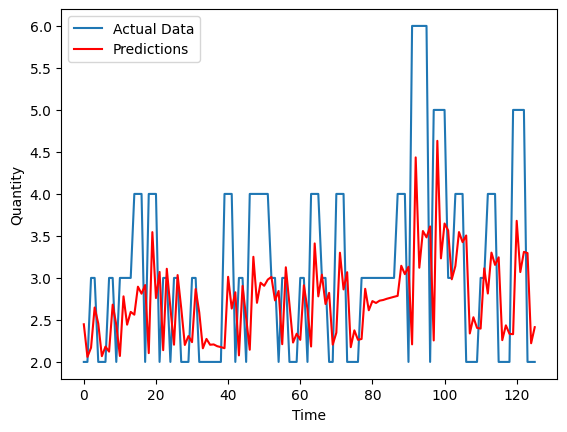

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm


# Dividir em treino e teste
train_data, test_data = train_test_split(df4['Quantity'], test_size=0.2, shuffle=False)

#train_data_transformed = np.log1p(train_data)  # log(1 + x) to handle 0 values
#test_data_transformed = np.log1p(test_data)

# If you want to use Box-Cox transformation instead:
train_data_transformed, lmbda = boxcox(train_data + 1)  # Adding 1 to avoid issues with zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data
history = [x for x in train_data_transformed]
predictions = []

# Automatically discover the best p, d, q values using transformed data
p, d, q = (1,0,1)#auto_model.order  # Extract best p, d, q parameters from Auto-ARIMA

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the ARIMA model on the rolling history
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the transformation (log to original scale)
#predictions = np.expm1(predictions)  # Inverse log(1+x) -> exp(x)-1
#test_data_original = np.expm1(test_data_transformed)

# If using Box-Cox:
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Best (p, d, q): {p, d, q}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


RNN

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0468 - val_loss: 0.0447
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0331 - val_loss: 0.0380
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0284 - val_loss: 0.0380
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0253 - val_loss: 0.0369
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0230 - val_loss: 0.0359
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0245 - val_loss: 0.0365
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0286 - val_loss: 0.0350
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0246 - val_loss: 0.0354
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0198 - val_loss: 0.0346
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0234 - val_loss: 0.0349
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0219 - val_loss: 0.0346
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0215 - val_loss:

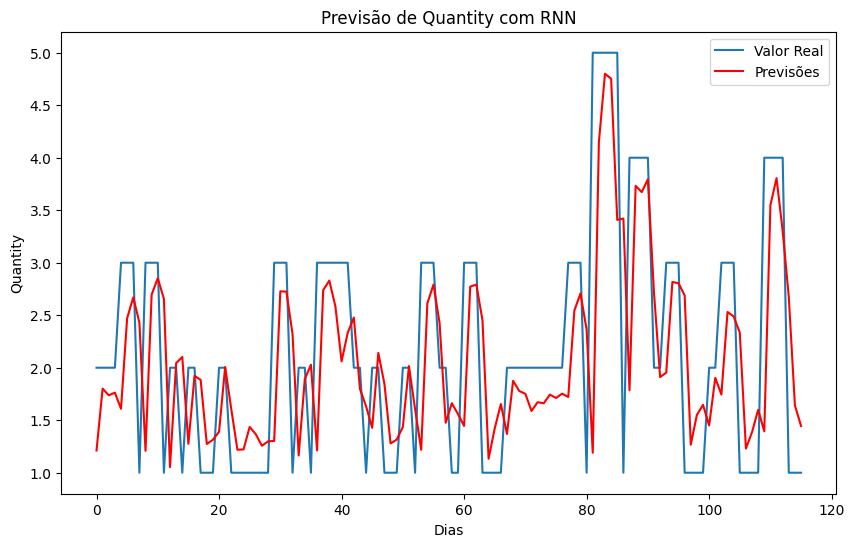

Mean Squared Error: 0.8157920421388847
Root Mean Squared Error: 0.9032120693053679
Mean Absolute Error: 0.657138214029115
Mean Absolute Percentage Error: 0.3919357615812072


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

# 1. Pré-processamento dos dados
# Supondo que o DataFrame 'df' já tenha sido calculado com a coluna 'Quantity'
# A coluna 'Quantity' deve ser o número total de ocorrências por dia, conforme explicado.

# Escalonamento da coluna 'Quantity' (normalização para o intervalo [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
df4['Quantity_scaled'] = scaler.fit_transform(df4[['Quantity']])

# 2. Criação de janelas de tempo
time_step = 10  # Número de passos de tempo a serem considerados para a predição

# Função para criar o dataset com janelas de tempo
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# Dividir em treino e teste
train_data, test_data = train_test_split(df4['Quantity_scaled'], test_size=0.2, shuffle=False)

# Criar datasets de treinamento e teste
X_train, y_train = create_dataset(train_data.values, time_step)
X_test, y_test = create_dataset(test_data.values, time_step)

# Reformatar para o formato esperado pelo RNN (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Adicionando a dimensão 'features'
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 3. Criação do Modelo RNN
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(time_step, 1)))  # RNN com 50 unidades
model.add(Dense(1))  # Camada de saída com 1 unidade (previsão para o próximo valor)

# 4. Compilação do Modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Treinamento do Modelo
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# 6. Realizando previsões
predictions = model.predict(X_test)

# Inversão da transformação para retornar ao valor original da 'Quantity'
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Avaliação do Modelo
# Plotando a previsão vs o valor real
plt.figure(figsize=(10,6))
plt.plot(y_test_original, label='Valor Real')
plt.plot(predictions, label='Previsões', color='red')
plt.title('Previsão de Quantity com RNN')
plt.xlabel('Dias')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 8. Cálculo das métricas de desempenho
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)
mape = mean_absolute_percentage_error(y_test_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")



RNN TARGET

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0317
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013  
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5762e-04  
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5615e-04 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0645e-04 
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5183e-04 
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2930e-04 
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3665e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


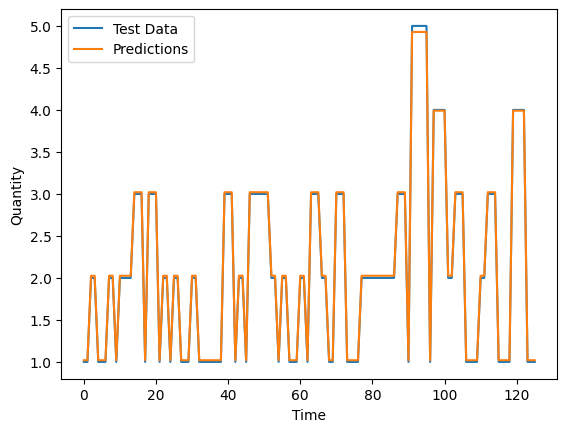

Mean Squared Error: 0.0006569922200497519
Root Mean Squared Error: 0.025631859473119616
Mean Absolute Error: 0.02328702192457885
Mean Absolute Percentage Error: 0.013449898220243872


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Extract the 'Quantity' column as the target variable
target_variable = df4['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape input data to be 3D (samples, time steps, features) for RNN input
train_data = np.reshape(train_data, (train_data.shape[0], 1, 1))
test_data = np.reshape(test_data, (test_data.shape[0], 1, 1))

# 2. Model Building

# Create the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, scaled_target[:train_size], epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data_original = scaler.inverse_transform(scaled_target[train_size:])

# Plot the predictions and test data
plt.plot(test_data_original, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")


LSTM

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0622
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0303
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0221
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.4696e-04
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.0969e-04
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.5345e-04
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.9388e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


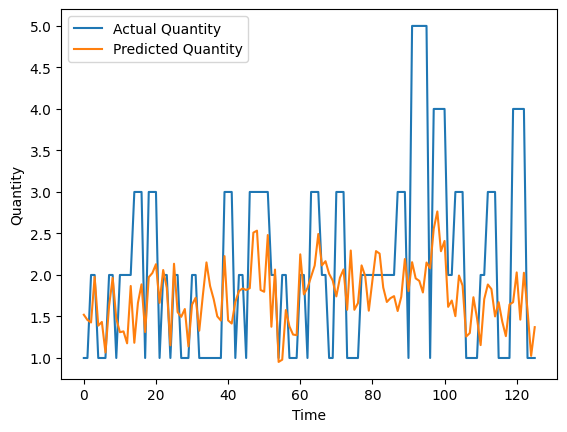

Mean Squared Error: 1.0783119707623414
Root Mean Squared Error: 1.038418013500508
Mean Absolute Error: 0.7852832296537975
Mean Absolute Percentage Error: 0.3816054259343123


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df4, drop_first=True)  # Converts strings to one-hot and drops the first category to avoid multicollinearity

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for LSTM (samples, time steps, features)
train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))

# 2. Model Building

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_features, train_target, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

LSTM TARGET

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0475 
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0417
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0298
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0283
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0192
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6182e-04 
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9472e-04
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4551e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


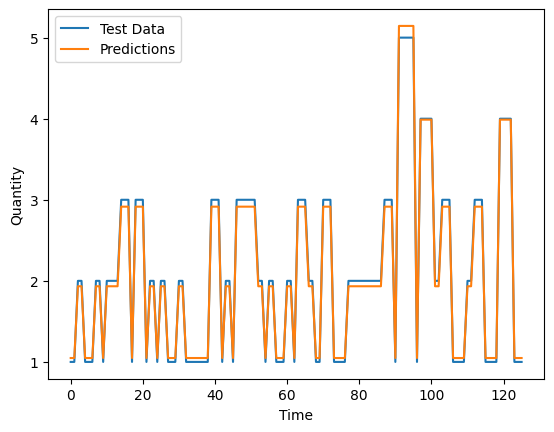

Mean Squared Error: 0.00472695773398761
Root Mean Squared Error: 0.06875287436891354
Mean Absolute Error: 0.06402378233652277
Mean Absolute Percentage Error: 0.035335709115184834


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Extract the 'Quantity' column as the target variable
target_variable = df4['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape input data to be 3D (samples, time steps, features) for RNN input
train_data = np.reshape(train_data, (train_data.shape[0], 1, 1))
test_data = np.reshape(test_data, (test_data.shape[0], 1, 1))

# 2. Model Building

# Create the RNN model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, scaled_target[:train_size], epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data_original = scaler.inverse_transform(scaled_target[train_size:])

# Plot the predictions and test data
plt.plot(test_data_original, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")


EXPERIMENTO 5

ARIMA

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm


# Dividir em treino e teste
train_data, test_data = train_test_split(df_sorted['Quantity'], test_size=0.2, shuffle=False)

#train_data_transformed = np.log1p(train_data)  # log(1 + x) to handle 0 values
#test_data_transformed = np.log1p(test_data)

# If you want to use Box-Cox transformation instead:
train_data_transformed, lmbda = boxcox(train_data + 1)  # Adding 1 to avoid issues with zero values
test_data_transformed = boxcox(test_data + 1, lmbda)

# Initialize history with the transformed training data
history = [x for x in train_data_transformed]
predictions = []

# Automatically discover the best p, d, q values using transformed data
p, d, q = (1,0,1)#auto_model.order  # Extract best p, d, q parameters from Auto-ARIMA

# Perform rolling forecast
for t in range(len(test_data_transformed)):
    # Fit the ARIMA model on the rolling history
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()

    # Make the forecast for the next time step
    yhat = model_fit.forecast()[0]

    # Store the prediction
    predictions.append(yhat)

    # Add the true observation from test_data_transformed to history (rolling update)
    history.append(test_data_transformed[t])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Inverse the transformation (log to original scale)
#predictions = np.expm1(predictions)  # Inverse log(1+x) -> exp(x)-1
#test_data_original = np.expm1(test_data_transformed)

# If using Box-Cox:
predictions = (predictions * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Evaluate the performance
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Best (p, d, q): {p, d, q}")

# Plot predictions vs actual values
plt.plot(test_data_original, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


KeyboardInterrupt: 

RNN

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


582/582 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0036 - val_loss: 4.1044e-04
Epoch 2/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.8091e-04 - val_loss: 3.5190e-04
Epoch 3/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.7657e-04 - val_loss: 3.4517e-04
Epoch 4/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.4488e-04 - val_loss: 3.4408e-04
Epoch 5/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.2255e-04 - val_loss: 3.3758e-04
Epoch 6/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.0047e-04 - val_loss: 4.2417e-04
Epoch 7/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.8530e-04 - val_loss: 3.6791e-04
Epoch 8/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.0926e-04 - val_loss: 3.3662e-04
Epoch 9/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.3192e-04 - val_loss: 4.1362e-04
Epoch 10/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.7418e-04 - val_loss: 3.4035e-04
Epoch 11/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.2806e-04 - 

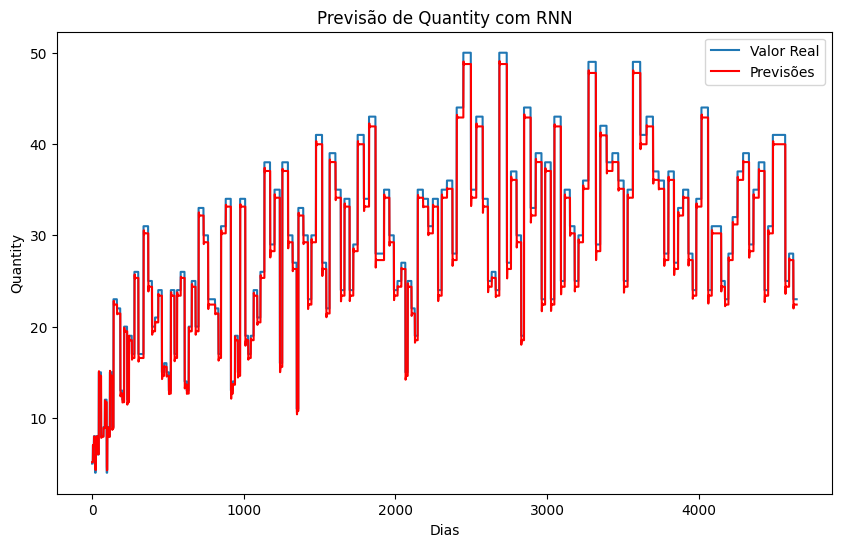

Mean Squared Error: 3.947612113081144
Root Mean Squared Error: 1.9868598624666873
Mean Absolute Error: 1.0300608670452422
Mean Absolute Percentage Error: 0.036045123031685576


In [109]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

# 1. Pré-processamento dos dados
# Supondo que o DataFrame 'df' já tenha sido calculado com a coluna 'Quantity'
# A coluna 'Quantity' deve ser o número total de ocorrências por dia, conforme explicado.

# Escalonamento da coluna 'Quantity' (normalização para o intervalo [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
df_sorted['Quantity_scaled'] = scaler.fit_transform(df_sorted[['Quantity']])

# 2. Criação de janelas de tempo
time_step = 10  # Número de passos de tempo a serem considerados para a predição

# Função para criar o dataset com janelas de tempo
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# Dividir em treino e teste
train_data, test_data = train_test_split(df_sorted['Quantity_scaled'], test_size=0.2, shuffle=False)

# Criar datasets de treinamento e teste
X_train, y_train = create_dataset(train_data.values, time_step)
X_test, y_test = create_dataset(test_data.values, time_step)

# Reformatar para o formato esperado pelo RNN (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Adicionando a dimensão 'features'
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 3. Criação do Modelo RNN
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(time_step, 1)))  # RNN com 50 unidades
model.add(Dense(1))  # Camada de saída com 1 unidade (previsão para o próximo valor)

# 4. Compilação do Modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Treinamento do Modelo
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# 6. Realizando previsões
predictions = model.predict(X_test)

# Inversão da transformação para retornar ao valor original da 'Quantity'
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Avaliação do Modelo
# Plotando a previsão vs o valor real
plt.figure(figsize=(10,6))
plt.plot(y_test_original, label='Valor Real')
plt.plot(predictions, label='Previsões', color='red')
plt.title('Previsão de Quantity com RNN')
plt.xlabel('Dias')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 8. Cálculo das métricas de desempenho
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)
mape = mean_absolute_percentage_error(y_test_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")



RNN TARGET

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0030
Epoch 2/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1734e-04
Epoch 3/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 8.1204e-05
Epoch 4/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.7059e-05
Epoch 5/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.3437e-05
Epoch 6/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.6824e-05
Epoch 7/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.4489e-05
Epoch 8/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3780e-05
Epoch 9/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.0241e-05
Epoch 10/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.2689e-05
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


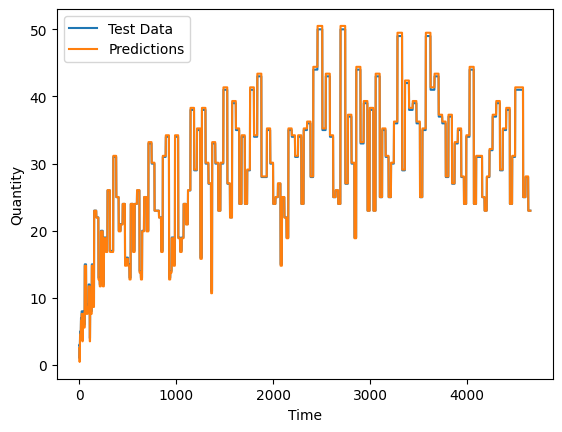

Mean Squared Error: 0.05994900623252496
Root Mean Squared Error: 0.24484486156038676
Mean Absolute Error: 0.2030252303295389
Mean Absolute Percentage Error: 0.007590295763198334


In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Extract the 'Quantity' column as the target variable
target_variable = df_sorted['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape input data to be 3D (samples, time steps, features) for RNN input
train_data = np.reshape(train_data, (train_data.shape[0], 1, 1))
test_data = np.reshape(test_data, (test_data.shape[0], 1, 1))

# 2. Model Building

# Create the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, scaled_target[:train_size], epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data_original = scaler.inverse_transform(scaled_target[train_size:])

# Plot the predictions and test data
plt.plot(test_data_original, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")


LSTM

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - loss: 0.0092
Epoch 2/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - loss: 4.2443e-04
Epoch 3/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - loss: 2.5778e-04
Epoch 4/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - loss: 1.8859e-04
Epoch 5/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - loss: 1.7638e-04
Epoch 6/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - loss: 1.7548e-04
Epoch 7/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - loss: 1.5854e-04
Epoch 8/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - loss: 1.6055e-04
Epoch 9/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - loss: 1.4544e-04
Epoch 10/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - loss: 1.4896e-04
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


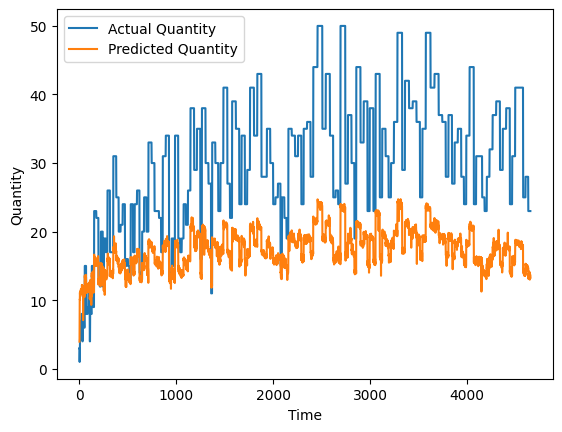

Mean Squared Error: 217.60714388802037
Root Mean Squared Error: 14.751513274509174
Mean Absolute Error: 13.302308714489632
Mean Absolute Percentage Error: 0.41477035289004344


In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Data Preparation

# Handle categorical string columns by converting them to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df_sorted, drop_first=True)  # Converts strings to one-hot and drops the first category to avoid multicollinearity

# Extract all columns except 'Quantity' as features
features = df_encoded.drop('Quantity', axis=1).values

# Extract 'Quantity' as the target variable
target_variable = df_encoded['Quantity'].values

# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_target) * 0.8)
train_features, test_features = scaled_features[0:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape the data to be 3D for LSTM (samples, time steps, features)
train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))

# 2. Model Building

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer with 1 unit (predicting 'Quantity')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_features, train_target, epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test set
predictions = model.predict(test_features)

# Inverse transform the predictions and the test data to get the original scale
predictions = scaler_target.inverse_transform(predictions)
test_target = scaler_target.inverse_transform(test_target)

# Plot the predictions and actual test data
plt.plot(test_target, label='Actual Quantity')
plt.plot(predictions, label='Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics
mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

LSTM TARGET

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


583/583 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0085
Epoch 2/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1114e-04
Epoch 3/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.9141e-05
Epoch 4/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.1615e-05
Epoch 5/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.7109e-05
Epoch 6/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.8199e-05
Epoch 7/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.4503e-05
Epoch 8/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.7377e-05
Epoch 9/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 5.2993e-05
Epoch 10/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.0917e-05
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


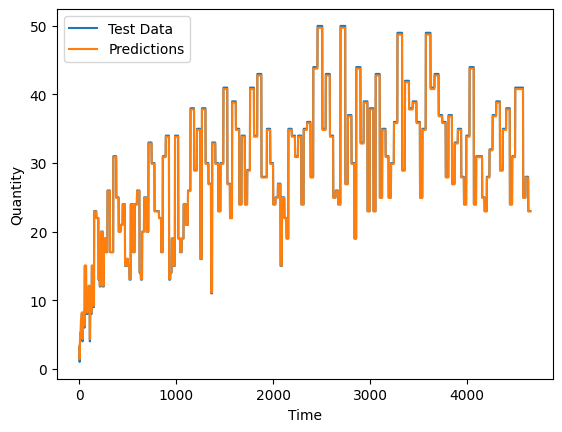

Mean Squared Error: 0.02343984983960379
Root Mean Squared Error: 0.15310078327560506
Mean Absolute Error: 0.13729616168335274
Mean Absolute Percentage Error: 0.005046090066288509


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Extract the 'Quantity' column as the target variable
target_variable = df_sorted['Quantity'].values

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_target) * 0.8)
train_data, test_data = scaled_target[0:train_size], scaled_target[train_size:]

# Reshape input data to be 3D (samples, time steps, features) for RNN input
train_data = np.reshape(train_data, (train_data.shape[0], 1, 1))
test_data = np.reshape(test_data, (test_data.shape[0], 1, 1))

# 2. Model Building

# Create the RNN model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Model Training

# Train the model
history = model.fit(train_data, scaled_target[:train_size], epochs=10, batch_size=32)

# 4. Prediction and Evaluation

# Predict the test data
predictions = model.predict(test_data)

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data_original = scaler.inverse_transform(scaled_target[train_size:])

# Plot the predictions and test data
plt.plot(test_data_original, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# 5. Evaluation Metrics

mse = mean_squared_error(test_data_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, predictions)
mape = mean_absolute_percentage_error(test_data_original, predictions)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")


In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error # Import necessary metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# ... (Rest of your code remains the same) ...

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error # Import necessary metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# ... (Rest of your code remains the same) ...

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error # Import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout # Changed SimpleRNN to LSTM based on your model initialization

# ... (rest of your code remains the same) ...

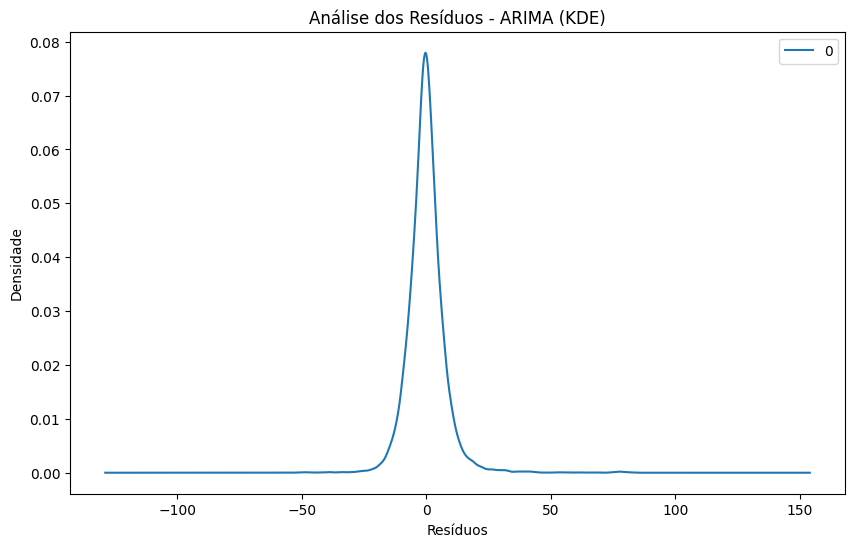

                  0
count  18628.000000
mean      -0.000985
std        7.874396
min      -58.219283
25%       -3.914295
50%       -0.310261
75%        3.294011
max       83.223209


In [88]:
# Exemplo de divisão dos dados em treino e teste
train_data, test_data = train_test_split(df['Quantity'], test_size=0.2, shuffle=False)

# Ajustando o modelo ARIMA (supondo p, d, q = 1, 0, 1)
model = ARIMA(train_data, order=(1, 0, 1))
model_fit = model.fit()

# Calculando os resíduos do modelo ARIMA
residuals = pd.DataFrame(model_fit.resid)

# Plotando a distribuição dos resíduos usando KDE (Kernel Density Estimation)
residuals.plot(kind='kde', figsize=(10, 6))
plt.title('Análise dos Resíduos - ARIMA (KDE)')
plt.xlabel('Resíduos')
plt.ylabel('Densidade')
plt.show()

# Exibindo as estatísticas descritivas dos resíduos
print(residuals.describe())

In [89]:
df

id_ocorrencia  lat_ocorrencia  lon_ocorrencia  \
0           40045445      -28.684659      -49.388056   
1          130041858      -27.146564      -48.505497   
2           40046947      -28.679681      -49.364891   
3          130041869      -27.153351      -48.484377   
4          130041884      -27.034795      -48.669560   
...              ...             ...             ...   
23280       80117658      -28.070704      -48.622803   
23281       80117841      -28.026137      -48.615941   
23282       20110446      -27.444620      -51.245612   
23283       20110449      -27.392914      -51.218675   
23284       20110484      -27.155513      -50.908091   

                               tipo                   subtipo       Dates  \
0      SALVAMENTO / BUSCA / RESGATE                       NaN  2017-05-20   
1      SALVAMENTO / BUSCA / RESGATE                       NaN  2017-10-23   
2      SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2017-06-29   
3      SALVAMENTO / BUSCA / RESGATE                       NaN  2017-10-24   
4      SALVAMENTO / BUSCA / RESGATE                       NaN  2017-10-24   
...                             ...                       ...         ...   
23280  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2021-01-13   
23281  SALVAMENTO / BUSCA / RESGATE  OBJETO EM LOCAL DE RISCO  2021-01-17   
23282  SALVAMENTO / BUSCA / RESGATE               CAPOTAMENTO  2020-08-28   
23283  SALVAMENTO / BUSCA / RESGATE            COLISÃO/CHOQUE  2020-08-28   
23284  SALVAMENTO / BUSCA / RESGATE               CAPOTAMENTO  2020-08-29   

           Time  Hour  Year  Month  Day  Quantity  diff  
0      16:40:00    16  2017      5   20        16   NaN  
1      17:14:00    17  2017     10   23        24   8.0  
2      20:37:00    20  2017      6   29        21  -3.0  
3      10:38:00    10  2017     10   24        17  -4.0  
4      16:34:00    16  2017     10   24        17   0.0  
...         ...   ...   ...    ...  ...       ...   ...  
23280  13:18:04    13  2021      1   13        31   3.0  
23281  10:10:51    10  2021      1   17        28  -3.0  
23282  08:03:08     8  2020      8   28        21  -7.0  
23283  10:55:02    10  2020      8   28        21   0.0  
23284  01:19:20     1  2020      8   29        24   3.0  

[23285 rows x 13 columns]

In [90]:
df.drop('diff', axis=1, inplace=True)

Mean Squared Error: 215.64466632887124
Root Mean Squared Error: 14.684844783955711
Mean Absolute Error: 12.4573330580566
Mean Absolute Percentage Error: 0.36808163996088483


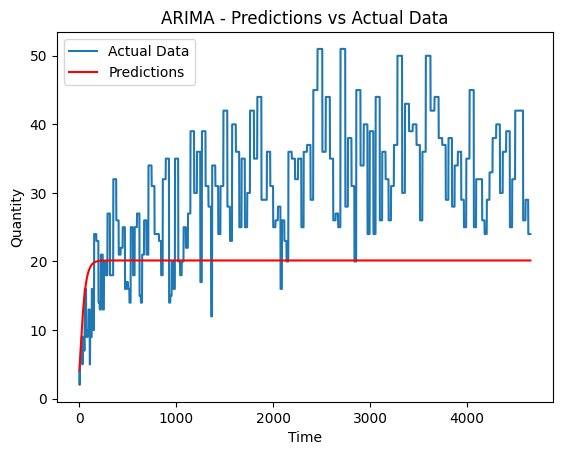

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox

# Dividir em treino e teste
train_data, test_data = train_test_split(df_sorted['Quantity'], test_size=0.2, shuffle=False)

# Transformação Box-Cox (para estabilizar variância e tornar os dados aproximadamente normais)
train_data_transformed, lmbda = boxcox(train_data + 1)  # Adicionando 1 para evitar problemas com valores zero
test_data_transformed = boxcox(test_data + 1, lmbda)

# Definir os valores de p, d, q
p, d, q = (1, 0, 1)

# Ajustar o modelo ARIMA nos dados de treino
model = ARIMA(train_data_transformed, order=(p, d, q))
model_fit = model.fit()

# Fazer previsão para o conjunto de teste
forecast = model_fit.forecast(steps=len(test_data_transformed))

# Inverter a transformação Box-Cox para trazer os valores para a escala original
forecast_original = (forecast * lmbda + 1) ** (1 / lmbda)
test_data_original = (test_data_transformed * lmbda + 1) ** (1 / lmbda)

# Avaliar o desempenho
mse = mean_squared_error(test_data_original, forecast_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_original, forecast_original)
mape = mean_absolute_percentage_error(test_data_original, forecast_original)

# Exibir métricas de avaliação
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

# Plotar previsões vs valores reais
plt.plot(test_data_original, label='Actual Data')
plt.plot(forecast_original, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.title('ARIMA - Predictions vs Actual Data')
plt.show()
